<div style="background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; border: 1px solid #f5c6cb;">
    <strong>!Warning!</strong> Questo è un avviso importante, eseguire la cella sottostante prima di eseguire le altre celle del notebook.
</div>

In [1]:
# Eseguire prima delle altre celle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from typing import Optional, Union
import librosa
import librosa.display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn
import copy
import tqdm
from torch import optim
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import utils
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, BaggingClassifier)
from sklearn import tree
from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, f1_score

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Introduzione  

Negli ultimi decenni, il web ha rivoluzionato il modo in cui la musica viene condivisa e fruita. Se un tempo le collezioni musicali erano limitate a una manciata di vinili o CD, oggi gli utenti hanno accesso immediato a vastissimi cataloghi musicali attraverso piattaforme online. Questa crescita esponenziale ha posto nuove sfide, tra cui:  

1. **L'organizzazione automatica delle collezioni musicali**, poiché la gestione manuale non è più sostenibile.  
2. **La raccomandazione automatica di nuove canzoni**, basata sulle preferenze di ascolto dell'utente.  

Un aspetto fondamentale per affrontare queste sfide è la capacità di raggruppare i brani in categorie semantiche, come i **generi musicali**. I generi musicali emergono dall’interazione di fattori culturali, artistici e di mercato e vengono utilizzati per descrivere somiglianze tra brani e organizzare le raccolte musicali. Tuttavia, i confini tra generi non sono sempre ben definiti, rendendo il compito del **riconoscimento automatico del genere musicale (Music Genre Recognition, MGR)** una sfida complessa.  

Nonostante le critiche legate alla soggettività e alla variabilità culturale dei generi musicali, essi rimangono una categorizzazione intuitiva e ampiamente utilizzata dagli utenti per descrivere e scoprire nuova musica. Per questo motivo, il MGR è un tema di grande interesse nella ricerca nel campo del **Music Information Retrieval (MIR)**.  

Il compito affrontato in questo notebook è il **riconoscimento automatico del genere musicale** di un brano a partire esclusivamente dalla sua registrazione audio. Il dataset utilizzato per questo studio è il **FMA (Free Music Archive) dataset**, una raccolta di brani musicali curati e di alta qualità, disponibile pubblicamente per la ricerca. Questo compito è stato anche oggetto di una delle sfide ufficiali della **Web Conference (WWW2018)**.  

L'obiettivo di questo lavoro è esplorare tecniche di **apprendimento automatico** e **elaborazione del segnale audio** per classificare i brani nei rispettivi generi, analizzando le caratteristiche musicali e valutando l'efficacia di diversi modelli predittivi.  


# Dati e dataset

Il dataset **FMA (Free Music Archive)** fornisce un insieme di **feature pre-compute** estratte con la libreria **Librosa**, che descrivono diversi aspetti delle tracce audio e vengono utilizzate per la classificazione automatica del genere musicale.

Abbiamo utilizzato la **versione medium** del dataset, che contiene **25.000 tracce** della durata di **30 secondi**, appartenenti a **16 generi musicali**. Per la classificazione, **non abbiamo estratto nuove feature**, ma abbiamo sfruttato direttamente le feature già disponibili nel dataset.


## Dati Audio
*Un segnale audio consiste in una sequenza di campioni audio, dove
 ogni campione (sample) rappresenta l'ampiezza del suono in un istante 
di tempo specifico. In breve, un segnale audio cattura le variazioni di 
pressione dell'aria nel tempo, che sono percepite dall'orecchio umano 
come suoni.
L'ampiezza di un campione rappresenta l'altezza della forma d'onda 
sonora in quel punto specifico. L'ampiezza è direttamente correlata 
all'intensità del suono. I valori positivi rappresentano le compressioni
 dell'aria (pressione positiva), mentre i valori negativi rappresentano 
le rarefazioni dell'aria (pressione negativa).*

In [5]:
# audio directory
AUDIO_DIR = os.path.join(os.getcwd(), 'fma_medium')

# metadata directory
METADATA_DIR = os.path.join(os.getcwd(), 'fma_metadata')


In [6]:
def load_song(genre: str = 'rock', song_number: int = 0) -> tuple[np.ndarray, float]:
    song_title = sorted(os.listdir(os.path.join(AUDIO_DIR, genre)))[song_number]
    song_path = os.path.join(AUDIO_DIR, genre, song_title)
    y, sr = librosa.load(song_path)
    return y, sr

def song_info(y: np.ndarray, sr: float):
    print('y: {}'.format(y))
    print('Duration: {:.2f}s, {} samples, {} KHz'.format(len(y)/sr, len(y), sr/1000))



In [7]:
def plot_waveplot(y, sr, title='Waveplot', xlabel='Time', ylabel='Amplitude', color=None, alpha=0.8):
    plt.figure(figsize=(14, 5))
    if color:
        librosa.display.waveshow(y, sr=sr, color=color, alpha=alpha)
    else:
        librosa.display.waveshow(y, sr=sr, alpha=alpha)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


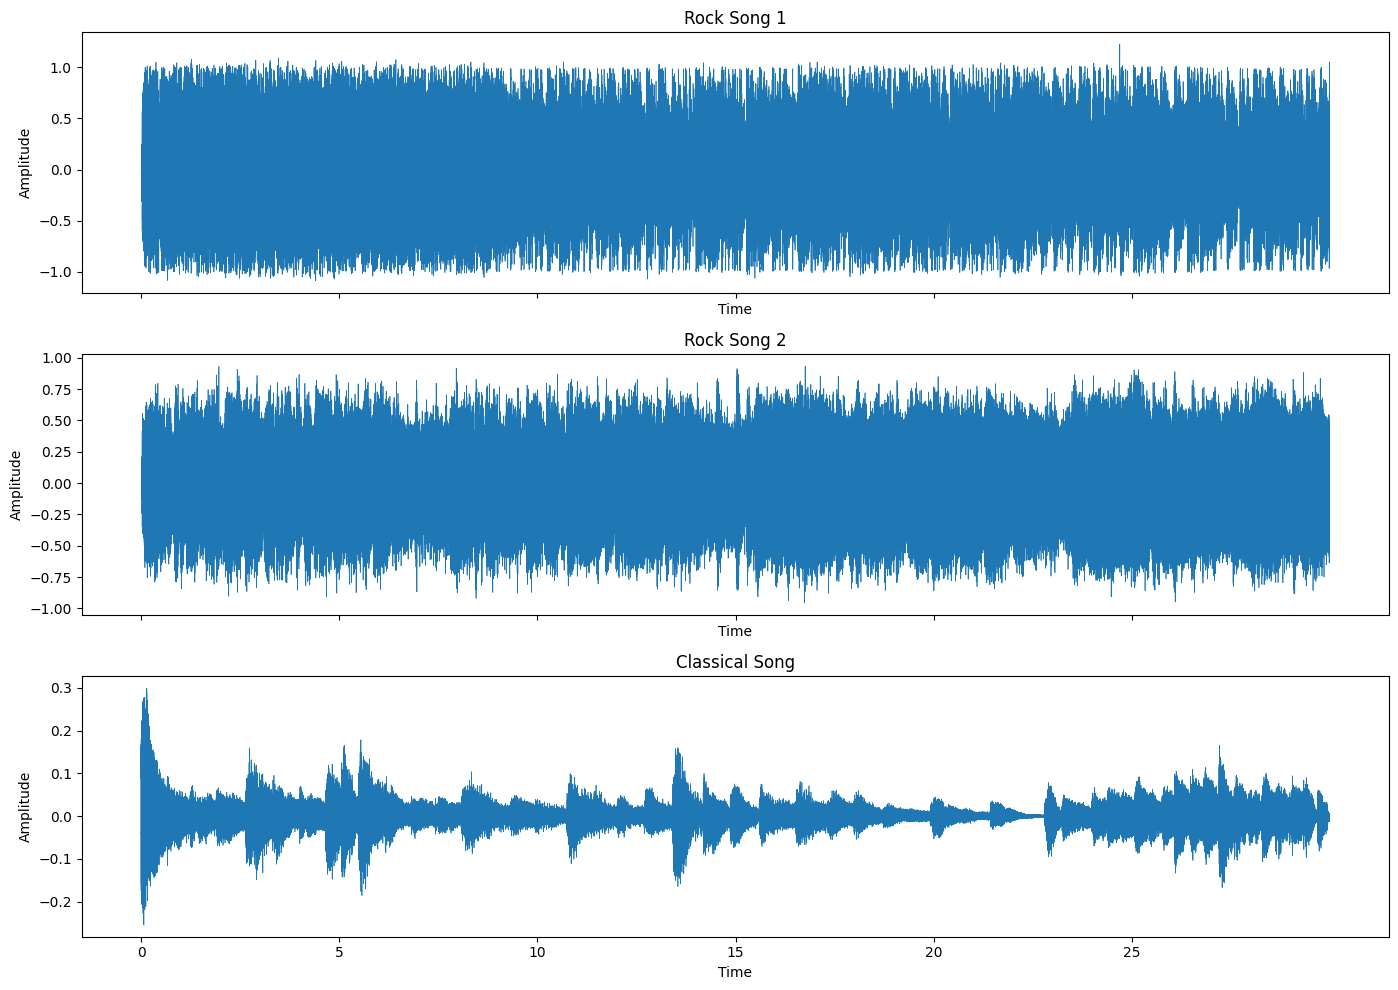

In [11]:
# load songs
y, sr = load_song('rock', 25)
y2, sr2 = load_song('rock', 112)
y3, sr3 = load_song('classical', 35)

# plot the three songs together vertically

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# librosa.display.waveshow(y, sr=sr)
ax1.plot(y, linewidth=0.5)
ax1.set_title('Rock Song 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

ax2.plot(y2, linewidth=0.5)
ax2.set_title('Rock Song 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')

ax3.plot(y3, linewidth=0.5)
ax3.set_title('Classical Song')
ax3.set_xlabel('Time')
ax3.set_ylabel('Amplitude')

# set x ticks to seconds, every 5 seconds starting from 0
x_ticks = np.arange(0, len(y), sr*5)
ax3.set_xticks(x_ticks)
ax3.set_xticklabels((x_ticks/sr).astype(int))

plt.tight_layout()
plt.show()

### Spettrogramma
È una tecnica di analisi molto comune utilizzata nell'elaborazione dei 
segnali audio per mostrare come l'energia del suono è distribuita nelle 
diverse frequenze durante un periodo di tempo specifico.
L'asse delle ascisse rappresenta il tempo, l'asse delle ordinate 
rappresenta la frequenza e il colore l'ampiezza. Le frequenze più basse si trovano 
nella parte inferiore dello spettrogramma, mentre le frequenze più alte 
si trovano nella parte superiore. La frequenza è solitamente misurata in
 unità come Hertz (Hz).

In [9]:
def spectrogram(y, mel=False):
    # normalize the amplitude
    y = librosa.util.normalize(y)

    # Short-time Fourier transform (STFT)
    X = librosa.stft(y)

    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    x_db = librosa.amplitude_to_db(abs(X))

    # Display a spectrogram
    plt.figure(figsize=(14, 5))
    if mel:
        # Mel-scaled power spectrogram
        X_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        x_db_mel = librosa.amplitude_to_db(abs(X_mel), ref=np.max)

        plt.figure(figsize=(14, 10))

        plt.subplot(2, 1, 1)
        librosa.display.specshow(x_db, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Simple Spectrogram')
        plt.colorbar()

        plt.subplot(2, 1, 2)
        librosa.display.specshow(x_db_mel, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Mel-scaled spectrogram')
        plt.colorbar()
        plt.tight_layout()
    else:
        librosa.display.specshow(x_db, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Spectrogram')
        plt.colorbar()

    plt.show()

<Figure size 1400x500 with 0 Axes>

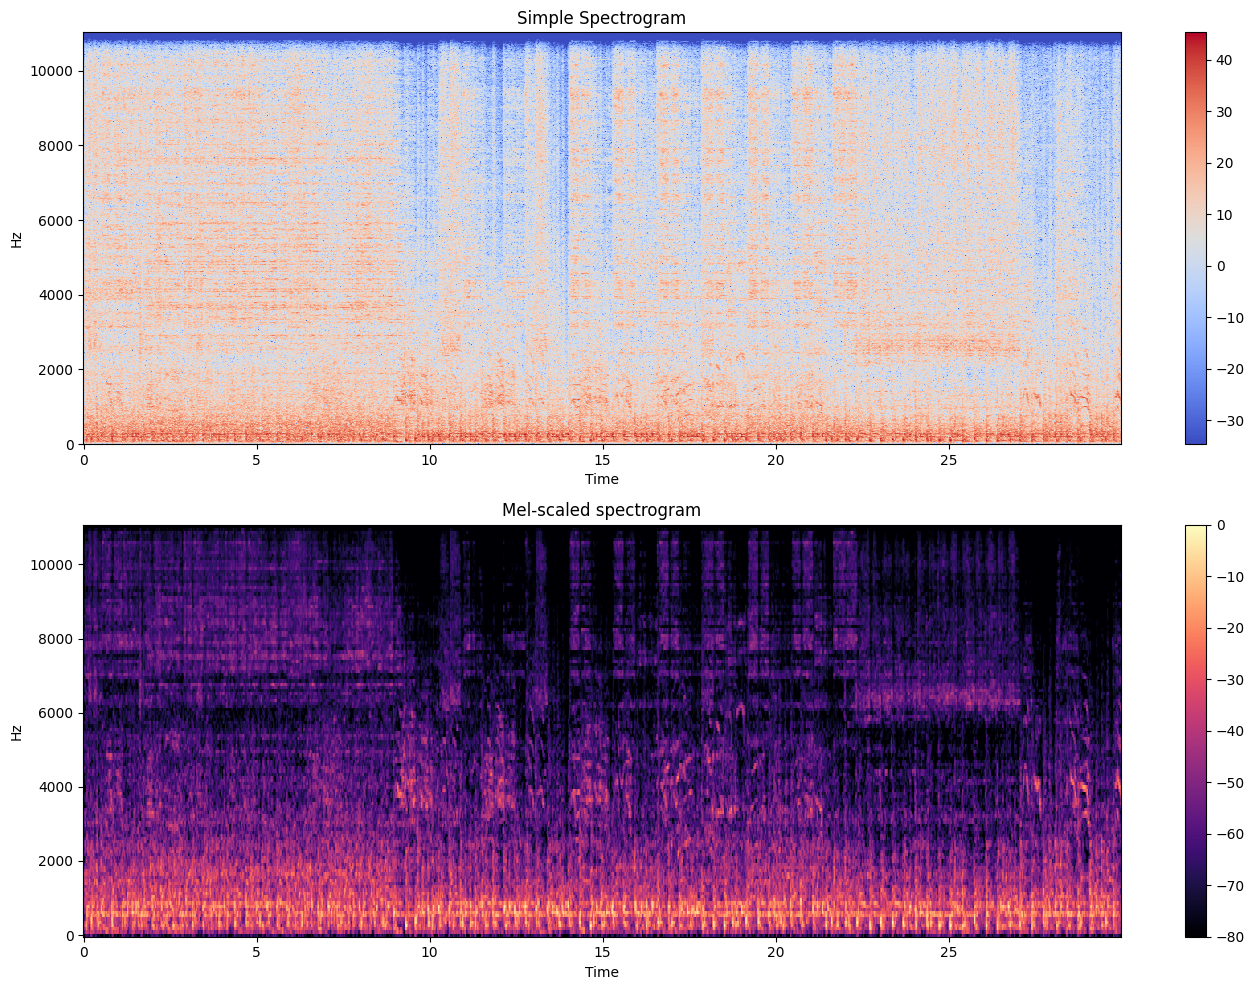

In [10]:
spectrogram(y, True)

## Feature contenute nel dataset

Le feature fornite rappresentano caratteristiche **timbriche, tonali e spettro-temporali** del segnale audio. Sono state calcolate su finestre di **2048 campioni**, con un **hop size di 512 campioni**, e per ciascuna di esse sono state estratte sette statistiche principali: **media, deviazione standard, asimmetria (skewness), curtosi, mediana, minimo e massimo**.

Di seguito le principali feature disponibili:

- **MFCC (Mel-Frequency Cepstral Coefficients) [140 dimensioni]**: rappresentano il timbro del suono e sono molto utilizzati nell'elaborazione audio.
- **Chroma Features [252 dimensioni]**: descrivono la distribuzione delle frequenze nella scala musicale, utili per analizzare tonalità e armonie.
- **Tonnetz Features [42 dimensioni]**: catturano la struttura armonica del brano e le relazioni tonali.
- **Spectral Centroid [7 dimensioni]**: indica il "centro di massa" dello spettro di frequenza, utile per distinguere tra suoni acuti e gravi.
- **Spectral Bandwidth [7 dimensioni]**: misura la dispersione delle frequenze attorno al centroide.
- **Spectral Contrast [49 dimensioni]**: quantifica la differenza tra le parti più intense e meno intense dello spettro.
- **Spectral Rolloff [7 dimensioni]**: identifica la frequenza sotto la quale si trova il **95% dell'energia spettrale**.
- **RMS Energy (Root Mean Square Energy) [7 dimensioni]**: misura l'energia complessiva del segnale, utile per analizzare il volume medio del brano.
- **Zero-Crossing Rate [7 dimensioni]**: conta il numero di volte in cui il segnale attraversa lo zero, utile per distinguere suoni percussivi da quelli armonici.

Queste informazioni sono memorizzate nel file **features.csv**, dove ogni riga rappresenta una traccia e ogni colonna una delle feature estratte.

Segue ora una descrizione più approfondita di alcune delle feature utilizzate.

### Zero Crossing Rate
Viene utilizzata per calcolare il tasso di attraversamento dello zero in
 un segnale audio. Il tasso di attraversamento dello zero rappresenta il
 numero di volte in cui la forma d'onda di un segnale attraversa l'asse 
orizzontale (zero) in un determinato intervallo di tempo.

In [12]:
def plot_zero_cross_rate(y1, y2, label1, label2, zero_line=True):

    # zero crossing rate
    z1 = librosa.feature.zero_crossing_rate(y1)
    z2 = librosa.feature.zero_crossing_rate(y2)


    # plot a graph with the two crossing rates, and one with the difference between the tww (horizontally)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
    fig.suptitle('Zero Crossing Rate', fontsize=16)

    # left plot
    ax1.plot(z1[0], label=label1, linewidth=.5)
    ax1.plot(z2[0], label=label2, linewidth=.5)

    # mean line
    m1 = np.mean(z1)
    m2 = np.mean(z2)
    ax1.axhline(m1, color='blue', linestyle='--', linewidth=2, label=f'Mean of {label1}')
    ax1.axhline(m2, color='red', linestyle='--', linewidth=2, label=f'Mean of {label2}')

    # right plot
    z3 = z1 - z2
    ax2.plot(z3[0], color='green', label='Difference', linewidth=.5)
    ax2.set_title('Difference between the two crossing rates')

    # mean line
    m3 = np.mean(z3)
    ax2.axhline(m3, color='purple', linestyle='--', linewidth=2, label=f'Mean of the difference')

    if zero_line:
        ax1.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax1.set_title('Zero Crossing Rate')
        ax2.set_title('Zero Crossing Rate')

    ax1.legend()
    ax2.legend()

    plt.show()

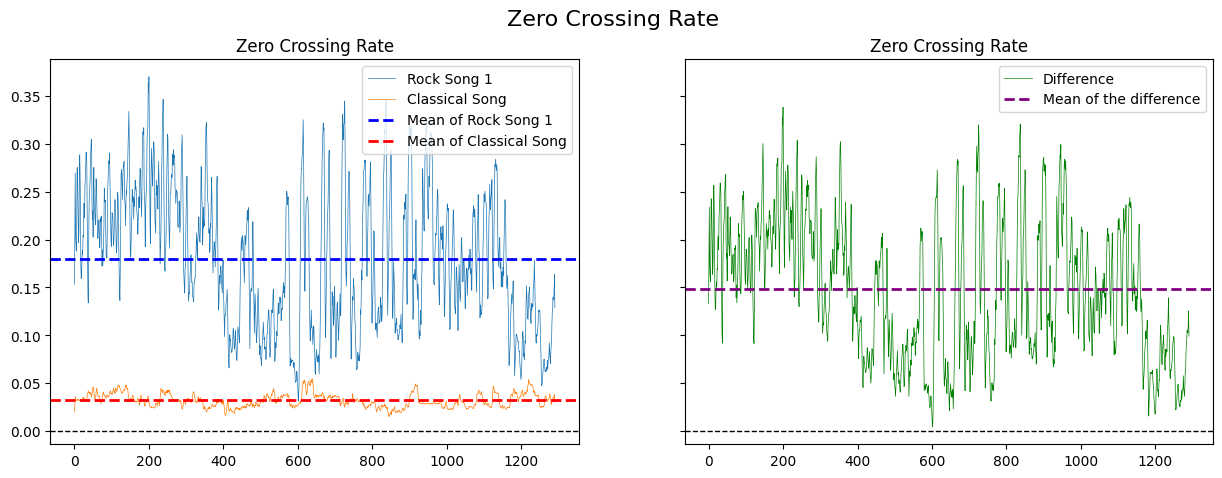

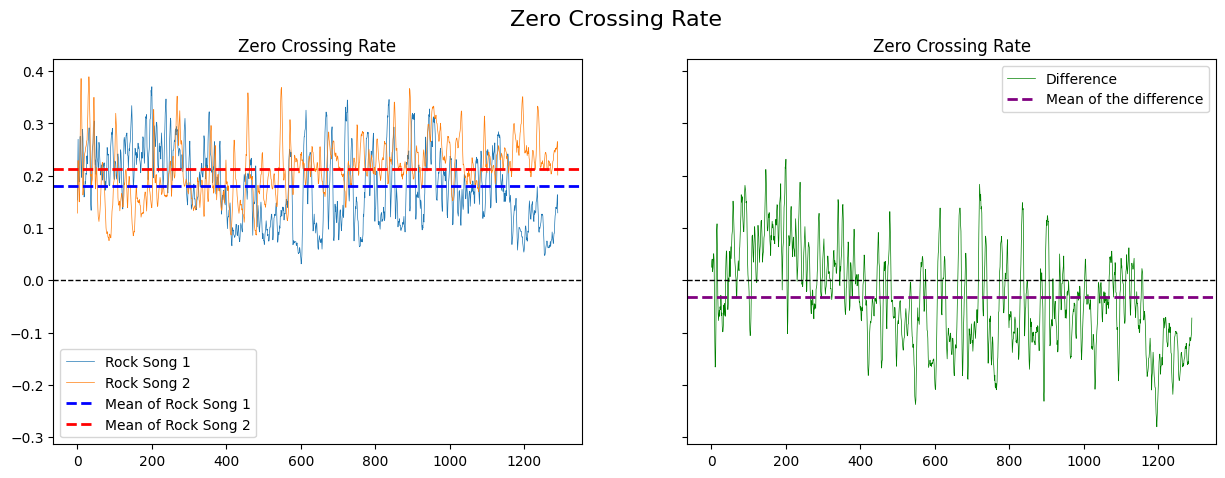

In [13]:
plot_zero_cross_rate(y, y3, 'Rock Song 1', 'Classical Song')
plot_zero_cross_rate(y, y2, 'Rock Song 1', 'Rock Song 2')

### RMS Energy
La ***Root Mean Square Energy*** è una misura dell'energia complessiva o della sonorità del segnale nel tempo. Fornisce informazioni sulle variazioni di ampiezza del segnale audio.

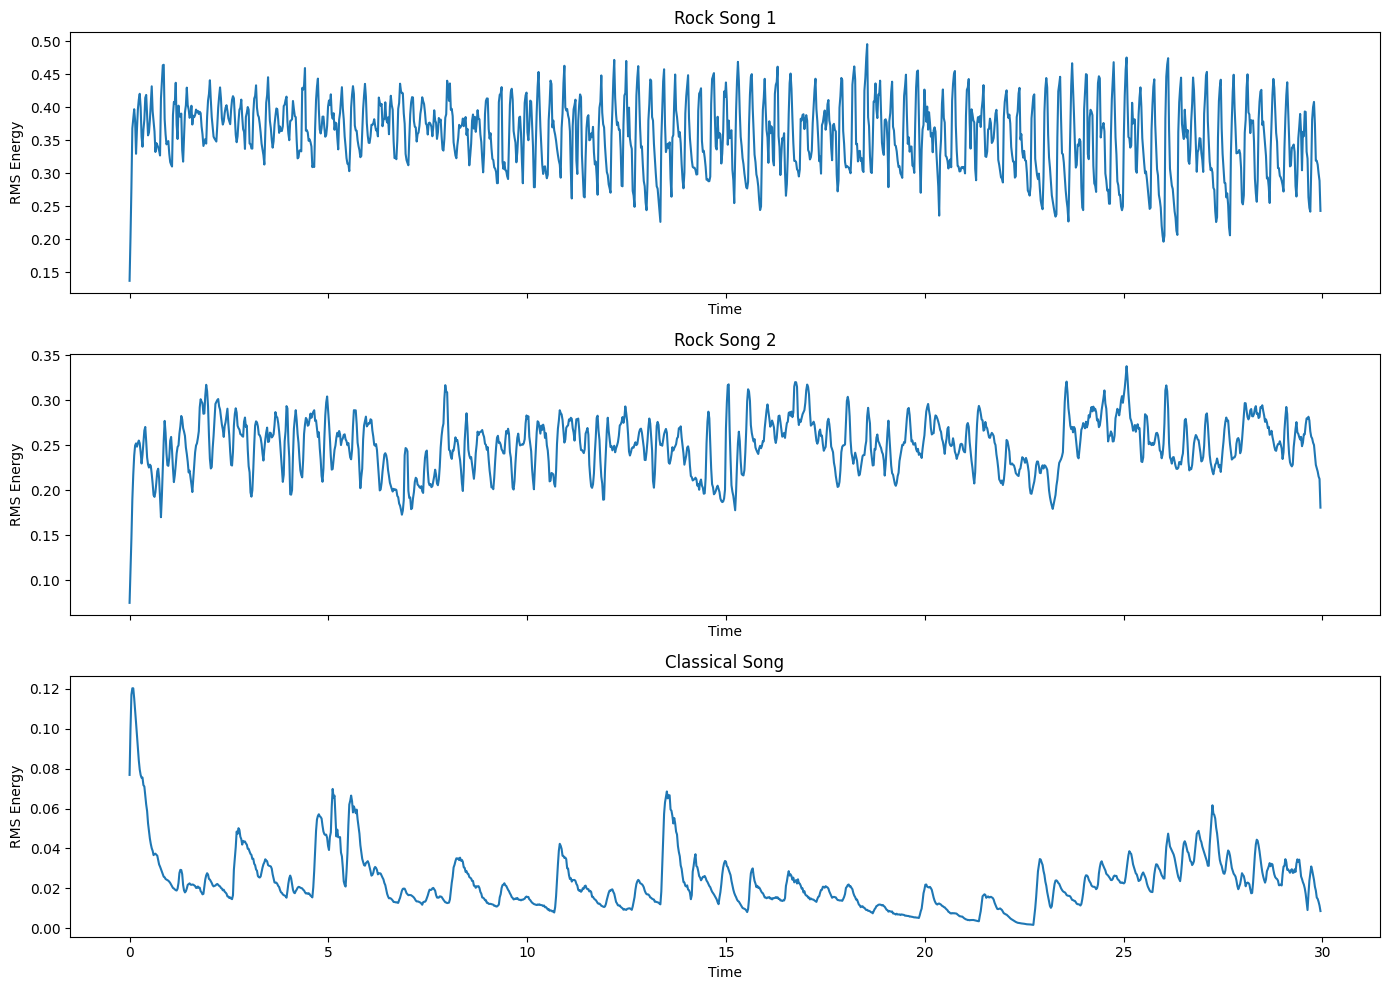

In [14]:
# Calculate RMS energy
rms1 = librosa.feature.rms(y=y)
rms2 = librosa.feature.rms(y=y2)
rms3 = librosa.feature.rms(y=y3)

times = librosa.times_like(rms1)

# Plot RMS energy
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# librosa.display.waveshow(y, sr=sr)
ax1.plot(times, rms1[0])
ax1.set_title('Rock Song 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMS Energy')

ax2.plot(times, rms2[0])
ax2.set_title('Rock Song 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('RMS Energy')

ax3.plot(times, rms3[0])
ax3.set_title('Classical Song')
ax3.set_xlabel('Time')
ax3.set_ylabel('RMS Energy')

# set x ticks to seconds, every 5 seconds starting from 0
x_ticks = np.arange(0, len(y), sr*5)

plt.tight_layout()
plt.show()

### Mel-Frequency Cepstral Coefficients
Sono una serie di coefficienti utilizzati per rappresentare le caratteristiche spettrali di un segnale audio in un formato compatibile con la percezione umana delle frequenze (vengono utilizzati soprettutto per il riconoscimento e la sintesi vocale).
Per essere più precisi, i coefficienti MFCC rappresentano una serie di valori numerici che catturano le caratteristiche spettrali del segnale audio in un dato frame temporale.
Ad esempio, nella cella (1,2) troveremo il valore del terzo coefficiente di mel nel secondo frame.

In [15]:
def plot_mfcc(*Y, sr, songs_names=None):

    n = len(Y)
    fig, ax = plt.subplots(n, 1, figsize=(14, 5*n), sharex=True)
    fig.suptitle('Mel-frequency cepstral coefficients (MFCC)', fontsize=16)

    if n == 1:
        ax = [ax]

    for i in range(n):

        # mfcc of the song
        mfcc = librosa.feature.mfcc(y=Y[i], sr=sr)

        mean = np.mean(mfcc)
        variance = np.var(mfcc)

        # scale the mfcc
        mfcc = skl.preprocessing.scale(mfcc, axis=1)

        # display the mfcc
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax[i])

        # set title
        title = songs_names[i] if songs_names else f'Song {i+1}'
        ax[i].set_title(f'{title}\nMean: {mean:.2f}, Variance: {variance:.2f}')

        # set x and y labels
        ax[i].set_xlabel(None)
        ax[i].set_ylabel('MFCC')

    ax[-1].set_xlabel('Time')

    plt.show()

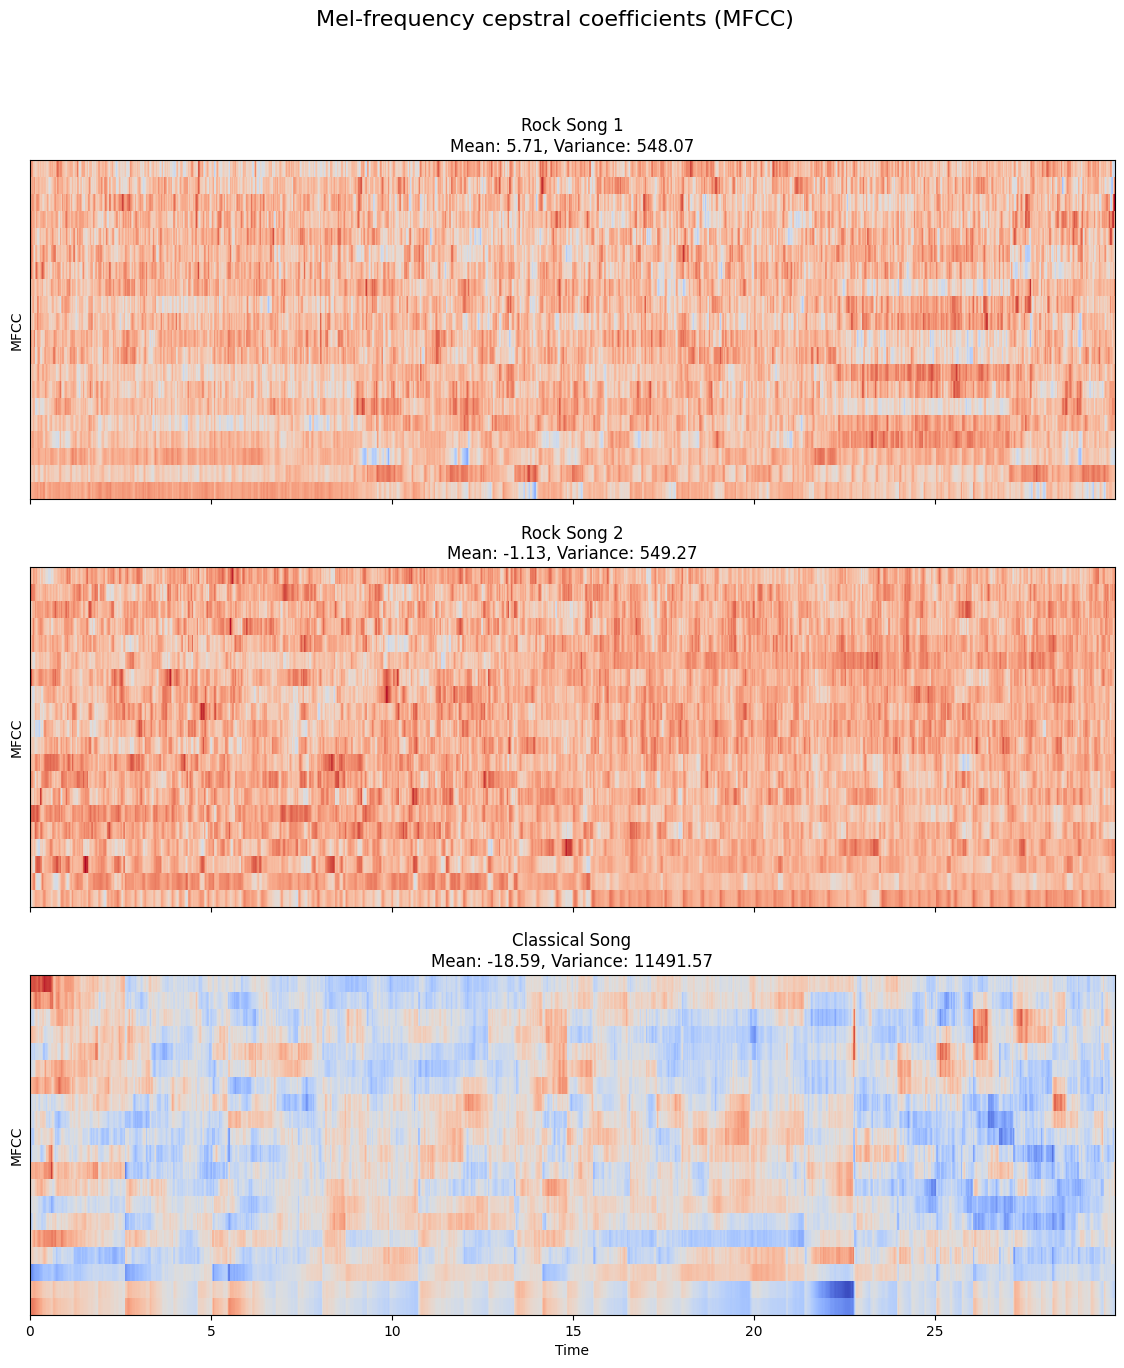

In [16]:
plot_mfcc(y, y2, y3, sr=sr, songs_names=['Rock Song 1', 'Rock Song 2', 'Classical Song'])

### Spectral centroid
è una misura del 'centro di massa' dello spettro. Indica dove si trova 
il 'centro' del suono in termini di frequenza. Percettivamente, è 
strettamente correlato alla sensazione di 'brillantezza' di un suono.

In [17]:
def normalize(x, axis=0):

    return skl.preprocessing.minmax_scale(x, axis=axis)

def plot_spectral_centroid(*Y, sr, title='Spectral Centroid', xlabel='Time', ylabel='Frequency', songs_names=None):

    n = len(Y)
    fig, ax = plt.subplots(n, 1, figsize=(14, 5*n), sharex=True)

    fig.suptitle(title, fontsize=16)

    if n == 1:
        ax = [ax]

    for i in range(n):
        y = Y[i]

        # Computing the spectral centroid for each frame
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

        # Computing the time variable for visualization
        frames = range(len(cent))

        # Converts frame counts to time (seconds)
        t = librosa.frames_to_time(frames)

        librosa.display.waveshow(y, sr=sr, linewidth=.5,  alpha=0.4, ax=ax[i])
        ax[i].plot(t, normalize(cent), color='#FFB100', label='Spectral Centroid', linewidth=2)

        title = songs_names[i] if songs_names else f'Song {i+1}'

        ax[i].set_title(title)
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

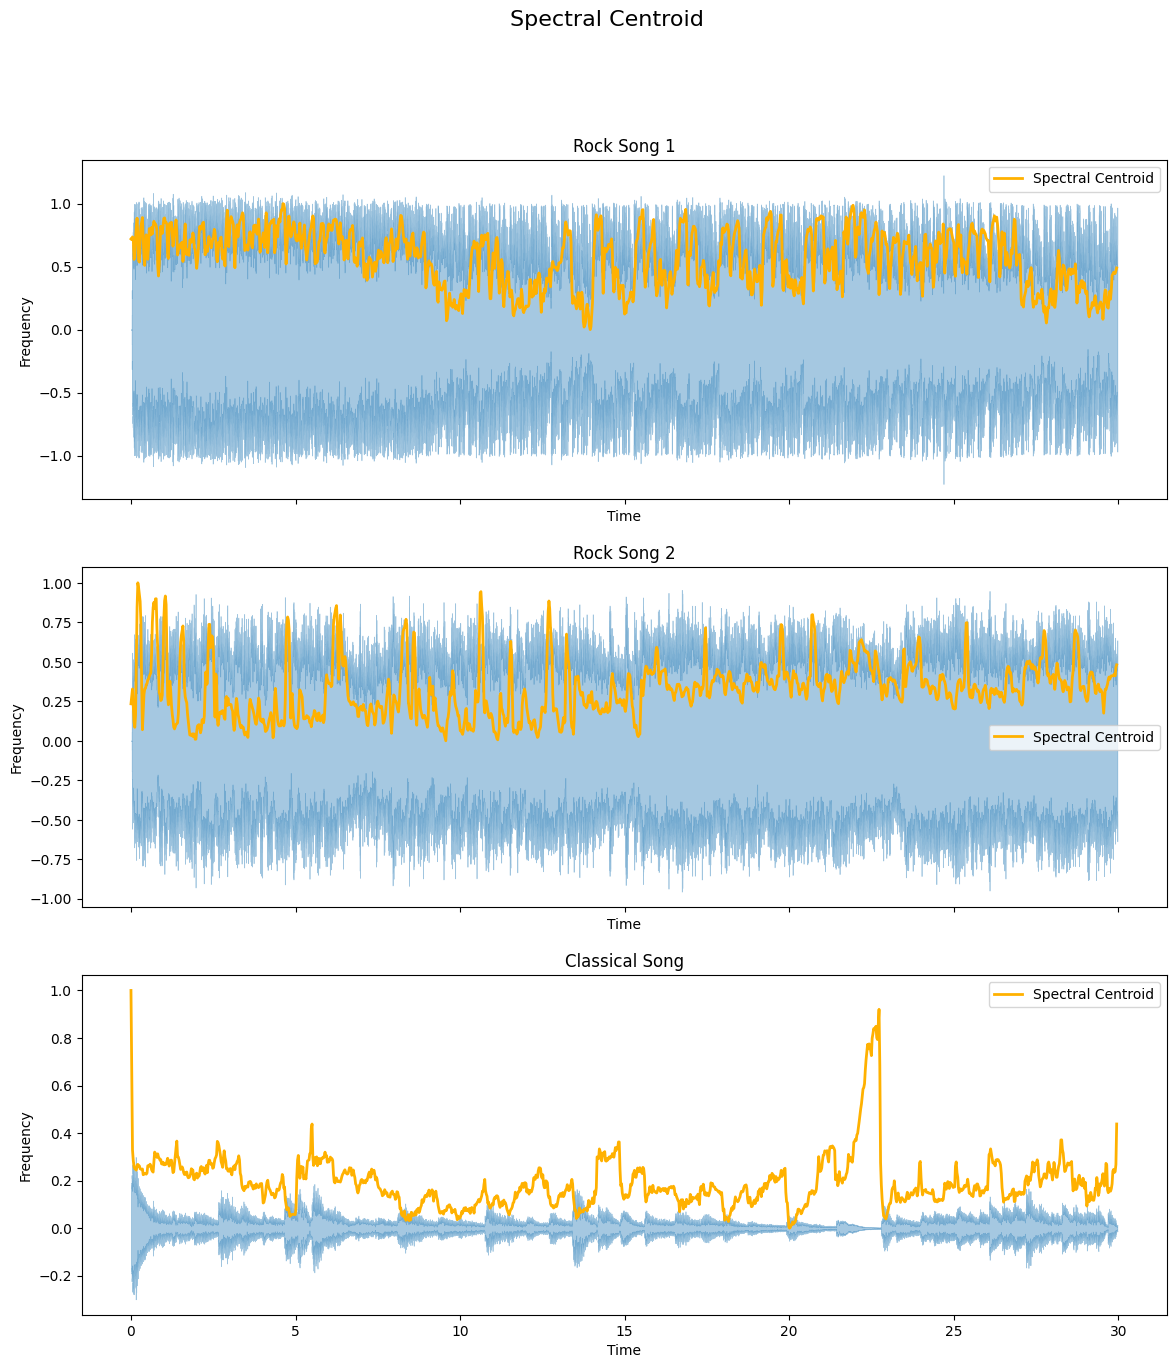

In [18]:
plot_spectral_centroid(y, y2, y3, sr=sr, songs_names=['Rock Song 1', 'Rock Song 2', 'Classical Song'])

### Chroma Features
Le Chroma Features, sono strumenti utili ad analizzare il contenuto armonico e tonale della musica. Sono particolarmente utili per compiti che coinvolgono 
l'analisi del tono e dell'armonia, come il riconoscimento degli accordi, il rilevamento della tonalità e la stima della somiglianza musicale.

Le Chroma features rappresentano l'intensità di ciascuna delle 12 classi di tonalità (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) nel segnale audio, indipendentemente dall'ottava. Questo le rende particolarmente adatte per l'analisi delle caratteristiche armoniche e melodiche della musica.

Concetti chiave:

- **classe di tonalità**: tutte le tonalità che condividono la stessa nota (ad esempio, tutte le note C nelle diverse ottave);
- **"Invarianza d'ottava**: le caratteristiche sommano l'energia su tutte le ottave per ciascuna classe di note.

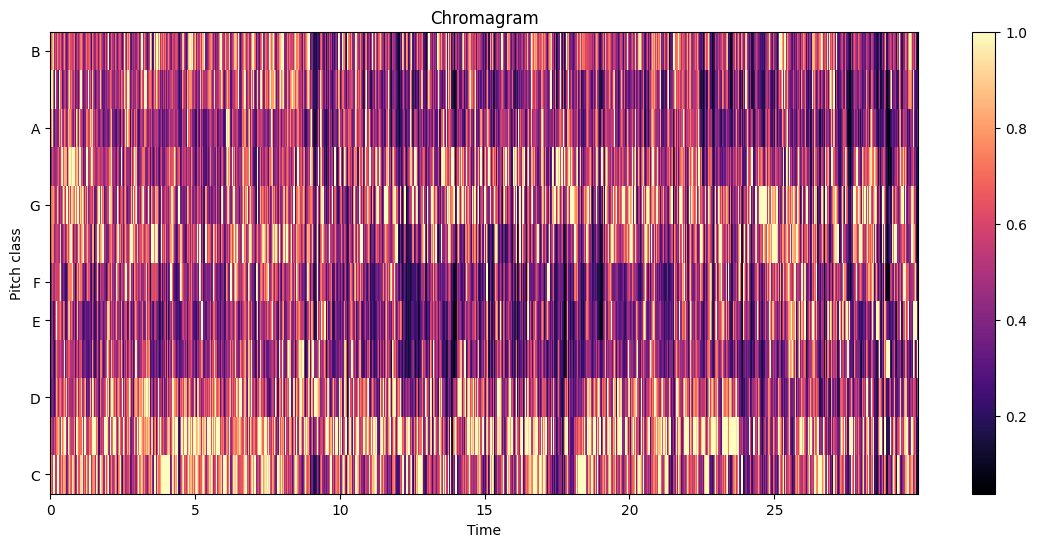

In [19]:
# Compute chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Visualize chroma features
plt.figure(figsize=(14, 6))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.show()

## Motivazione delle scelte

Per ottenere una rappresentazione più efficace dei dati, avremmo potuto utilizzare degli **autoencoder**, una classe di reti neurali progettate per apprendere una rappresentazione compressa e significativa degli input. Gli autoencoder avrebbero potuto estrarre caratteristiche più astratte e strutturate dai dati audio, migliorando potenzialmente la classificazione dei generi musicali.

Tuttavia, il **formato audio** è complesso da gestire e richiede tecniche avanzate di elaborazione del segnale, come la conversione in spettrogrammi o l'uso di architetture specializzate per sequenze temporali, come le **RNN (Reti Neurali Ricorrenti)** o i **Transformer**. Poiché a lezione non abbiamo affrontato modelli per la gestione di **sequenze di dati**, abbiamo preferito evitare questa strada e concentrarci sull'utilizzo delle feature pre-estratte, già fornite nel dataset.

L'obiettivo del nostro lavoro è stato quindi analizzare e confrontare diverse tecniche di **machine learning**, valutando le performance ottenute con le feature disponibili.

# Analisi esplorativa

Innanzi tutto osserviamo che il nostro dataset conta un totale di 25000 osservazioni e 518 feature. Ad ognuna di esse è associato un genere target.

In [3]:
X = utils.load('./fma_metadata/features_medium.csv')
y = pd.read_csv('./fma_metadata/train_labels.csv', index_col=0)

np.testing.assert_array_equal(X.index, y.index)

X.shape, y.shape

((25000, 518), (25000, 1))

Verifichiamo ora quante occorrenze sono presenti nel nostro dataset

In [4]:
CATEGORIES = sorted(y["genre"].unique())

y.groupby('genre').size()

genre
blues                    74
classical               619
country                 178
easy listening           21
electronic             6314
experimental           2251
folk                   1519
hip-hop                2201
instrumental           1350
international          1018
jazz                    384
old-time / historic     510
pop                    1186
rock                   7103
soul-rnb                154
spoken                  118
dtype: int64

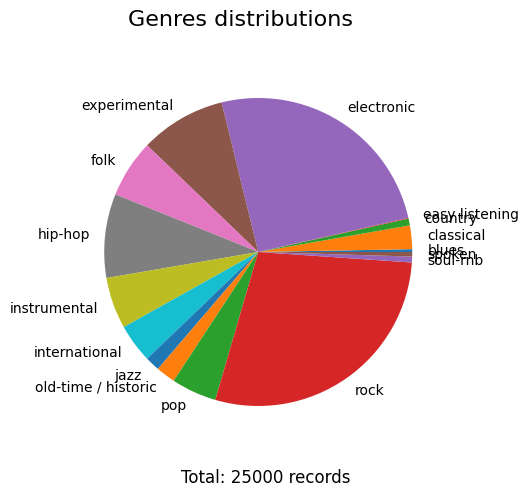

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), facecolor='white')
fig.suptitle('Genres distributions', fontsize=16)

# plot a bar chart of genres
ax.pie(y.groupby('genre').size(), labels=CATEGORIES)
ax.text(-.5, -1.5, 'Total: {} records'.format(len(y)), fontsize=12)

plt.show()

Si evince quindi che il dataset è molto sbilanciato, con classi che contano migliaia di osservazioni e classi che ne contano poche decine. Segue poi un pò di data cleaning per assicurarci che tutti i dati siano nel giusto formato e non siano presenti valori strani.

In [6]:
# Data cleaning
X = X.drop(utils.FILES_TRAIN_FAULTY)
y = y.drop(utils.FILES_TRAIN_FAULTY)

# The track IDs are integers for the training set.
X.index = pd.Index((int(i) for i in X.index), name='track_id')

# Should be done already, but better be sure.
X.sort_index(inplace=True)
y.sort_index(inplace=True)

Abbiamo poi eseguito un'analisi della **correlazione** tra le diverse feature del dataset per identificare eventuali relazioni lineari tra di esse. Questo ci ha permesso di capire meglio la struttura del dataset e di individuare feature ridondanti che potrebbero influire sulla performance dei modelli di machine learning.

Osserva che questa analisi è isolata alle sole "medie" delle varie feature.

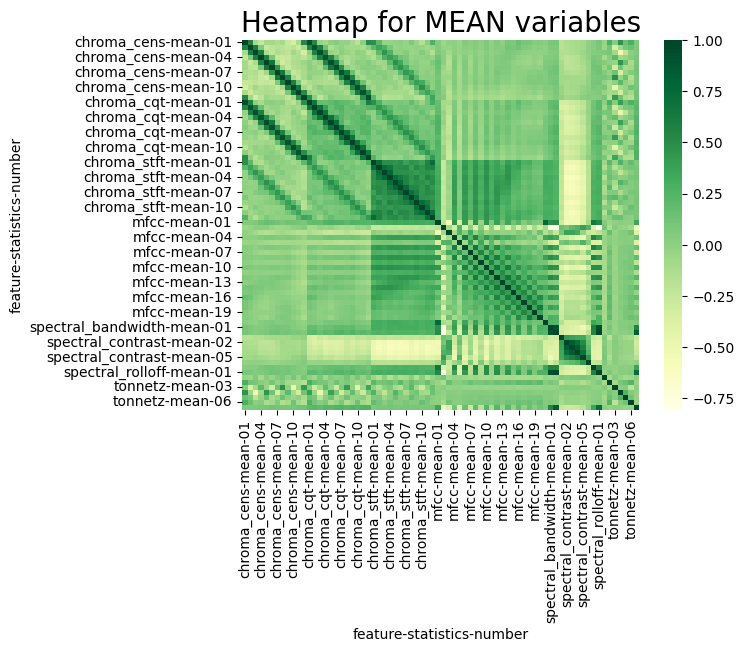

In [7]:
spike_cols = [col for col in X.columns if 'mean' in col] 
sns.heatmap(X[spike_cols].corr(), cmap='YlGn') 

plt.title('Heatmap for MEAN variables', fontsize = 20) 
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10);
plt.show()

Nel'heatmap si possono notare dei blocchi di colore omogeneo. Quelli centrati sulla diagonale mettono in evidenza un'osservazione che ci saremmo potuti immaginare anche senza mappa: le stesse misurazioni fatte con parametri diversi (per esempio chroma_stft_10, chroma_stft_07...) sono altamente correlate tra di loro. Osserviamo però che blocchi omogenei sono presenti anche lontani dalla diagonale, questi mettono in evidenza della correlazione anche tra metriche diverse! Queste correlazioni possono essere sfruttate per ridurre la dimensionalità.

## Feature Selection

Come prima cosa dividiamo il dataset in training e test set. Facciamo questa operazione perchè tutti i passaggi della Feature Selection verranno effettuati sul training set per vari motivi:
1. **Eviti il data leakage** → Se scegli le feature guardando tutto il dataset, usi informazioni dal test set che il modello non dovrebbe conoscere in fase di addestramento.  
2. **Mantieni la generalizzabilità** → La feature selection dovrebbe riflettere solo ciò che il modello vede durante il training, proprio come avviene nel mondo reale.  
3. **Migliori la valutazione del modello** → Se la selezione delle feature è fatta solo sul training set, il test set rimane un vero insieme di dati non visti.  


In [15]:
def split_dataset(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.3, random_state: int = 42) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train, test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return train, test, y_train, y_test


In [16]:
# split dataset into training and test
X_train, X_test, y_train, y_test = split_dataset(X,y,test_size=0.2,random_state=42)

# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

Per fare Feature Selection abbiamo usato due metodi:
1. **Mutual Information**: permette di selezionare le $k_1$ feature più rilevanti basandosi sulla Mutual Information. La Mutual Information (MI) misura quanto una feature contiene informazioni sulla variabile target; se la MI è alta, la feature è informativa per la previsione; se MI è vicina a zero, la feature è irrilevante.
2. **Correlazione**: Se due feature sono altamente correlate, una delle due è ridondante. Se la feature è debolmente correlata con il target, potrebbe essere poco utile.

Allora, nel blocco di codice successivo facciamo un'analisi preliminare per individuare il valore $k_1^*$ attraverso lo **Scree Plot**. Lo Scree Plot ordina le feature in base alla loro MI e mostra il contributo di ciascuna. **Obiettivo**: individuare il punto di gomito ("elbow point"), cioè il punto oltre il quale l'aggiunta di feature porta pochi benefici.

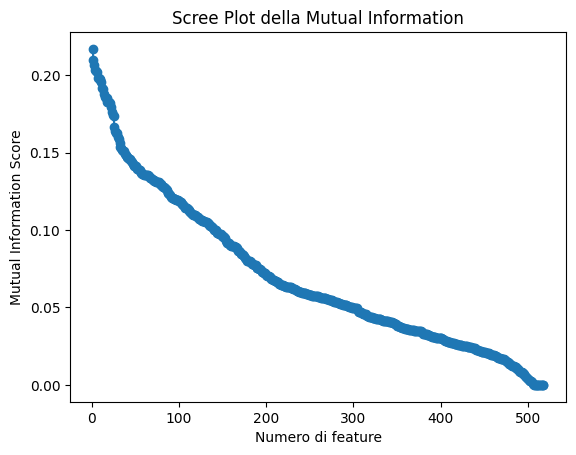

In [27]:
from sklearn.feature_selection import mutual_info_classif

# Calcola il punteggio MI per ogni feature
mi_scores = mutual_info_classif(X_train, y_train)
mi_scores_sorted = np.sort(mi_scores)[::-1]  # Ordina in ordine decrescente

# Plot della distribuzione dei punteggi MI
plt.plot(range(1, len(mi_scores_sorted) + 1), mi_scores_sorted, marker='o')
plt.xlabel("Numero di feature")
plt.ylabel("Mutual Information Score")
plt.title("Scree Plot della Mutual Information")
plt.show()

Allora scegliamo $k_1^*$ come il punto in cui la derivata seconda dello Scree Plot è massimo

In [28]:
second_derivative = np.diff(np.diff(mi_scores_sorted))

# Trova il punto con la massima curvatura
k_optimal = np.argmax(second_derivative) + 2  # +2 per compensare il doppio differenziamento
print(f"Numero ottimale di feature: {k_optimal}")

Numero ottimale di feature: 26


Otteniamo così $k_1^*$ = 26. Tuttavia, visto che la nostra pipeline di feature selection non è isolata al metodo di Mutual Information e che il $k_1^*$ ottenuto è abbastanza piccolo rispetto al numero totale di feature, scegliamo di restare "conservativi" e poniamo $k_1 = 4k_1^*$ = 104.

Eseguiamo ora la feature selection basata su mutual information, il blocco seguente mostra l'elenco delle feature selezionate.

In [29]:
# Seleziona le k migliori feature
k = 4 * k_optimal
selector = SelectKBest(mutual_info_classif, k=k) # 3*k_optimal
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Otteniamo i nomi delle feature originali
selected_features = X.columns[selector.get_support()]
print(f"Feature selezionate con Mutual Information ({len(selected_features)} totali):")
print(selected_features)

Feature selezionate con Mutual Information (104 totali):
MultiIndex([(      'chroma_stft',     'mean', '04'),
            (      'chroma_stft',   'median', '01'),
            (      'chroma_stft',   'median', '02'),
            (      'chroma_stft',   'median', '03'),
            (      'chroma_stft',   'median', '04'),
            (      'chroma_stft',   'median', '05'),
            (      'chroma_stft',   'median', '06'),
            (      'chroma_stft',   'median', '07'),
            (      'chroma_stft',   'median', '08'),
            (      'chroma_stft',   'median', '09'),
            ...
            ('spectral_contrast',      'std', '07'),
            ( 'spectral_rolloff', 'kurtosis', '01'),
            ( 'spectral_rolloff',     'mean', '01'),
            ( 'spectral_rolloff',   'median', '01'),
            ( 'spectral_rolloff',      'min', '01'),
            ( 'spectral_rolloff',     'skew', '01'),
            ( 'spectral_rolloff',      'std', '01'),
            (          'to

Procediamo ora con l'analisi della correlazione. In questo blocco andiamo a rimuovere le feature altamente correlate tra loro (con soglia > 0.9).

In [30]:
X_df = pd.DataFrame(X_train)

# Calcoliamo la matrice di correlazione
corr_matrix = X_df.corr().abs()

# Troviamo feature altamente correlate
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Rimuoviamo le feature ridondanti
X_train = X_df.drop(columns=to_drop)
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(columns=to_drop)

In [31]:
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-0.92273583, -1.19828236, -0.35424445, ...,  0.85078115,
         0.97098538, -0.66596605],
       [-1.52944347, -2.16788118, -2.56010244, ...,  1.44752092,
        -0.53090335, -0.51858924],
       [-0.41060547, -1.47608752, -1.08959433, ...,  1.37910972,
         0.06985214, -0.82149786],
       ...,
       [-0.08512185, -0.52778724, -0.17835556, ...,  0.12165488,
         0.87085947, -0.92126283],
       [-0.01924685, -0.05226387, -0.87230618, ...,  1.34393758,
        -0.53090335, -1.01918792],
       [-1.62432574, -1.28790487, -1.55623601, ...,  2.88877414,
         0.77073355, -0.91257735]])

Abbiamo quindi che le feature selezionate sono le seguenti

In [32]:
selected_features = X.columns[X_train.columns]
print(f"Feature selezionate con Mutual Information ({len(selected_features)} totali):")
print(selected_features)

Feature selezionate con Mutual Information (78 totali):
MultiIndex([('chroma_cens', 'kurtosis', '01'),
            ('chroma_cens', 'kurtosis', '02'),
            ('chroma_cens', 'kurtosis', '03'),
            ('chroma_cens', 'kurtosis', '04'),
            ('chroma_cens', 'kurtosis', '06'),
            ('chroma_cens', 'kurtosis', '07'),
            ('chroma_cens', 'kurtosis', '08'),
            ('chroma_cens', 'kurtosis', '09'),
            ('chroma_cens', 'kurtosis', '10'),
            ('chroma_cens', 'kurtosis', '11'),
            ('chroma_cens', 'kurtosis', '12'),
            ('chroma_cens',      'max', '01'),
            ('chroma_cens',      'max', '04'),
            ('chroma_cens',      'max', '05'),
            ('chroma_cens',      'max', '06'),
            ('chroma_cens',      'max', '07'),
            ('chroma_cens',      'max', '08'),
            ('chroma_cens',      'max', '09'),
            ('chroma_cens',      'max', '10'),
            ('chroma_cens',      'max', '11'),
    

In [17]:
# X_train.to_csv("./X_train_featsel.csv", index=False)
# X_test.to_csv("./X_test_featsel.csv", index=False)
X_train = pd.read_csv('./X_train_featsel.csv')
X_test = pd.read_csv('./X_test_featsel.csv')

## Selezione delle feature più rilevanti

Successivamente, abbiamo applicato la **PCA (Principal Component Analysis)** per ridurre la dimensionalità del dataset. Questa tecnica ci ha permesso di comprimere le informazioni contenute nelle feature originali in un numero inferiore di componenti principali, preservando la maggior parte della varianza nei dati. La riduzione della dimensionalità è stata utile per semplificare il modello, migliorare l'efficienza computazionale e, in alcuni casi, ridurre il rischio di overfitting.

Il grafico sotto mostra che il 90% varianza del dataset è catturata da meno di 150 componenti.

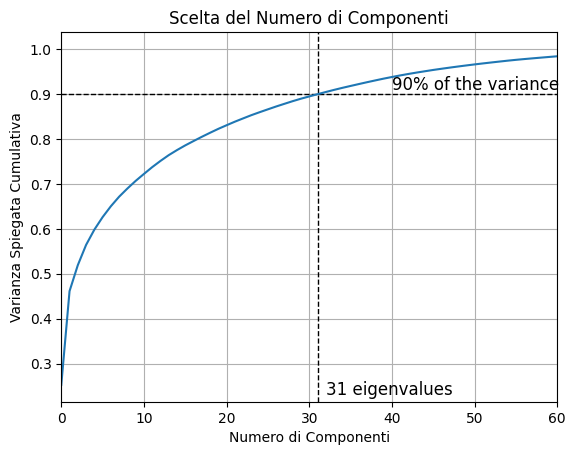

In [9]:
pca = PCA().fit(X_train)  # PCA senza specificare componenti

cumsum = np.cumsum(pca.explained_variance_ratio_)
idx = np.argmin(np.abs(cumsum - cumsum[-1]*.90))

# plot the eigenvalues horizontal line that represents the 95% of the variance
plt.axhline(cumsum[idx], color='black', linestyle='--', linewidth=1)
plt.text(40, cumsum[idx]+0.01, '90% of the variance', fontsize=12)

# plot the eigenvalues vertical line that represents the number of eigenvalues that represents the 95% of the variance
plt.axvline(idx, color='black', linestyle='--', linewidth=1)
plt.text(idx+1, 0.23, f'{idx} eigenvalues', fontsize=12)

plt.xlim(0, 60)
plt.plot(cumsum)
plt.xlabel("Numero di Componenti")
plt.ylabel("Varianza Spiegata Cumulativa")
plt.title("Scelta del Numero di Componenti")
plt.grid()
plt.show()

Allora durante l'analisi dei modelli verrà considerato il dataset in tre forme:

- forma originale;
- proiettato nel sottospazio generato dagli autovettori associati ai primi 31 autovalori (90% della varianza del dataset);
- proiettato nel sottospazio generato dagli autovettori associati ai primi 12 autovalori (75% della varianza del dataset);

In [10]:
print("Forma originale:", X_train.shape)
percent = [.90, .75]

X_trains = []
X_tests = []

X_trains.append(X_train)
X_tests.append(X_test)

for p in percent:
    d = np.argmin(np.abs(cumsum - cumsum[-1]*p))
    pca = PCA(n_components=d)
    pca.fit(X_train)
    X_trains.append(pd.DataFrame(pca.transform(X_train)))
    X_tests.append(pd.DataFrame(pca.transform(X_test)))

for x in X_trains[1:]:
    print("Dopo PCA", x.shape)

Forma originale: (19983, 78)
Dopo PCA (19983, 31)
Dopo PCA (19983, 12)


Vediamo ora quali sono le feature che abbiamo selezionato e "quanta" varianza spiegano.

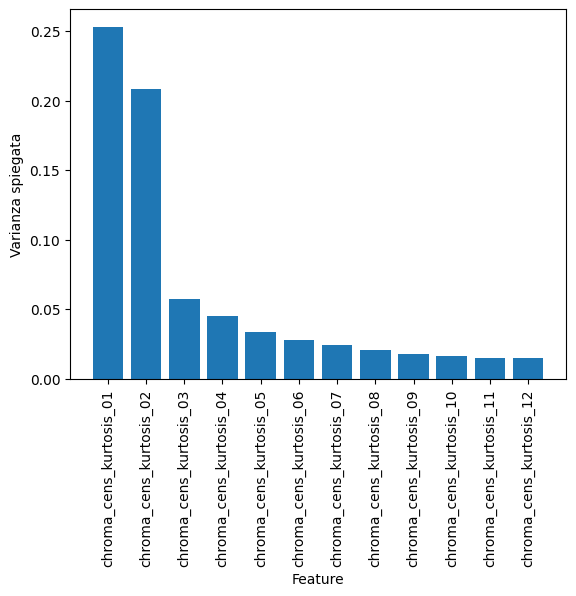

In [13]:
col_names = [name+"_"+stat+"_"+parameter for (name, stat, parameter) in X.columns]

important_features = np.abs(pca.components_[0])  # Prendi il valore assoluto della prima componente
feature_importance = list(zip(col_names, pca.explained_variance_ratio_))
feature_importance.sort(key=lambda x: x[1], reverse=True)  # Ordina per importanza
pca_feature_importance = feature_importance[:20]
pca_feature_importance_keys = [feature for (feature, value) in pca_feature_importance]
pca_feature_importance_value = [value for (feature, value) in pca_feature_importance]

fig, ax = plt.subplots()

# Creazione del bar chart
ax.bar(pca_feature_importance_keys ,pca_feature_importance_value)

# Aggiungere etichette e titolo
ax.set_xlabel('Feature')
ax.set_ylabel('Varianza spiegata')
plt.xticks(rotation=90)

# Mostrare il grafico
plt.show()

# Modelli
Per affrontare il compito di classificazione del genere musicale sul dataset **FMA (Free Music Archive)**, sono stati testati diversi modelli di machine learning al fine di confrontarne le performance e identificare l'approccio più efficace. Ogni modello scelto rappresenta una tecnica classica o avanzata di classificazione, in grado di gestire il tipo di dati e le feature pre-estratte dal dataset.

I modelli implementati comprendono:

- **Support Vector Machine (SVM)**
- **Decision Tree**
- **Bagging**
- **Boosting**
- **Rete Neurale**
- **Softmax Regression**
- **Gaussian Discriminant Analysis (GDA)**
- **k-Nearest Neighbors (kNN)**

Questi modelli sono stati scelti per sfruttare diversi approcci al machine learning, esplorando tanto metodi parametrici quanto non-parametrici.

Per ogni modello che sperimentiamo riportiamo la matrice di confusione e le metriche più importanti (Guarda cella sotto).

Le definizione delle metriche che abbiamo analizzato sono riportate qui:

### Metriche di valutazione

$$
\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
$$

$$
\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
$$

$$
\text{F1-score}_i = 2 \cdot \frac{\text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
$$

### Medie delle metriche

$$
\text{Macro Precision} = \frac{1}{N} \sum_{i=1}^{N} \text{Precision}_i
$$

$$
\text{Macro Recall} = \frac{1}{N} \sum_{i=1}^{N} \text{Recall}_i
$$

$$
\text{Macro F1-score} = \frac{1}{N} \sum_{i=1}^{N} \text{F1-score}_i
$$

**Weighted Average**  
(calcolata pesando ogni classe in base alla sua frequenza):

$$
\text{Weighted Precision} = \sum_{i=1}^{N} w_i \cdot \text{Precision}_i
$$

$$
\text{Weighted Recall} = \sum_{i=1}^{N} w_i \cdot \text{Recall}_i
$$

$$
\text{Weighted F1-score} = \sum_{i=1}^{N} w_i \cdot \text{F1-score}_i
$$

Dove:
- \( TP_i \) = True Positives per la classe \( i \)
- \( FP_i \) = False Positives per la classe \( i \)
- \( FN_i \) = False Negatives per la classe \( i \)
- \( N \) è il numero di classi
- \( w_i \) è il peso della classe \( i \), definito come la proporzione di campioni appartenenti a quella classe rispetto al totale.





In [11]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test, title = 'Confusion matrix'):
    y_pred = clf.predict(x_test)
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title=title)    
    print(classification_report(y_test, y_pred))


In [12]:
import joblib

# model dir
MODEL_DIR = os.path.join(os.getcwd(), 'models')

def save_model(model, filename):
    model_path = os.path.join(MODEL_DIR, filename)
    with open(model_path, 'wb') as f:
        joblib.dump(model, f, protocol=5)
        
def load_model(filename):
    model_path = os.path.join(MODEL_DIR, filename)
    with open(model_path, 'rb') as f:
        return joblib.load(f)

# Support Vector Machine for classification

Il primo modello che abbiamo utilizzato è la **Support Vector Machine** appositamente adattata per i task di classificazione. Per questo modello abbiamo svolto prima una hyperparameter selection *incrementale*, nel senso che abbiamo fatto variare un solo parametro tenendo gli altri fissati, uno dopo l'altro, e abbiamo selezionato il migliore. Poi, su un set di hyperparametri limitati abbiamo eseguito una gridsearch per la scelta "esaustiva" dei parametri migliori.

In [16]:
def svm(
    X_train, y_train, X_test, y_test,
    title: str = 'SVM',
    kernel: str = 'rbf',
    degree: int = 3,
    C: float = 1.0,
    gamma : Union[float, str] = 'scale'):

    # create the model
    model = sklearn.svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree)

    # train the model
    model.fit(X_train, y_train)
    valuate(model, X_test, y_test, title=title)

Iniziamo ora la ricerca incrementale degli iperparametri. Procederemo in questo ordine: i) kernel ii) C (penalty) iii) Gamma

### Learn best kernel

In [86]:
X_train, X_test = X_trains[1], X_tests[1]

kernels = ['rbf', 'linear', 'poly', 'sigmoid']

# Liste per raccogliere le metriche
accuracy_results, f1_results = list(), list()
scoring = ['accuracy', 'f1_weighted']

for k in kernels:
    model = sklearn.svm.SVC(kernel=k)
    scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"kernel={k}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

kernel=rbf: Accuracy=0.6358, F1_weighted=0.6013
kernel=linear: Accuracy=0.5916, F1_weighted=0.5475
kernel=poly: Accuracy=0.5822, F1_weighted=0.5309
kernel=sigmoid: Accuracy=0.4279, F1_weighted=0.3964


La funzione kernel *Radial Basis Function* (RBF) ha la caratteristica peculiare di far aumentare la distanza dagli altri punti in modo esponenziale.

In [87]:
# find best kernel
best_kernel = kernels[np.argmax(accuracy_results)]
print(f'Best max depth: {best_kernel}')
print(f'Best accuracy: {max(accuracy_results)}')

Best max depth: rbf
Best accuracy: 0.6358396665800369


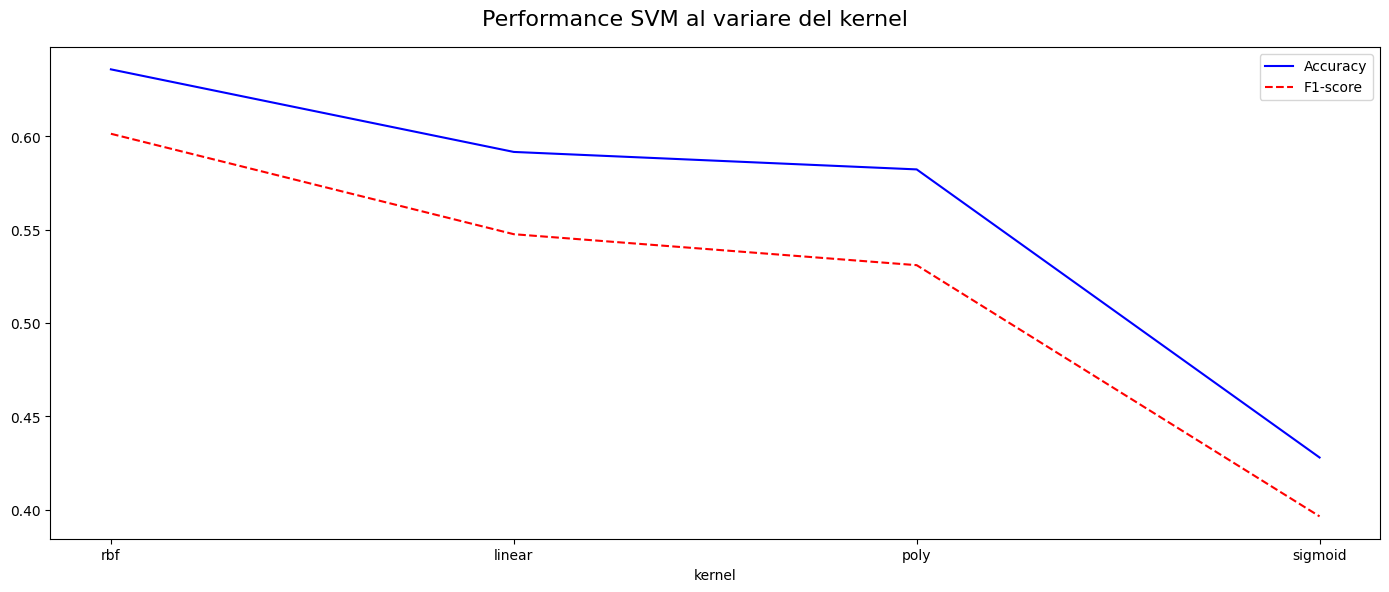

In [88]:
# Plot performance
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fig.suptitle('Performance SVM al variare del kernel', fontsize=16)

ax.plot(kernels, accuracy_results, linestyle='-', label="Accuracy", color='b')
ax.plot(kernels, f1_results, linestyle='--', label="F1-score", color='r')

ax.set_xlabel("kernel")
ax.legend()

plt.tight_layout()
plt.show()

### Learn best C

In [35]:
X_train, X_test = X_trains[1], X_tests[1]

c_range = np.logspace(-2, 3, 5)

# Liste per raccogliere le metriche
accuracy_results, f1_results = [], []
scoring = ['accuracy', 'f1_weighted']

for c in c_range:
    model = sklearn.svm.SVC(kernel="rbf", gamma='scale', C=c)
    scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"c={c}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

c=0.01: Accuracy=0.4787, F1_weighted=0.3557
c=0.1778279410038923: Accuracy=0.6088, F1_weighted=0.5655
c=3.1622776601683795: Accuracy=0.6453, F1_weighted=0.6166
c=56.23413251903491: Accuracy=0.6190, F1_weighted=0.6089
c=1000.0: Accuracy=0.6015, F1_weighted=0.5965


In [36]:
# find best c (rbf kernel)
best_c = c_range[np.argmax(accuracy_results)]
print(f'Best c: {best_c}')
print(f'Best accuracy: {max(accuracy_results)}')

Best c: 3.1622776601683795
Best accuracy: 0.6452974735616056


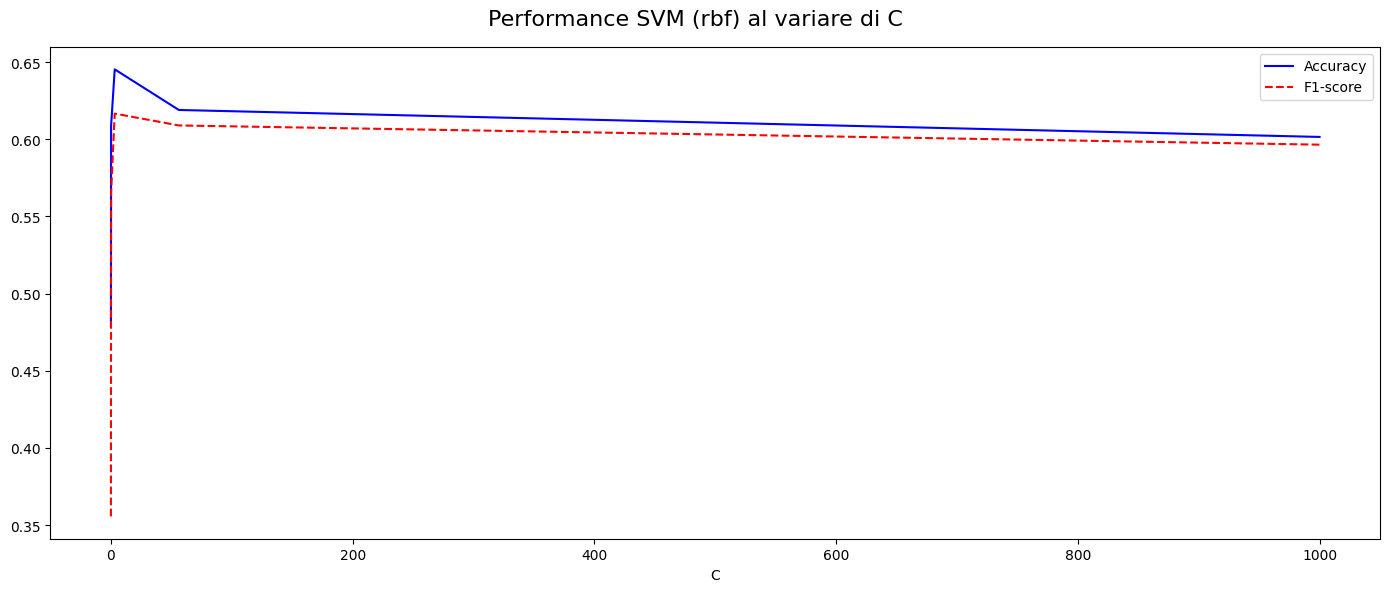

In [37]:
# Plot performance
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fig.suptitle('Performance SVM (rbf) al variare di C', fontsize=16)

ax.plot(c_range, accuracy_results, linestyle='-', label="Accuracy", color='b')
ax.plot(c_range, f1_results, linestyle='--', label="F1-score", color='r')

ax.set_xlabel("C")
ax.legend()

plt.tight_layout()
plt.show()

### Learn best gamma

In [39]:
X_train, X_test = X_trains[1], X_tests[1]

gamma_range = np.logspace(-5, -1, 7)

# Liste per raccogliere le metriche
accuracy_results, f1_results = list(), list()
scoring = ['accuracy', 'f1_weighted']

for gamma in gamma_range:
    sklearn.svm.SVC(kernel="rbf", gamma=gamma, C=best_c)
    scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"gamma={gamma}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

gamma=1e-05: Accuracy=0.6015, F1_weighted=0.5965
gamma=4.641588833612782e-05: Accuracy=0.6015, F1_weighted=0.5965
gamma=0.00021544346900318823: Accuracy=0.6015, F1_weighted=0.5965
gamma=0.001: Accuracy=0.6015, F1_weighted=0.5965
gamma=0.004641588833612777: Accuracy=0.6015, F1_weighted=0.5965
gamma=0.021544346900318822: Accuracy=0.6015, F1_weighted=0.5965
gamma=0.1: Accuracy=0.6015, F1_weighted=0.5965


In [40]:
# find best gamma (rbf kernel)
best_gamma = gamma_range[np.argmax(accuracy_results)]
print(f'Best gamma: {best_gamma}')
print(f'Best accuracy: {max(accuracy_results)}')

Best gamma: 1e-05
Best accuracy: 0.6015106151674435


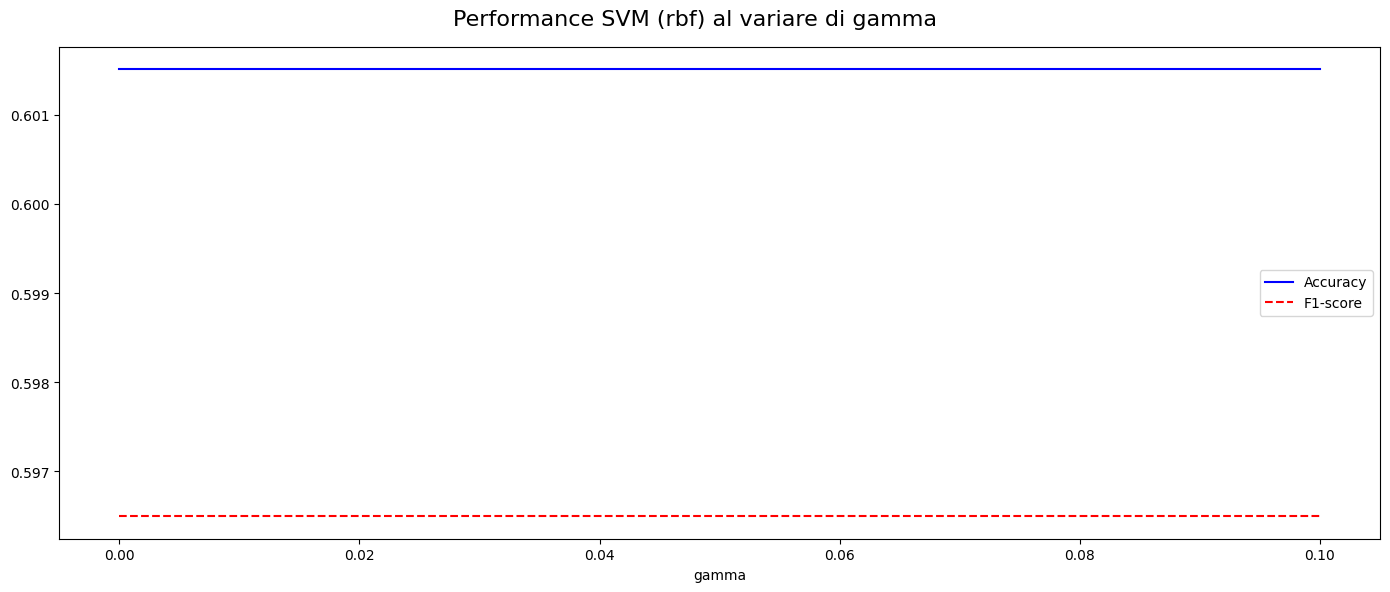

In [41]:
# Plot performance
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fig.suptitle('Performance SVM (rbf) al variare di gamma', fontsize=16)

ax.plot(gamma_range, accuracy_results, linestyle='-', label="Accuracy", color='b')
ax.plot(gamma_range, f1_results, linestyle='--', label="F1-score", color='r')

ax.set_xlabel("gamma")
ax.legend()

plt.tight_layout()
plt.show()

Otteniamo cosi che un buon set di iperparametri è <kernel = rbf, C = 3.16, Gamma = 0.022>. Eseguiamo ora una GridSearch per trovare un insieme di parametri migliore.

### GridSearchCV SVM

In [45]:
model = skl.svm.SVC()

param_grid = {
    'C': np.logspace(-2, 3, 5),          # Parametro di regolarizzazione
    'kernel': ['rbf'],    # Tipo di kernel
    'gamma': np.logspace(-5, -1, 7),  # Coefficiente del kernel (solo per kernel 'rbf')
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=8)

grid_search.fit(X_trains[1], y_train.values.ravel())

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_tests[1], y_test)
print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

Migliori parametri: {'C': np.float64(3.1622776601683795), 'gamma': np.float64(0.021544346900318822), 'kernel': 'rbf'}
Accuracy del modello ottimizzato: 0.644515612489992


Vediamo così che il miglior set di parametri nel range considerato è <kernel=rbf, C=3.16, gamma=0.021...>, che è identico a quello trovato usando un approccio incrementale.

## Valuate best model

Confrontiamo ora l'andamendo del modello con il miglior set di iperparametri rispetto ai dataset che spiegano il 75%, 90% e il 100% della varianza.

                     precision    recall  f1-score   support

              blues       1.00      0.22      0.36        18
          classical       0.77      0.85      0.81       129
            country       0.90      0.30      0.45        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.66      0.80      0.73      1264
       experimental       0.45      0.43      0.44       447
               folk       0.67      0.68      0.67       318
            hip-hop       0.70      0.59      0.64       438
       instrumental       0.54      0.38      0.45       284
      international       0.72      0.56      0.63       199
               jazz       0.65      0.35      0.46        88
old-time / historic       0.94      0.93      0.93        96
                pop       0.42      0.14      0.21       222
               rock       0.74      0.85      0.79      1393
           soul-rnb       1.00      0.17      0.29        35
             spoken    

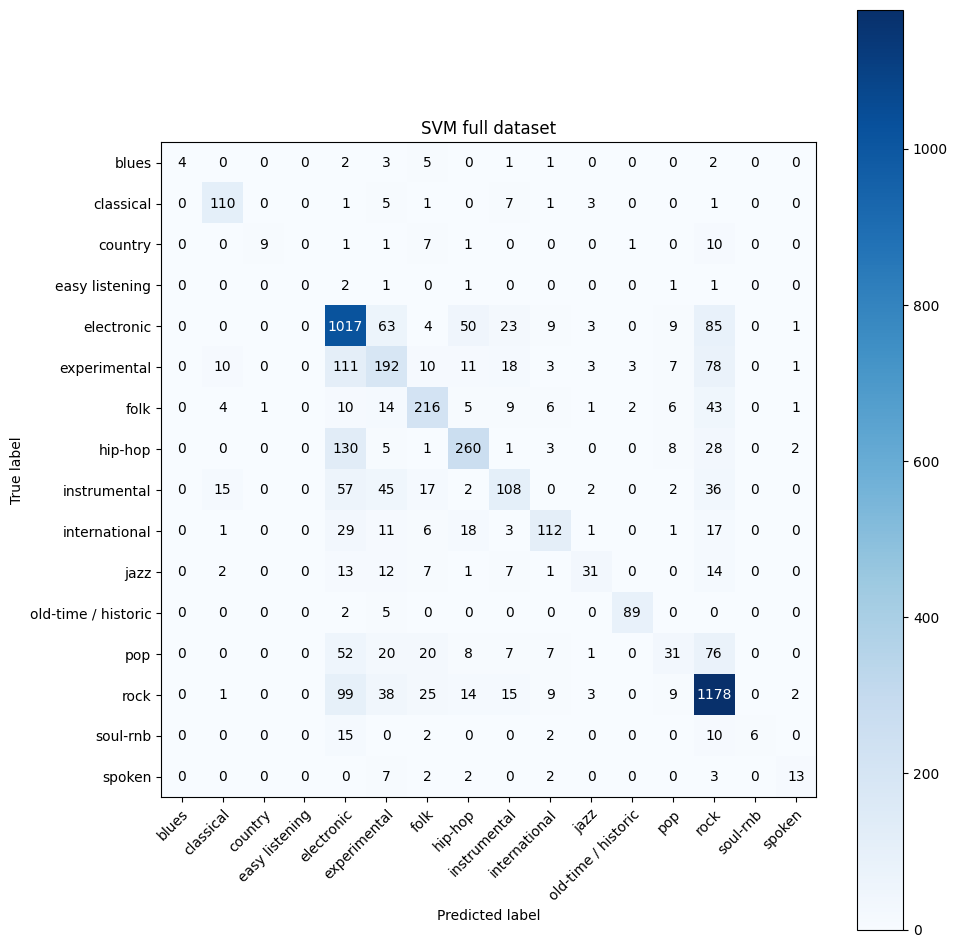

In [17]:
svm(X_trains[0], y_train, X_tests[0], y_test, C=np.float64(3.1622776601683795), gamma=np.float64(0.021544346900318822), title="SVM full dataset")

                     precision    recall  f1-score   support

              blues       1.00      0.11      0.20        18
          classical       0.71      0.85      0.77       129
            country       0.71      0.17      0.27        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.63      0.76      0.69      1264
       experimental       0.47      0.42      0.45       447
               folk       0.61      0.64      0.62       318
            hip-hop       0.63      0.55      0.59       438
       instrumental       0.50      0.36      0.42       284
      international       0.69      0.48      0.57       199
               jazz       0.67      0.25      0.36        88
old-time / historic       0.93      0.93      0.93        96
                pop       0.29      0.07      0.12       222
               rock       0.72      0.84      0.77      1393
           soul-rnb       1.00      0.09      0.16        35
             spoken    

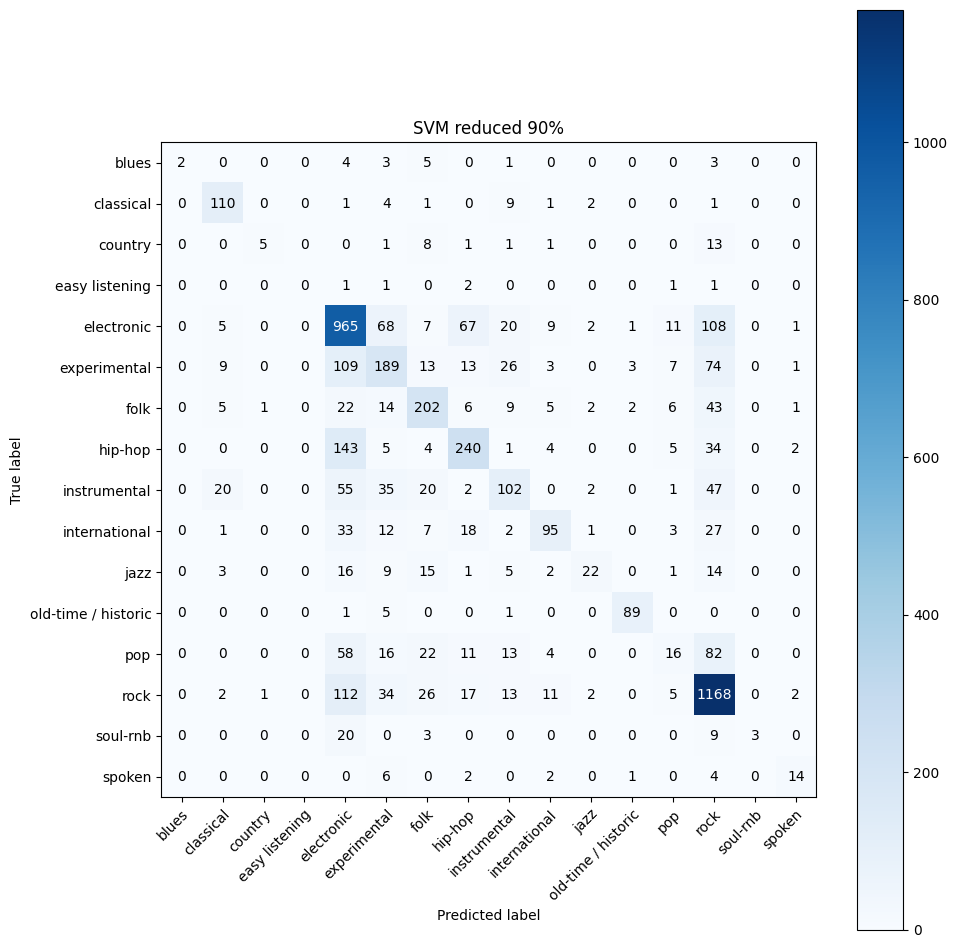

In [18]:
svm(X_trains[1], y_train, X_tests[1], y_test, C=np.float64(3.1622776601683795), gamma=np.float64(0.021544346900318822), title="SVM reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.63      0.72      0.67       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.58      0.76      0.66      1264
       experimental       0.41      0.30      0.34       447
               folk       0.52      0.58      0.55       318
            hip-hop       0.57      0.43      0.49       438
       instrumental       0.45      0.32      0.37       284
      international       0.66      0.34      0.45       199
               jazz       0.44      0.08      0.13        88
old-time / historic       0.88      0.93      0.90        96
                pop       0.30      0.01      0.03       222
               rock       0.65      0.82      0.73      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

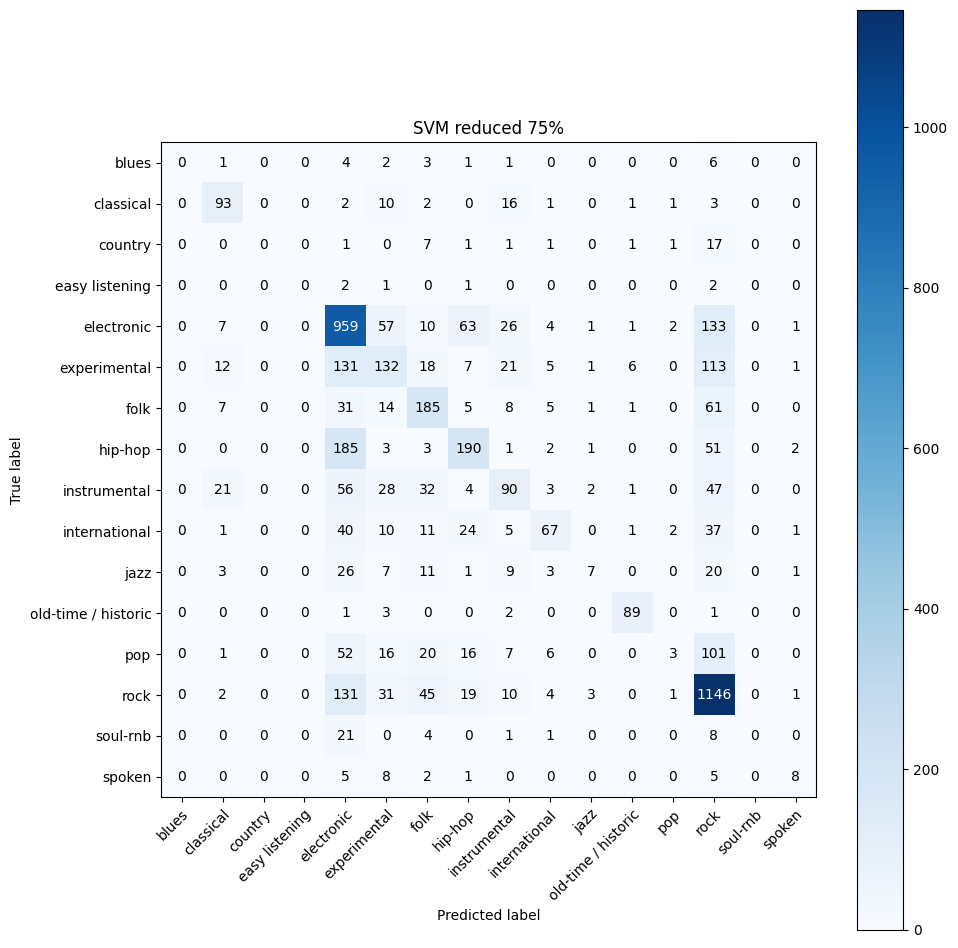

In [19]:
svm(X_trains[2], y_train, X_tests[2], y_test, C=np.float64(3.1622776601683795), gamma=np.float64(0.021544346900318822), title="SVM reduced 75%")

# Tree-based models

In questa sezione esploriamo i modelli basati su strutture ad albero:
- Decision Tree
- Bagging
- Random Forest
- AdaBoost
- XGBoost

Per ogni modello effettuiamo una selezione dei parametri incrementale (inizialmente consideriamo i parametri di default) mentre dopo effettuiamo una grid-search. Infine, confrontiamo i parametri ottenuti con i due metodi per valutare l'inter-dipendenza di questi.

## Decision Tree

In [20]:
def tree_clf(X_train, y_train, X_test, y_test, criterion = 'gini', max_depth = 10, min_samples_split = 2, min_samples_leaf = 1, title: str = 'Decision Tree'):

    # create the model
    model = tree.DecisionTreeClassifier(class_weight='balanced', criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf=min_samples_leaf)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

Iniziamo con la selezione incrementale dei parametri

### Learn criterion

In [21]:
# select only one dataset
X_train, X_test = X_trains[1], X_tests[1]

criterion_set = ["gini", "entropy", "log_loss"]

# Liste per raccogliere le metriche
accuracy_results = []
f1_results = []

scoring = ['accuracy', 'f1_weighted']
for criterion in criterion_set:
    model = tree.DecisionTreeClassifier(criterion=criterion, splitter='best')
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"criterion={criterion}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

criterion=gini: Accuracy=0.4448, F1_weighted=0.4465
criterion=entropy: Accuracy=0.4398, F1_weighted=0.4420
criterion=log_loss: Accuracy=0.4419, F1_weighted=0.4442


### Learn max_depth

In [25]:
max_depth_range = np.linspace(1, 32, 32, endpoint=True).astype(int)

# Liste per raccogliere le metriche
accuracy_results = []
f1_results = []

scoring = ['accuracy', 'f1_weighted']
for n in max_depth_range:
    model = tree.DecisionTreeClassifier(max_depth=n, criterion='gini', splitter='best')
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"max_depth_range={n}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

max_depth_range=1: Accuracy=0.4293, F1_weighted=0.3029
max_depth_range=2: Accuracy=0.4359, F1_weighted=0.3284
max_depth_range=3: Accuracy=0.4586, F1_weighted=0.3705
max_depth_range=4: Accuracy=0.4844, F1_weighted=0.4276
max_depth_range=5: Accuracy=0.5060, F1_weighted=0.4574
max_depth_range=6: Accuracy=0.5188, F1_weighted=0.4688
max_depth_range=7: Accuracy=0.5254, F1_weighted=0.4790
max_depth_range=8: Accuracy=0.5267, F1_weighted=0.4822
max_depth_range=9: Accuracy=0.5235, F1_weighted=0.4850
max_depth_range=10: Accuracy=0.5172, F1_weighted=0.4854
max_depth_range=11: Accuracy=0.5096, F1_weighted=0.4827
max_depth_range=12: Accuracy=0.5003, F1_weighted=0.4798
max_depth_range=13: Accuracy=0.4940, F1_weighted=0.4774
max_depth_range=14: Accuracy=0.4830, F1_weighted=0.4711
max_depth_range=15: Accuracy=0.4768, F1_weighted=0.4672
max_depth_range=16: Accuracy=0.4703, F1_weighted=0.4629
max_depth_range=17: Accuracy=0.4677, F1_weighted=0.4627
max_depth_range=18: Accuracy=0.4625, F1_weighted=0.4589
m

In [25]:
# find the best max depth
best_max_depth = max_depth_range[np.argmax(accuracy_results)]
print(f'Best max depth: {best_max_depth}')
print(f'Best accuracy: {max(accuracy_results)}')

Best max depth: 8
Best accuracy: 0.5264465065365516


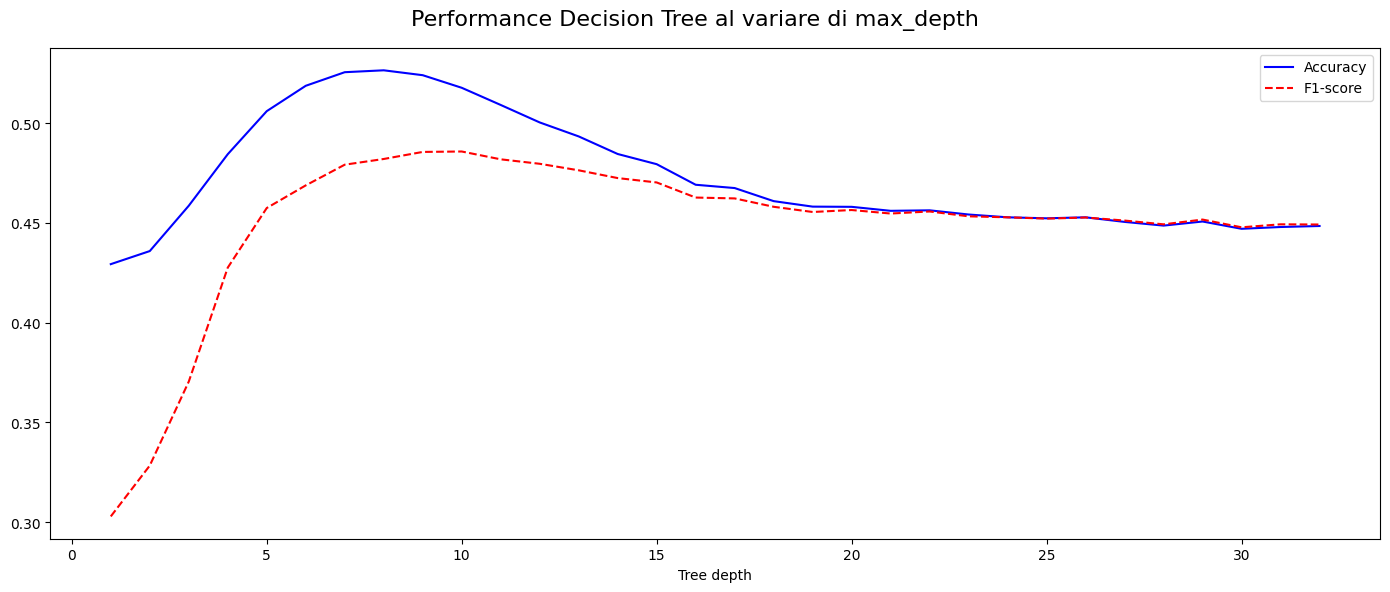

In [26]:
# Plot performance
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fig.suptitle('Performance Decision Tree al variare di max_depth', fontsize=16)

ax.plot(max_depth_range, accuracy_results, linestyle='-', label="Accuracy", color='b')
ax.plot(max_depth_range, f1_results, linestyle='--', label="F1-score", color='r')

ax.set_xlabel("Tree depth")
ax.legend()

plt.tight_layout()
plt.show()

### Learn min_samples_split

In [27]:
# select only one dataset
X_train, X_test = X_trains[1], X_tests[1]

min_samples_split_range = np.linspace(0.01, 1.0, 20, endpoint=True)

# Liste per raccogliere le metriche
accuracy_results = []
f1_results = []

scoring = ['accuracy', 'f1_weighted']
for min_samples_split in min_samples_split_range:
    model = tree.DecisionTreeClassifier(max_depth=best_max_depth, criterion='gini', splitter='best', min_samples_split=min_samples_split)
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"min_samples_split={min_samples_split}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

min_samples_split=0.01: Accuracy=0.5254, F1_weighted=0.4821
min_samples_split=0.06210526315789474: Accuracy=0.5009, F1_weighted=0.4370
min_samples_split=0.11421052631578947: Accuracy=0.4713, F1_weighted=0.4076
min_samples_split=0.16631578947368422: Accuracy=0.4510, F1_weighted=0.3576
min_samples_split=0.21842105263157896: Accuracy=0.4403, F1_weighted=0.3333
min_samples_split=0.2705263157894737: Accuracy=0.4403, F1_weighted=0.3333
min_samples_split=0.32263157894736844: Accuracy=0.4357, F1_weighted=0.3288
min_samples_split=0.37473684210526315: Accuracy=0.4359, F1_weighted=0.3284
min_samples_split=0.4268421052631579: Accuracy=0.4359, F1_weighted=0.3284
min_samples_split=0.4789473684210527: Accuracy=0.4301, F1_weighted=0.3056
min_samples_split=0.5310526315789474: Accuracy=0.4293, F1_weighted=0.3029
min_samples_split=0.5831578947368421: Accuracy=0.4293, F1_weighted=0.3029
min_samples_split=0.6352631578947369: Accuracy=0.4293, F1_weighted=0.3029
min_samples_split=0.6873684210526316: Accuracy

In [28]:
# find the best min samples split
best_min_samples_split = min_samples_split_range[np.argmax(accuracy_results)]
print(f'Best min samples split: {best_min_samples_split}')
print(f'Best accuracy: {max(accuracy_results)}')

Best min samples split: 0.01
Best accuracy: 0.5253958060111137


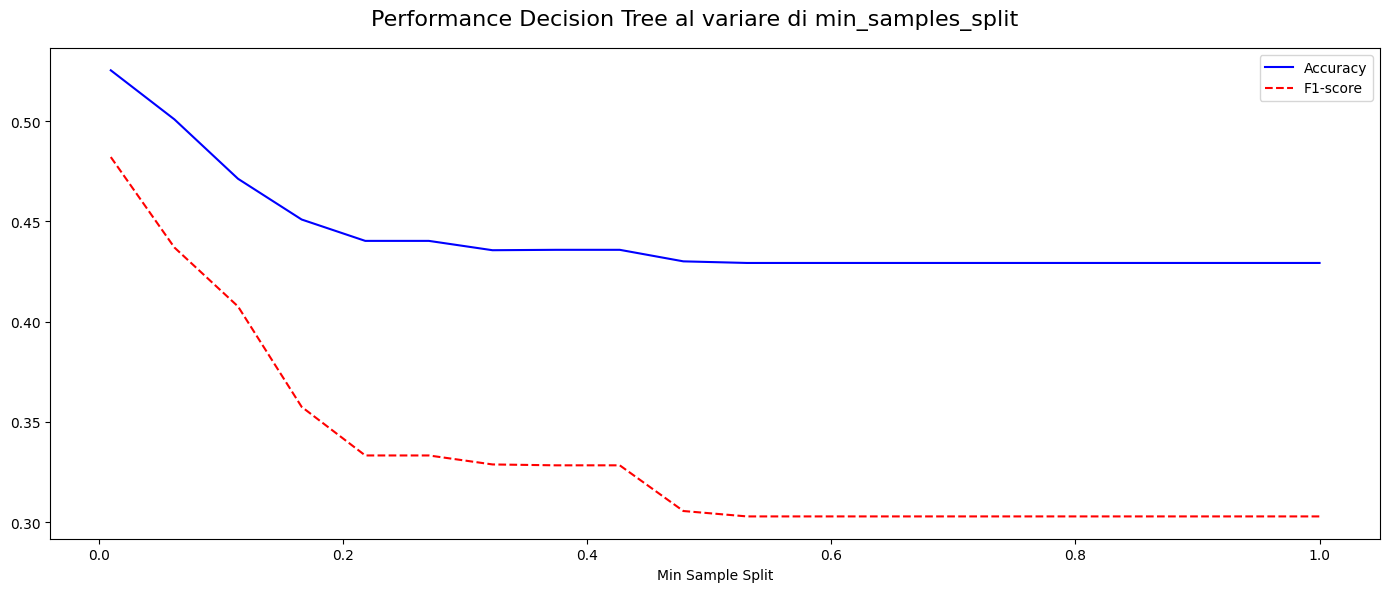

In [29]:
# Plot performance
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fig.suptitle('Performance Decision Tree al variare di min_samples_split', fontsize=16)

ax.plot(min_samples_split_range, accuracy_results, linestyle='-', label="Accuracy", color='b')
ax.plot(min_samples_split_range, f1_results, linestyle='--', label="F1-score", color='r')

ax.set_xlabel("Min Sample Split")
ax.legend()

plt.tight_layout()
plt.show()

### Learn min_samples_leaf

In [30]:
# select only one dataset
X_train, X_test = X_trains[1], X_tests[1]

min_samples_leaf_range = [1, 5, 10, 15, 20]

# Liste per raccogliere le metriche
accuracy_results = []
f1_results = []

scoring = ['accuracy', 'f1_weighted']
for min_samples_leaf in min_samples_leaf_range:
    model = tree.DecisionTreeClassifier(max_depth=best_max_depth, criterion='gini', splitter='best', min_samples_split=best_min_samples_split, min_samples_leaf=min_samples_leaf)
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"min_sample_leaf={min_samples_leaf}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

min_sample_leaf=1: Accuracy=0.5253, F1_weighted=0.4821
min_sample_leaf=5: Accuracy=0.5254, F1_weighted=0.4821
min_sample_leaf=10: Accuracy=0.5253, F1_weighted=0.4817
min_sample_leaf=15: Accuracy=0.5241, F1_weighted=0.4811
min_sample_leaf=20: Accuracy=0.5244, F1_weighted=0.4811


In [ ]:
# find the best "min_sample_leaf"
best_min_samples_leaf = min_samples_leaf_range[np.argmax(accuracy_results)]
print(f'Best min samples leaf: {best_min_samples_leaf}')
print(f'Best accuracy: {max(accuracy_results)}')

Best min samples split: 5
Best accuracy: 0.5254458560611637


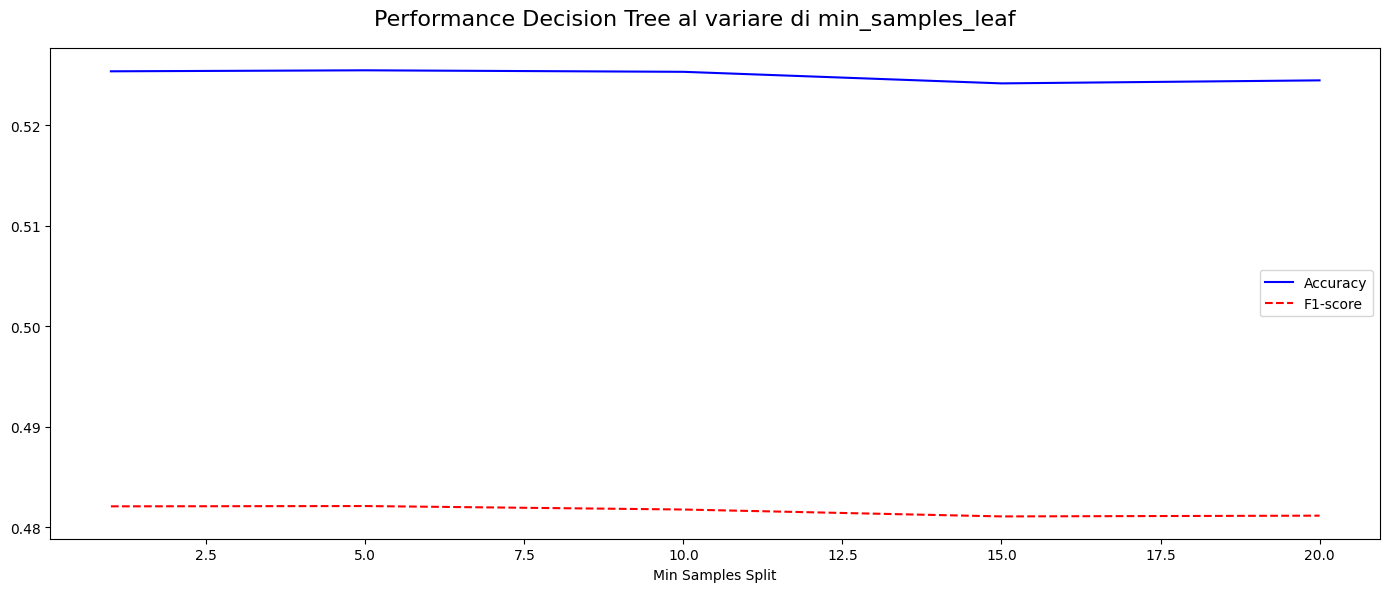

In [32]:
# Plot performance
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fig.suptitle('Performance Decision Tree al variare di min_samples_leaf', fontsize=16)

ax.plot(min_samples_leaf_range, accuracy_results, linestyle='-', label="Accuracy", color='b')
ax.plot(min_samples_leaf_range, f1_results, linestyle='--', label="F1-score", color='r')

ax.set_xlabel("Min Samples Split")
ax.legend()

plt.tight_layout()
plt.show()

### Learn max_features

In [ ]:
# select only one dataset
max_features_range = [None, 'sqrt', 'log2', 150]

# Liste per raccogliere le metriche
accuracy_results = []
f1_results = []

scoring = ['accuracy', 'f1_weighted']
for m in max_features_range:
    model = tree.DecisionTreeClassifier(max_depth=best_max_depth, \
                                        criterion='gini', splitter='best', \
                                        min_samples_split=best_min_samples_split, \
                                        min_samples_leaf=best_min_samples_leaf, max_features=m)
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"max_features={m}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

max_features=None: Accuracy=0.5254, F1_weighted=0.4821
max_features=sqrt: Accuracy=0.4623, F1_weighted=0.4091
max_features=log2: Accuracy=0.4562, F1_weighted=0.4015
max_features=150: Accuracy=0.5254, F1_weighted=0.4821


In [38]:
# find the best max feature
best_max_features_range = max_features_range[np.argmax(accuracy_results)]
print(f'Best max features: {best_max_features_range}')
print(f'Best accuracy: {max(accuracy_results)}')

Best max features: None
Best accuracy: 0.5254458560611637


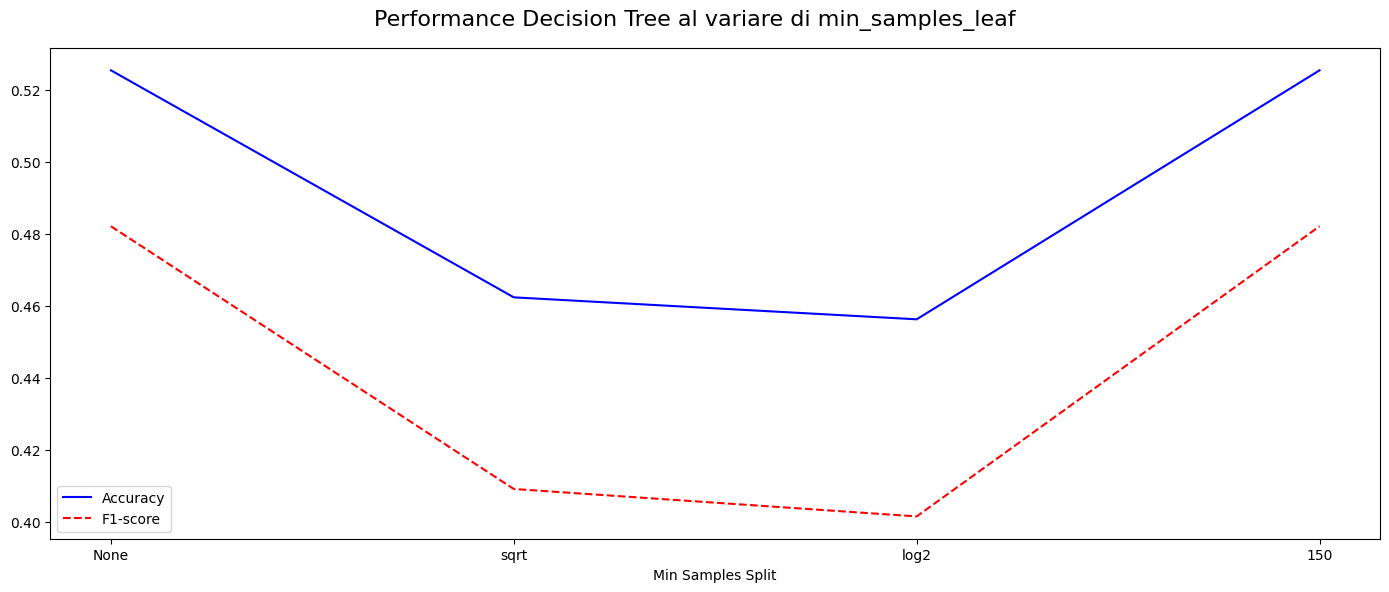

In [ ]:
# Plot performance
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fig.suptitle('Performance Decision Tree al variare di max_features', fontsize=16)

max_features_range = ['None', 'sqrt', 'log2', '150']

ax.plot(max_features_range, accuracy_results, linestyle='-', label="Accuracy", color='b')
ax.plot(max_features_range, f1_results, linestyle='--', label="F1-score", color='r')

ax.set_xlabel("max_features")
ax.legend()

plt.tight_layout()
plt.show()

Abbiamo quindi che la migliore combinazione individuata in questo modo è criterion=Gini, max_depth=8, min_sample_split=0.01, min_sample_leaf=5, max_features=None.

### GridSearchCV decision tree
Effettuiamo ora una grid search sui parametri visti sopra per trovare la loro migliore combinazione. 

In [39]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.linspace(1, 32, 32, endpoint=True).astype(int),
    'min_samples_split': np.linspace(0.01, 1.0, 20, endpoint=True),
    'min_samples_leaf': [1, 5, 10, 15, 20]
}

model = tree.DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = model, param_grid=param_grid, cv=5, n_jobs=8)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

Migliori parametri: {'criterion': 'gini', 'max_depth': np.int64(7), 'min_samples_leaf': 1, 'min_samples_split': np.float64(0.01)}
Accuracy del modello ottimizzato: 0.5148118494795837


### Valuate best model

Valutiamo ora il modello (con i migliori iperparametri) sui diversi dataset.

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.52      0.44      0.48       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.49      0.70      0.57      1264
       experimental       0.31      0.16      0.21       447
               folk       0.47      0.47      0.47       318
            hip-hop       0.46      0.32      0.38       438
       instrumental       0.27      0.39      0.32       284
      international       0.35      0.21      0.26       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.82      0.73      0.77        96
                pop       0.00      0.00      0.00       222
               rock       0.64      0.73      0.68      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

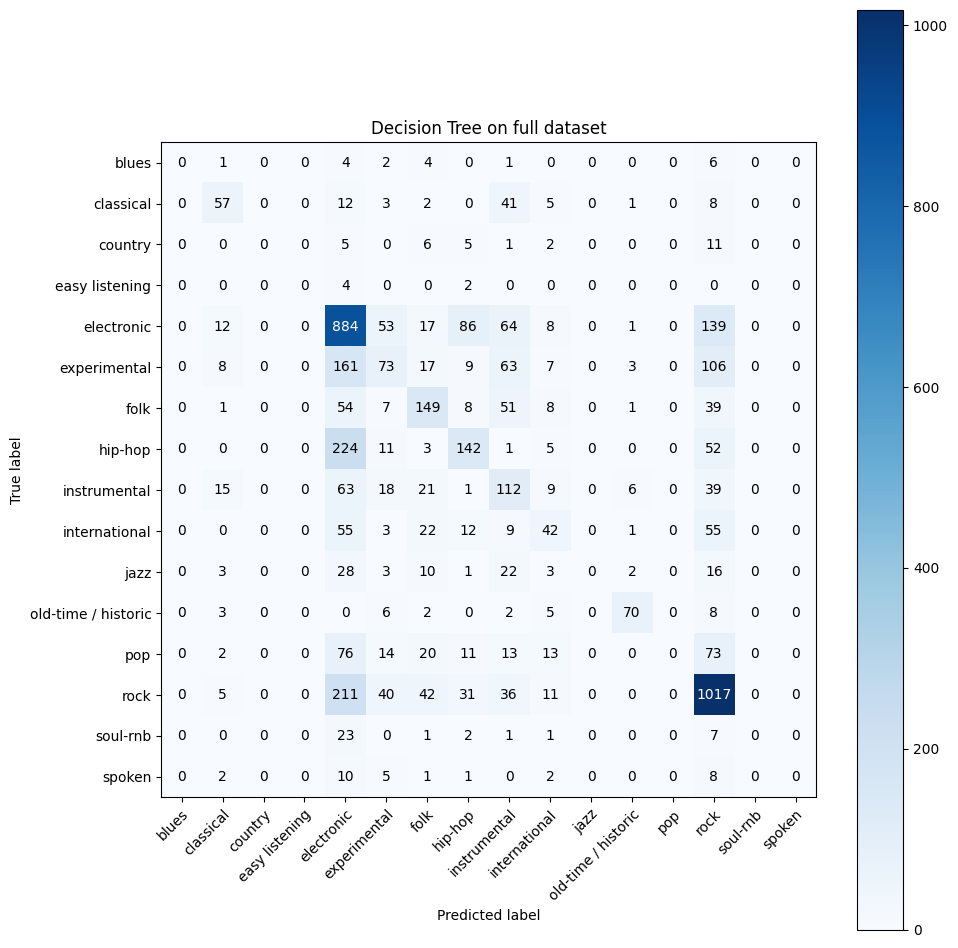

In [18]:
clf = load_model("dec_tree0.pkl")
valuate(clf, X_tests[0], y_test, title = 'Decision Tree on full dataset')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.42      0.40      0.41       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.50      0.70      0.58      1264
       experimental       0.31      0.17      0.22       447
               folk       0.40      0.43      0.42       318
            hip-hop       0.52      0.34      0.41       438
       instrumental       0.29      0.23      0.26       284
      international       0.29      0.16      0.20       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.76      0.82      0.79        96
                pop       0.00      0.00      0.00       222
               rock       0.61      0.79      0.69      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

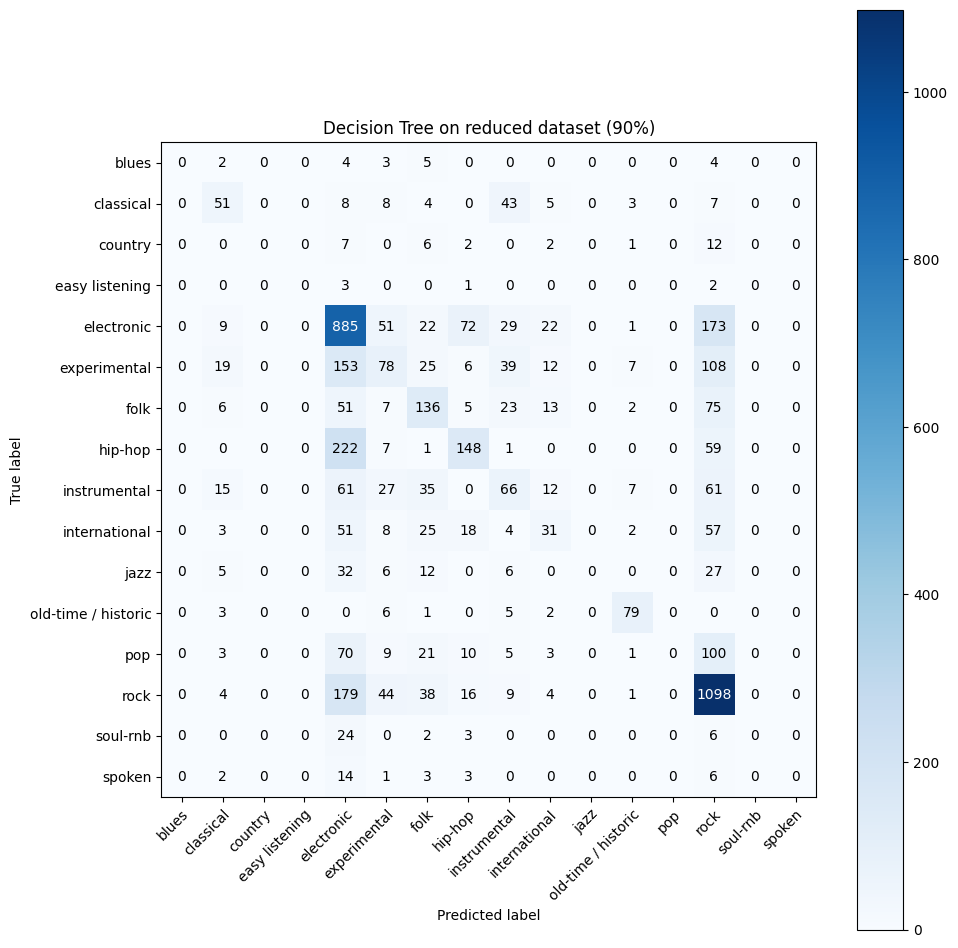

In [19]:
clf = load_model("dec_tree1.pkl")
valuate(clf, X_tests[1], y_test, title = 'Decision Tree on reduced dataset (90%)')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.40      0.46      0.43       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.52      0.68      0.59      1264
       experimental       0.32      0.14      0.19       447
               folk       0.43      0.37      0.40       318
            hip-hop       0.46      0.28      0.35       438
       instrumental       0.29      0.20      0.24       284
      international       0.28      0.21      0.24       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.76      0.81      0.79        96
                pop       0.00      0.00      0.00       222
               rock       0.57      0.83      0.68      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

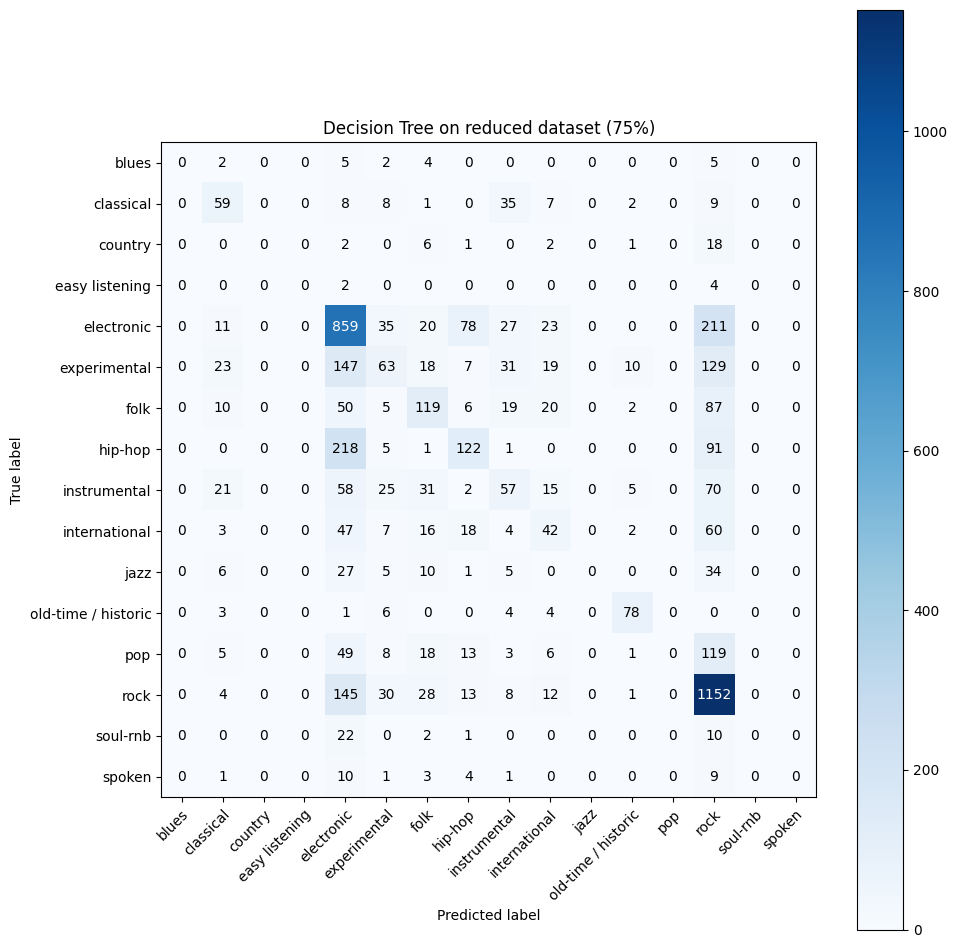

In [20]:
clf = load_model("dec_tree2.pkl")
valuate(clf, X_tests[2], y_test, title = 'Decision Tree on reduced dataset (75%)')

## Bagging

In [43]:
def bagging_clf(X_train, y_train, X_test, y_test, n_est = 8, md = 1, title: str = 'Bagging'):

    # create the model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    model = BaggingClassifier(classifier,n_estimators=n_est)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

    return model

### Model selection bagging
Esploriamo ora le performance del bagging facendo variare i meta-parametri

n_trees=1, max_depth=1: Accuracy=0.4302, F1_weighted=0.3034
n_trees=1, max_depth=2: Accuracy=0.4355, F1_weighted=0.3314
n_trees=1, max_depth=3: Accuracy=0.4573, F1_weighted=0.3713
n_trees=1, max_depth=4: Accuracy=0.4793, F1_weighted=0.4215
n_trees=1, max_depth=5: Accuracy=0.5049, F1_weighted=0.4515
n_trees=1, max_depth=6: Accuracy=0.5171, F1_weighted=0.4688
n_trees=1, max_depth=7: Accuracy=0.5154, F1_weighted=0.4734
n_trees=1, max_depth=8: Accuracy=0.5139, F1_weighted=0.4765
n_trees=1, max_depth=9: Accuracy=0.5048, F1_weighted=0.4735
n_trees=1, max_depth=10: Accuracy=0.4963, F1_weighted=0.4714
n_trees=1, max_depth=11: Accuracy=0.4851, F1_weighted=0.4659
n_trees=1, max_depth=12: Accuracy=0.4770, F1_weighted=0.4609
n_trees=1, max_depth=None: Accuracy=0.4242, F1_weighted=0.4276
n_trees=2, max_depth=1: Accuracy=0.4307, F1_weighted=0.3029
n_trees=2, max_depth=2: Accuracy=0.4370, F1_weighted=0.3336
n_trees=2, max_depth=3: Accuracy=0.4618, F1_weighted=0.3697
n_trees=2, max_depth=4: Accuracy=0

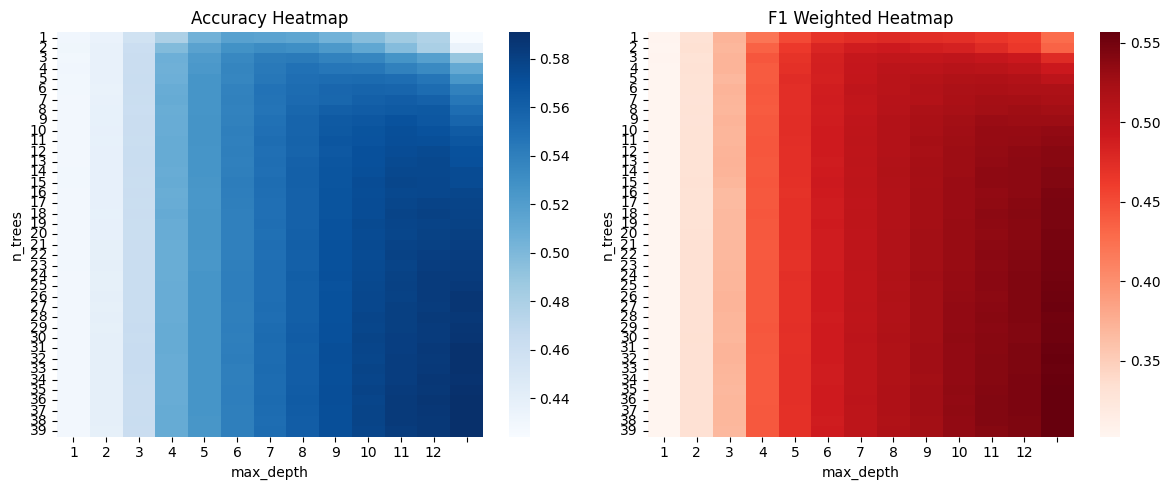

In [42]:
# select just one dataset
X_train, X_test = X_trains[1], X_tests[1]

n_trees_values = list(range(1,40))  # Numero di alberi nel bagging
max_depth_values = list(range(1,13)) + [None]  # Profondità degli alberi (None = senza limite)

# Matrici per salvare le metriche
accuracy_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))
f1_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))

scoring = ['accuracy', 'f1_weighted']

# Loop su entrambi i parametri
for i, n_trees in enumerate(n_trees_values):
    for j, depth in enumerate(max_depth_values):
        base_tree = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = BaggingClassifier(estimator=base_tree, n_estimators=n_trees, random_state=42)
        
        scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
        acc = np.mean(scores['test_accuracy'])
        f1 = np.mean(scores['test_f1_weighted'])
        
        # model.fit(X_train, y_train)
        # y_pred = model.predict(X_val)

        # acc = accuracy_score(y_val, y_pred)
        # f1 = f1_score(y_val, y_pred, average='weighted')

        accuracy_matrix[i, j] = acc
        f1_matrix[i, j] = f1

        print(f"n_trees={n_trees}, max_depth={depth}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione delle heatmap per visualizzare i risultati
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(accuracy_matrix, annot=False, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Blues", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_trees")

sns.heatmap(f1_matrix, annot=False, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Reds", ax=ax[1])
ax[1].set_title("F1 Weighted Heatmap")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_trees")

plt.tight_layout()
plt.show()

### Valuate best model

In [44]:
from numpy import unravel_index

i,j = unravel_index(accuracy_matrix.argmax(), accuracy_matrix.shape)
best_n_trees, best_md = n_trees_values[i], max_depth_values[j]
best_n_trees, best_md

(36, None)

                     precision    recall  f1-score   support

              blues       1.00      0.06      0.11        18
          classical       0.66      0.77      0.71       129
            country       0.50      0.03      0.06        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.56      0.79      0.66      1264
       experimental       0.44      0.31      0.36       447
               folk       0.58      0.62      0.60       318
            hip-hop       0.62      0.42      0.50       438
       instrumental       0.43      0.34      0.38       284
      international       0.67      0.31      0.42       199
               jazz       1.00      0.09      0.17        88
old-time / historic       0.83      0.95      0.89        96
                pop       0.28      0.05      0.08       222
               rock       0.69      0.82      0.75      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

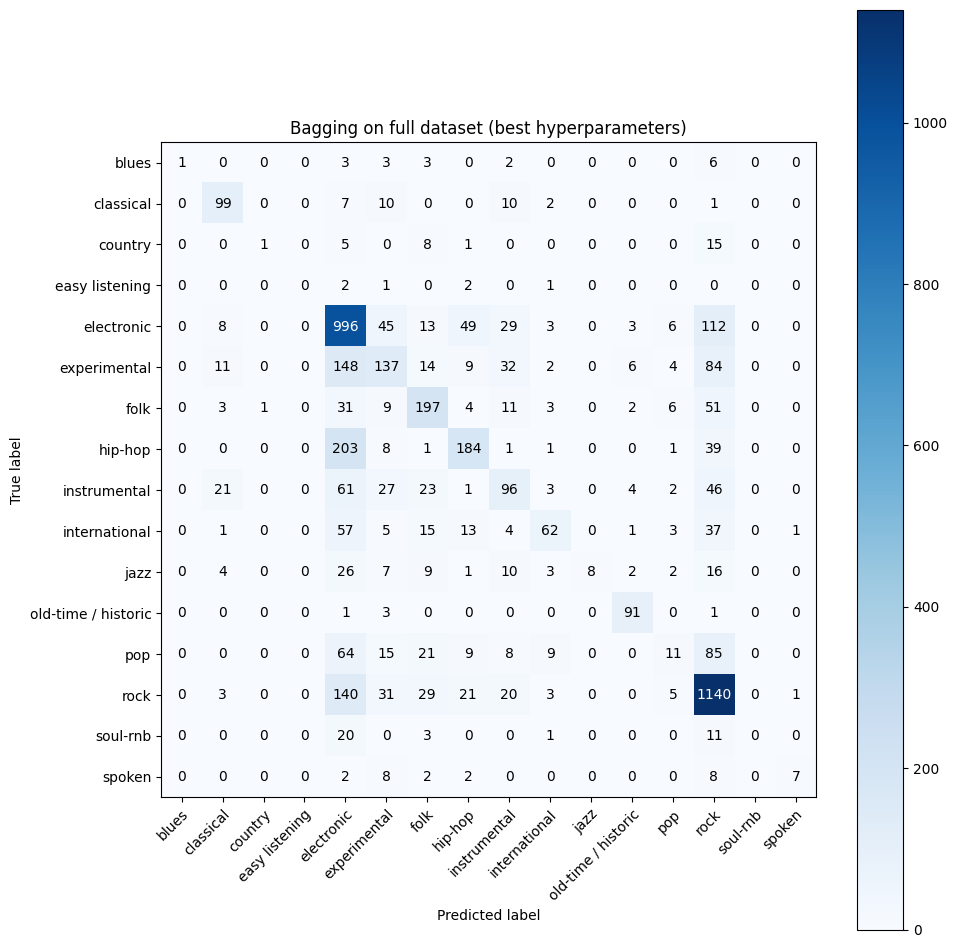

In [28]:
best_model = bagging_clf(X_trains[0], y_train, X_tests[0], y_test, n_est = 36, md = None, title = 'Bagging on full dataset (best hyperparameters)')

                     precision    recall  f1-score   support

              blues       1.00      0.06      0.11        18
          classical       0.56      0.66      0.60       129
            country       0.25      0.03      0.06        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.56      0.78      0.65      1264
       experimental       0.41      0.28      0.34       447
               folk       0.54      0.56      0.55       318
            hip-hop       0.59      0.44      0.50       438
       instrumental       0.43      0.34      0.38       284
      international       0.62      0.32      0.42       199
               jazz       0.88      0.08      0.15        88
old-time / historic       0.82      0.89      0.85        96
                pop       0.23      0.03      0.06       222
               rock       0.69      0.81      0.74      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

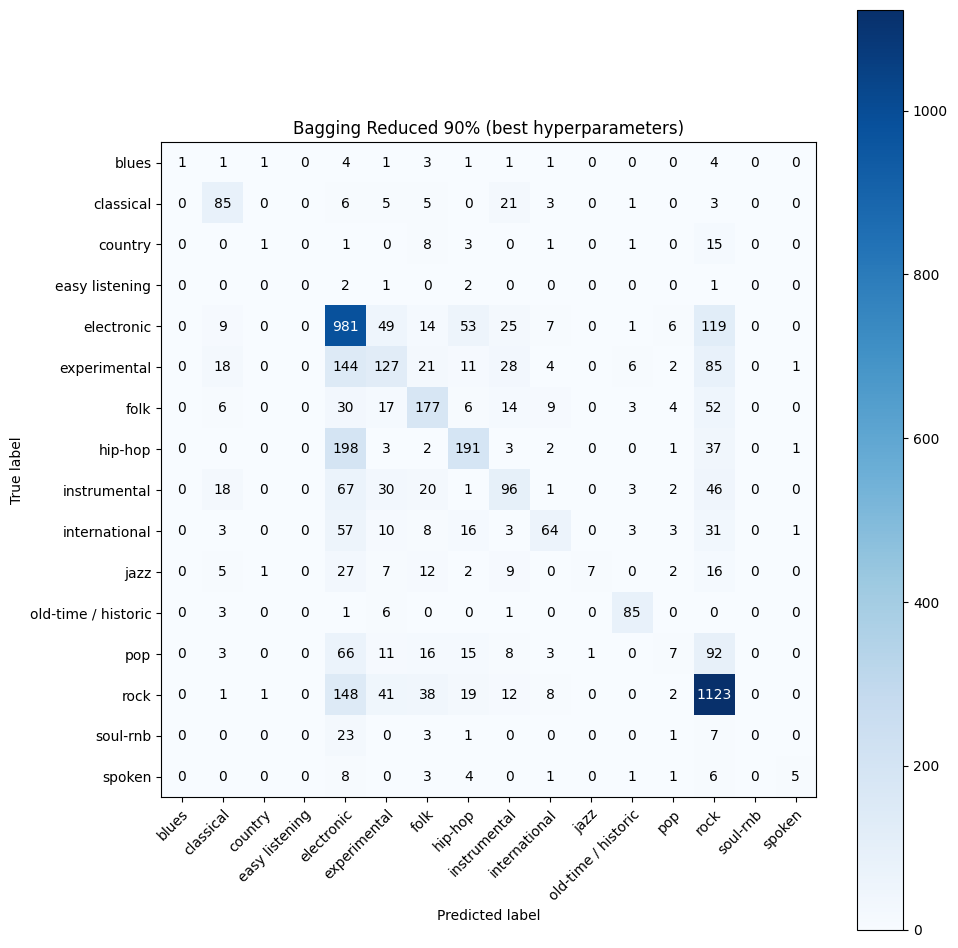

In [29]:
best_model = bagging_clf(X_trains[1], y_train, X_tests[1], y_test, n_est = 36, md = None, title = 'Bagging Reduced 90% (best hyperparameters)')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.54      0.56      0.55       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.55      0.74      0.63      1264
       experimental       0.35      0.27      0.30       447
               folk       0.50      0.52      0.51       318
            hip-hop       0.51      0.37      0.43       438
       instrumental       0.36      0.29      0.32       284
      international       0.53      0.33      0.41       199
               jazz       0.41      0.08      0.13        88
old-time / historic       0.79      0.89      0.83        96
                pop       0.26      0.07      0.11       222
               rock       0.67      0.78      0.72      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

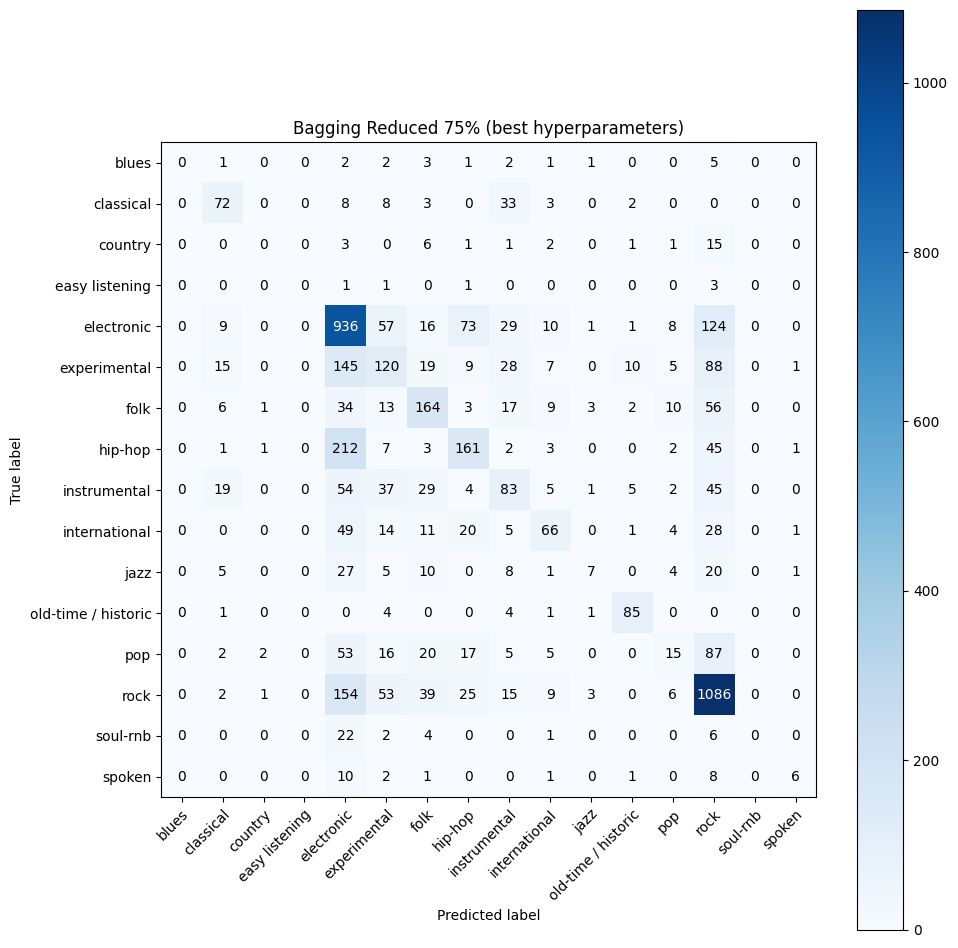

In [30]:
best_model = bagging_clf(X_trains[2], y_train, X_tests[2], y_test, n_est = 36, md = None, title = 'Bagging Reduced 75% (best hyperparameters)')

## Random forest
Per Random Forest effettuiamo solo la selezione degli iperparametri incrementale visto che, a causa dei troppi iperparametri, le nostre macchine non riescono a girare una grid search su un insieme ragionevole di parametri.

In [45]:
def rnd_forest_clf(X_train, y_train, X_test, y_test, n_est = 100, md = 3, title: str = 'Random forest'):

    # create the model
    model = RandomForestClassifier(n_estimators=n_est,max_depth=md)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

    return model

Ora esploriamo le performance del modello al variare di *n_trees_values* e *max_depth_values*

n_trees=50, max_depth=1: Accuracy=0.3957, F1_weighted=0.2725
n_trees=50, max_depth=2: Accuracy=0.4373, F1_weighted=0.3075
n_trees=50, max_depth=3: Accuracy=0.4525, F1_weighted=0.3271
n_trees=50, max_depth=4: Accuracy=0.4674, F1_weighted=0.3471
n_trees=50, max_depth=5: Accuracy=0.4976, F1_weighted=0.3941
n_trees=50, max_depth=6: Accuracy=0.5212, F1_weighted=0.4347
n_trees=50, max_depth=7: Accuracy=0.5371, F1_weighted=0.4620
n_trees=50, max_depth=8: Accuracy=0.5522, F1_weighted=0.4850
n_trees=50, max_depth=9: Accuracy=0.5643, F1_weighted=0.5031
n_trees=50, max_depth=10: Accuracy=0.5738, F1_weighted=0.5174
n_trees=50, max_depth=11: Accuracy=0.5799, F1_weighted=0.5264
n_trees=50, max_depth=12: Accuracy=0.5833, F1_weighted=0.5317
n_trees=50, max_depth=13: Accuracy=0.5855, F1_weighted=0.5356
n_trees=50, max_depth=14: Accuracy=0.5895, F1_weighted=0.5420
n_trees=50, max_depth=None: Accuracy=0.5977, F1_weighted=0.5558
n_trees=100, max_depth=1: Accuracy=0.4168, F1_weighted=0.2894
n_trees=100, ma

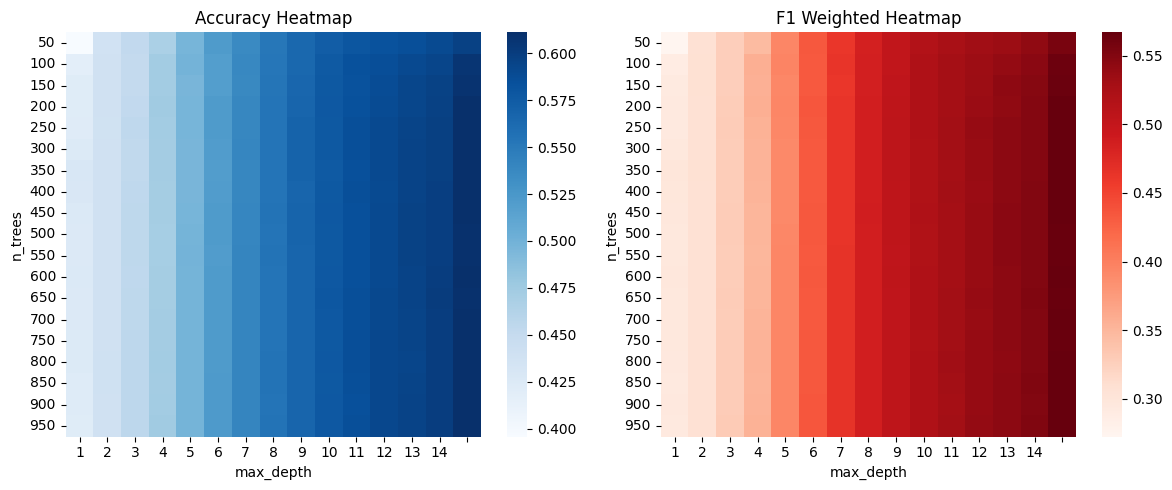

In [46]:
X_train, X_test = X_trains[1], X_tests[1]

n_trees_values = range(50, 1000, 50)
max_depth_values = list(range(1,15)) + [None]  # Profondità degli alberi (None = senza limite)

# Matrici per salvare le metriche
accuracy_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))
f1_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))

scoring = ['accuracy', 'f1_weighted']

# Loop su entrambi i parametri
for i, n_trees in enumerate(n_trees_values):
    for j, depth in enumerate(max_depth_values):
        model = RandomForestClassifier(n_estimators=n_trees, max_depth=depth, random_state=42)
        
        scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
        acc = np.mean(scores['test_accuracy'])
        f1 = np.mean(scores['test_f1_weighted'])
        
        # model.fit(X_train, y_train)
        # y_pred = model.predict(X_val)

        # acc = accuracy_score(y_val, y_pred)
        # f1 = f1_score(y_val, y_pred, average='weighted')

        accuracy_matrix[i, j] = acc
        f1_matrix[i, j] = f1

        print(f"n_trees={n_trees}, max_depth={depth}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione delle heatmap per visualizzare i risultati
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(accuracy_matrix, annot=False, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Blues", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_trees")

sns.heatmap(f1_matrix, annot=False, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Reds", ax=ax[1])
ax[1].set_title("F1 Weighted Heatmap")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_trees")

plt.tight_layout()
plt.show()

### Valuate best model

In [47]:
from numpy import unravel_index

i,j = unravel_index(accuracy_matrix.argmax(), accuracy_matrix.shape)
best_n_trees, best_md = n_trees_values[i], max_depth_values[j]

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.70      0.79      0.74       129
            country       1.00      0.03      0.06        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.58      0.82      0.68      1264
       experimental       0.47      0.30      0.37       447
               folk       0.58      0.64      0.61       318
            hip-hop       0.74      0.44      0.55       438
       instrumental       0.50      0.37      0.43       284
      international       0.76      0.33      0.46       199
               jazz       1.00      0.09      0.17        88
old-time / historic       0.86      0.97      0.91        96
                pop       0.60      0.01      0.03       222
               rock       0.68      0.85      0.75      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

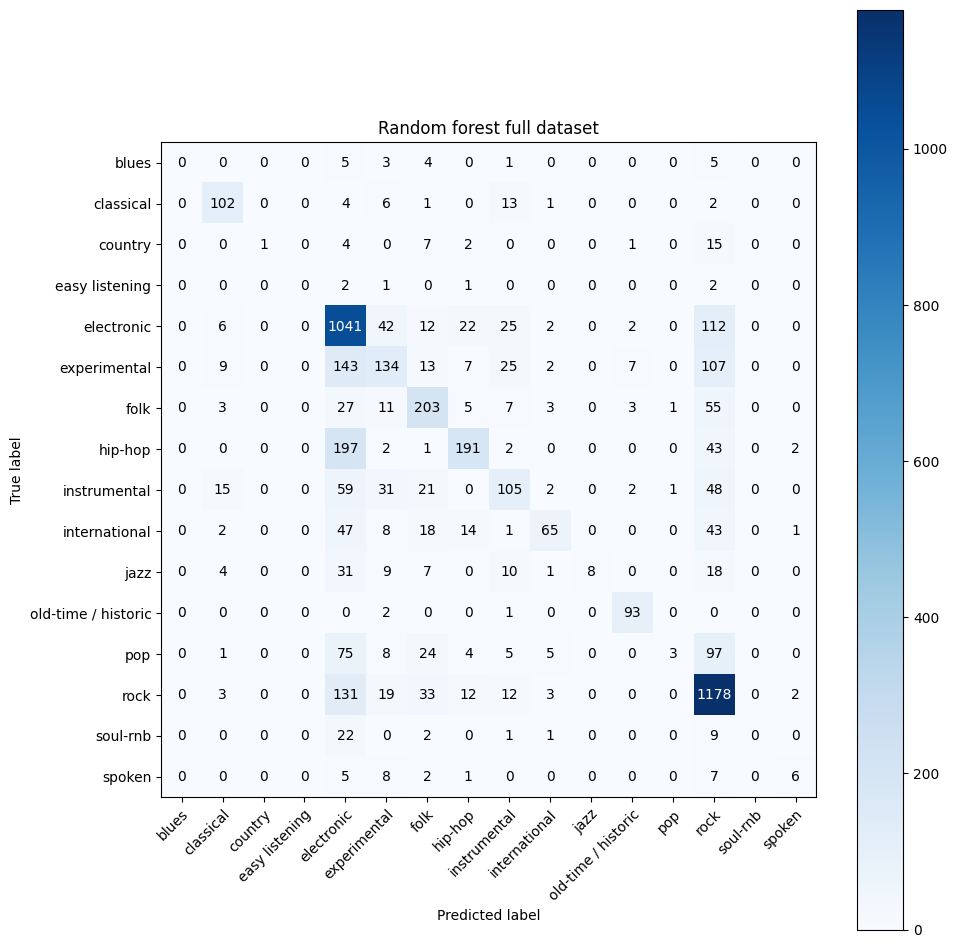

In [49]:
best_model = rnd_forest_clf(X_trains[0], y_train, X_tests[0], y_test, n_est=best_n_trees, md=best_md, title = "Random forest full dataset")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.67      0.69      0.68       129
            country       1.00      0.03      0.06        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.54      0.82      0.65      1264
       experimental       0.48      0.24      0.32       447
               folk       0.55      0.57      0.56       318
            hip-hop       0.66      0.43      0.52       438
       instrumental       0.50      0.35      0.41       284
      international       0.76      0.34      0.47       199
               jazz       1.00      0.07      0.13        88
old-time / historic       0.86      0.92      0.89        96
                pop       0.83      0.02      0.04       222
               rock       0.68      0.83      0.74      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

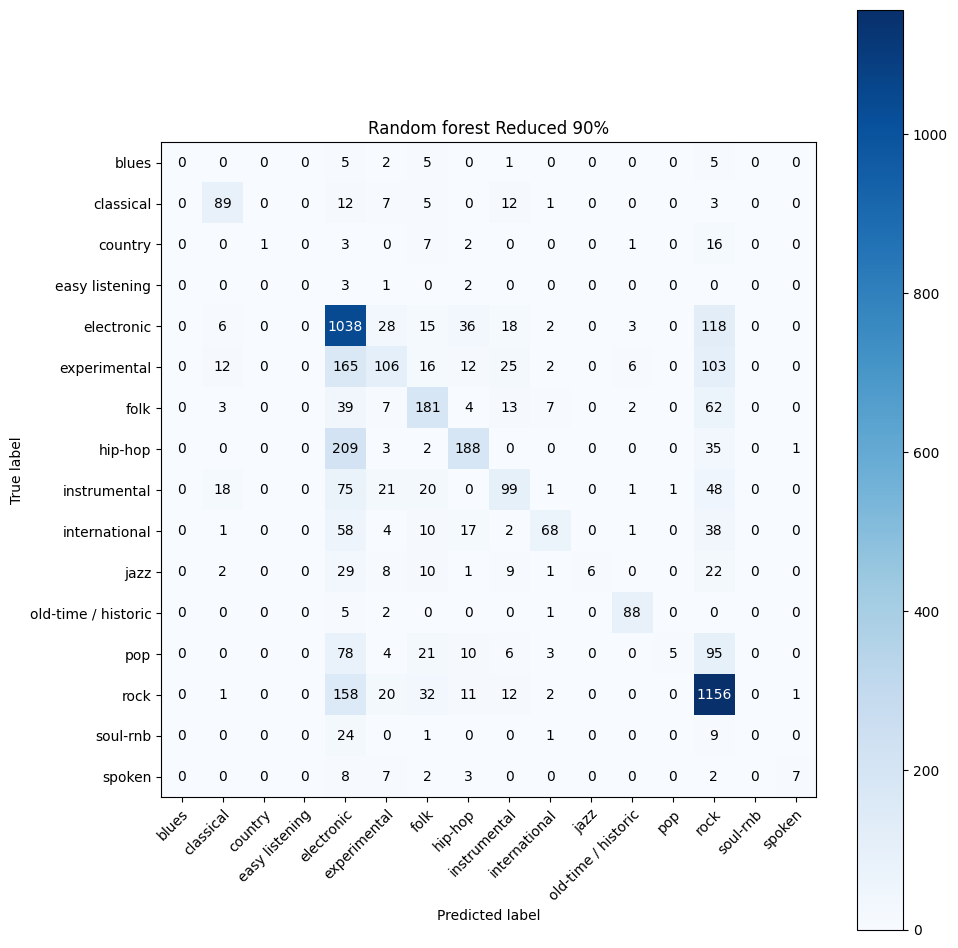

In [50]:
best_model = rnd_forest_clf(X_trains[1], y_train, X_tests[1], y_test, n_est=best_n_trees, md=best_md, title = "Random forest Reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.62      0.67      0.64       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.55      0.77      0.64      1264
       experimental       0.41      0.26      0.32       447
               folk       0.51      0.56      0.54       318
            hip-hop       0.54      0.37      0.44       438
       instrumental       0.41      0.32      0.36       284
      international       0.68      0.33      0.44       199
               jazz       0.80      0.05      0.09        88
old-time / historic       0.81      0.91      0.85        96
                pop       0.23      0.02      0.04       222
               rock       0.67      0.81      0.74      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

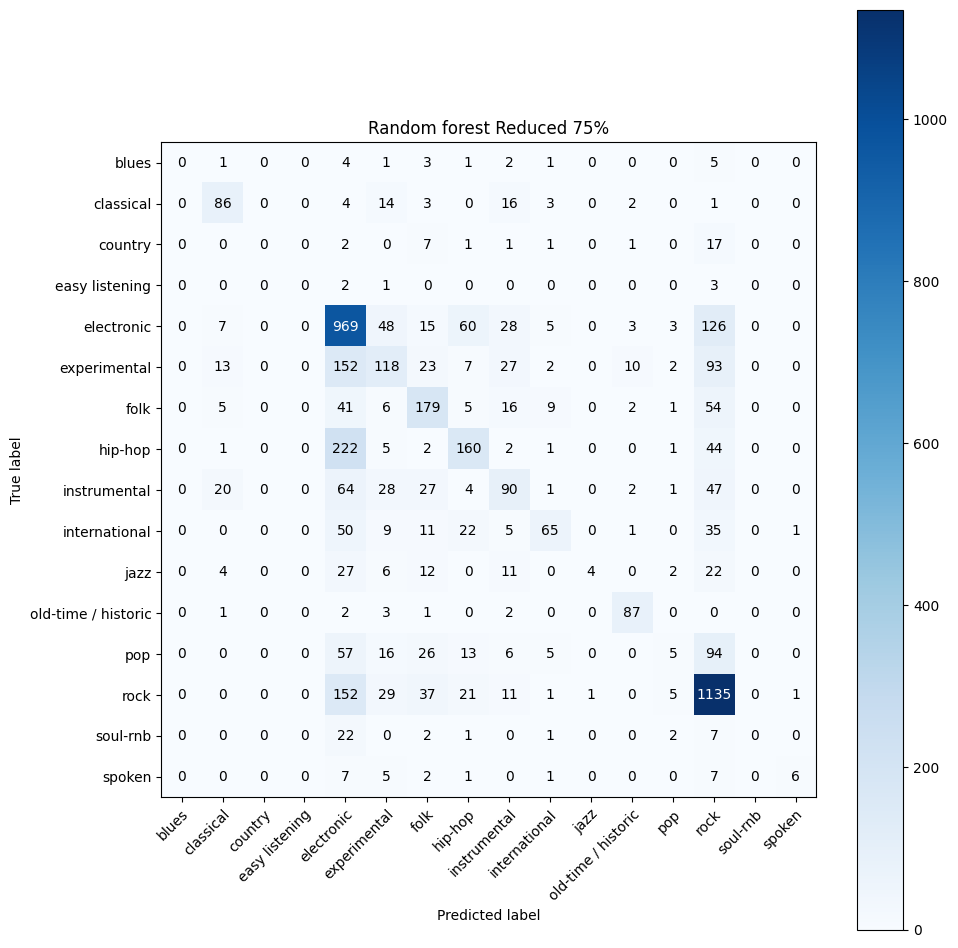

In [51]:
best_model = rnd_forest_clf(X_trains[2], y_train, X_tests[2], y_test, n_est=best_n_trees, md=best_md, title = "Random forest Reduced 75%")

## AdaBoost

In [46]:
def ada_clf(X_train, y_train, X_test, y_test, n_est = 8, md = 2, title: str = 'Random forest'):

    # create the model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    model = AdaBoostClassifier(classifier,n_estimators=n_est)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

### Model selection
Facciamo variare il numero di alberi in [10, 50, 100, 150, 200, 250, 300] e la *max_depth* in [1, 2, 3, 5, 10].

n_estimators=10, max_depth=1: Accuracy=0.4328, F1_weighted=0.3315
n_estimators=10, max_depth=2: Accuracy=0.4522, F1_weighted=0.4073
n_estimators=10, max_depth=3: Accuracy=0.4776, F1_weighted=0.4423
n_estimators=10, max_depth=5: Accuracy=0.4799, F1_weighted=0.4627
n_estimators=10, max_depth=10: Accuracy=0.4989, F1_weighted=0.4785
n_estimators=50, max_depth=1: Accuracy=0.4588, F1_weighted=0.3910
n_estimators=50, max_depth=2: Accuracy=0.4861, F1_weighted=0.4541
n_estimators=50, max_depth=3: Accuracy=0.4754, F1_weighted=0.4555
n_estimators=50, max_depth=5: Accuracy=0.4617, F1_weighted=0.4569
n_estimators=50, max_depth=10: Accuracy=0.5403, F1_weighted=0.5144
n_estimators=100, max_depth=1: Accuracy=0.4693, F1_weighted=0.4129
n_estimators=100, max_depth=2: Accuracy=0.4867, F1_weighted=0.4634
n_estimators=100, max_depth=3: Accuracy=0.4725, F1_weighted=0.4595
n_estimators=100, max_depth=5: Accuracy=0.4711, F1_weighted=0.4669
n_estimators=100, max_depth=10: Accuracy=0.5614, F1_weighted=0.5310
n_

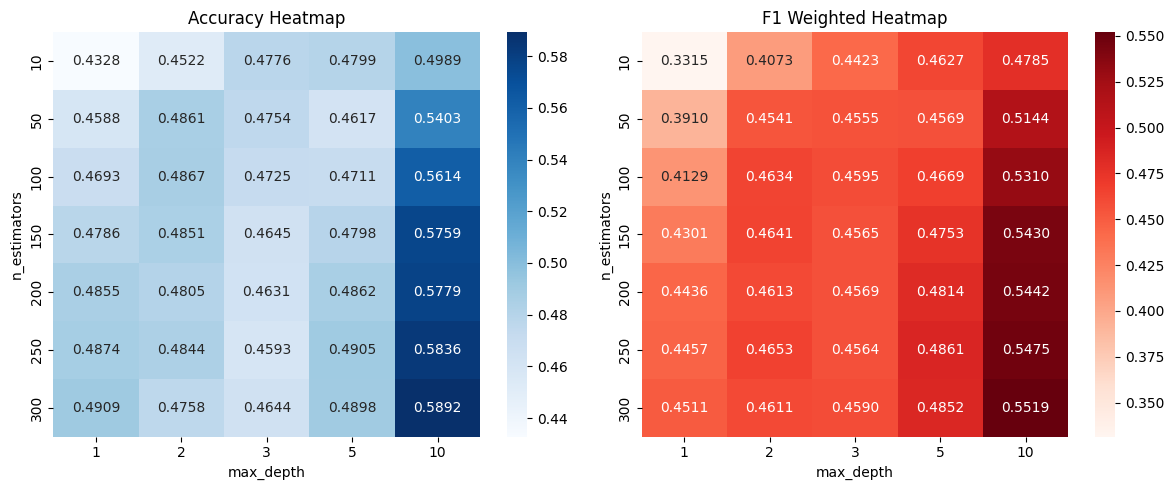

In [14]:
X_train, X_test = X_trains[1], X_tests[1]
n_estimators_values = [10, 50, 100, 150, 200, 250, 300]  # Numero di stadi del boosting
max_depth_values = [1, 2, 3, 5, 10]  # Profondità degli alberi base

# Matrici per salvare le metriche
accuracy_matrix = np.zeros((len(n_estimators_values), len(max_depth_values)))
f1_matrix = np.zeros((len(n_estimators_values), len(max_depth_values)))
scoring = ['accuracy', 'f1_weighted']

# Loop su entrambi i parametri
for i, n_estimators in enumerate(n_estimators_values):
    for j, depth in enumerate(max_depth_values):
        base_tree = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = AdaBoostClassifier(estimator=base_tree, n_estimators=n_estimators, random_state=42)
        
        scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
        acc = np.mean(scores['test_accuracy'])
        f1 = np.mean(scores['test_f1_weighted'])
        
        # model.fit(X_train, y_train)
        # y_pred = model.predict(X_test)

        # acc = accuracy_score(y_test, y_pred)
        # f1 = f1_score(y_test, y_pred, average='weighted')

        accuracy_matrix[i, j] = acc
        f1_matrix[i, j] = f1

        print(f"n_estimators={n_estimators}, max_depth={depth}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione delle heatmap per visualizzare i risultati
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(accuracy_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_estimators_values, cmap="Blues", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_estimators")

sns.heatmap(f1_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_estimators_values, cmap="Reds", ax=ax[1])
ax[1].set_title("F1 Weighted Heatmap")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_estimators")

plt.tight_layout()
plt.show()

### Valuate best model

In [77]:
from numpy import unravel_index

i,j = unravel_index(accuracy_matrix.argmax(), accuracy_matrix.shape)
best_n_est, best_md = n_estimators_values[i], max_depth_values[j]

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.71      0.71      0.71       129
            country       1.00      0.03      0.06        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.62      0.74      0.67      1264
       experimental       0.42      0.30      0.35       447
               folk       0.56      0.61      0.58       318
            hip-hop       0.62      0.51      0.56       438
       instrumental       0.42      0.36      0.39       284
      international       0.74      0.36      0.48       199
               jazz       0.73      0.09      0.16        88
old-time / historic       0.97      0.91      0.94        96
                pop       0.22      0.09      0.13       222
               rock       0.65      0.84      0.73      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

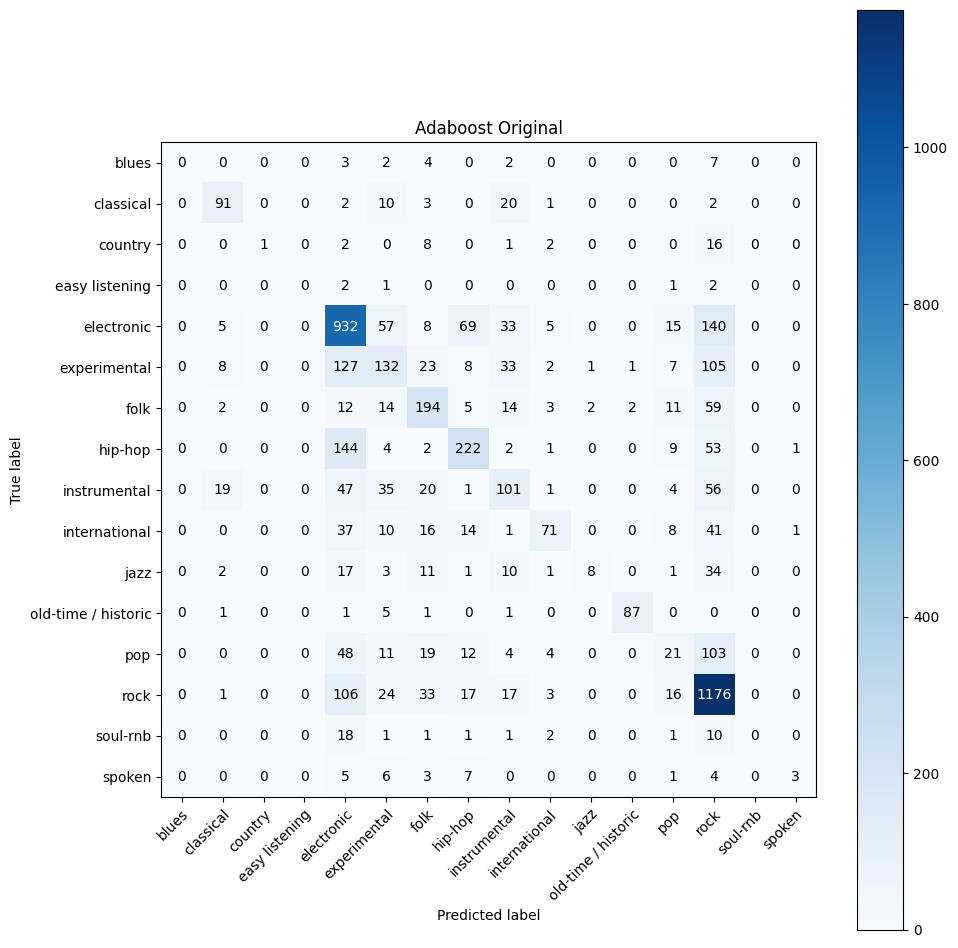

In [47]:
ada_clf(X_trains[0], y_train, X_tests[0], y_test, n_est=300, md=10, title = "Adaboost Original")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.76      0.57      0.65       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.57      0.73      0.64      1264
       experimental       0.40      0.25      0.30       447
               folk       0.56      0.60      0.58       318
            hip-hop       0.60      0.46      0.52       438
       instrumental       0.39      0.33      0.36       284
      international       0.66      0.31      0.42       199
               jazz       0.91      0.11      0.20        88
old-time / historic       0.96      0.83      0.89        96
                pop       0.19      0.06      0.09       222
               rock       0.63      0.83      0.72      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

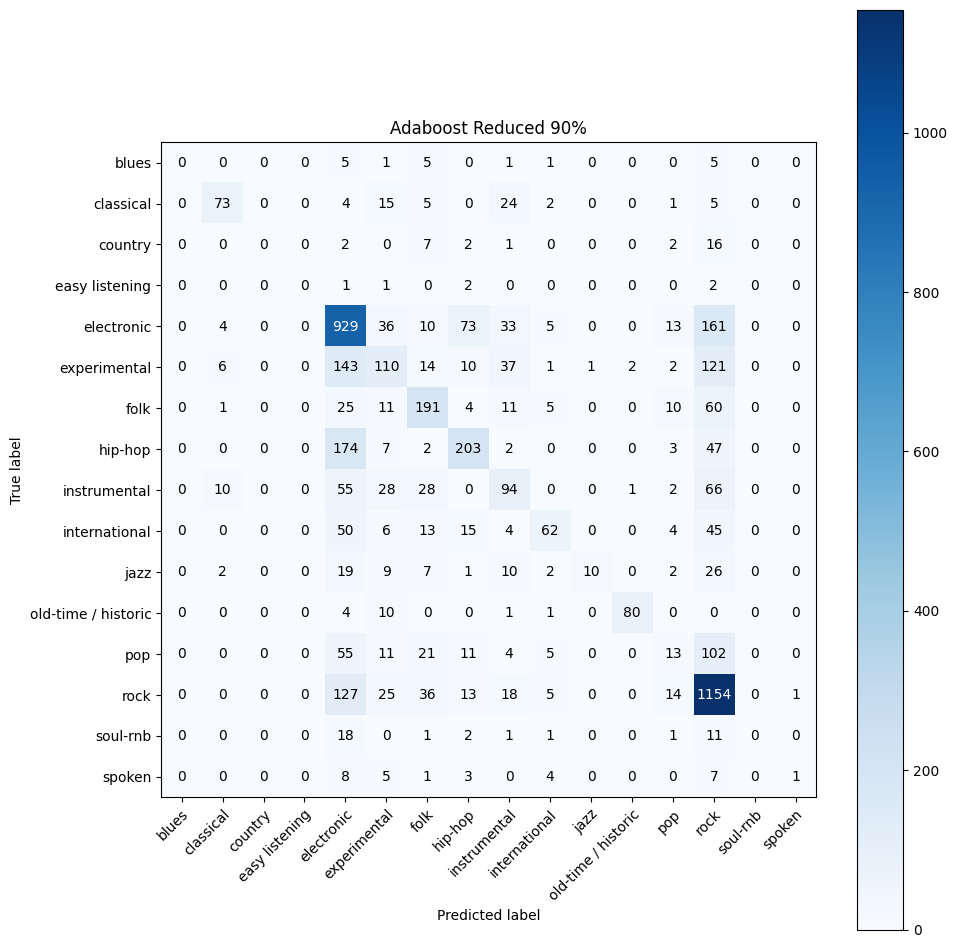

In [48]:
ada_clf(X_trains[1], y_train, X_tests[1], y_test, n_est=300, md=10, title = "Adaboost Reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.61      0.60      0.60       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.56      0.68      0.62      1264
       experimental       0.34      0.24      0.28       447
               folk       0.50      0.56      0.53       318
            hip-hop       0.47      0.39      0.42       438
       instrumental       0.35      0.30      0.32       284
      international       0.55      0.30      0.39       199
               jazz       0.54      0.08      0.14        88
old-time / historic       0.89      0.80      0.84        96
                pop       0.18      0.05      0.08       222
               rock       0.64      0.82      0.72      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

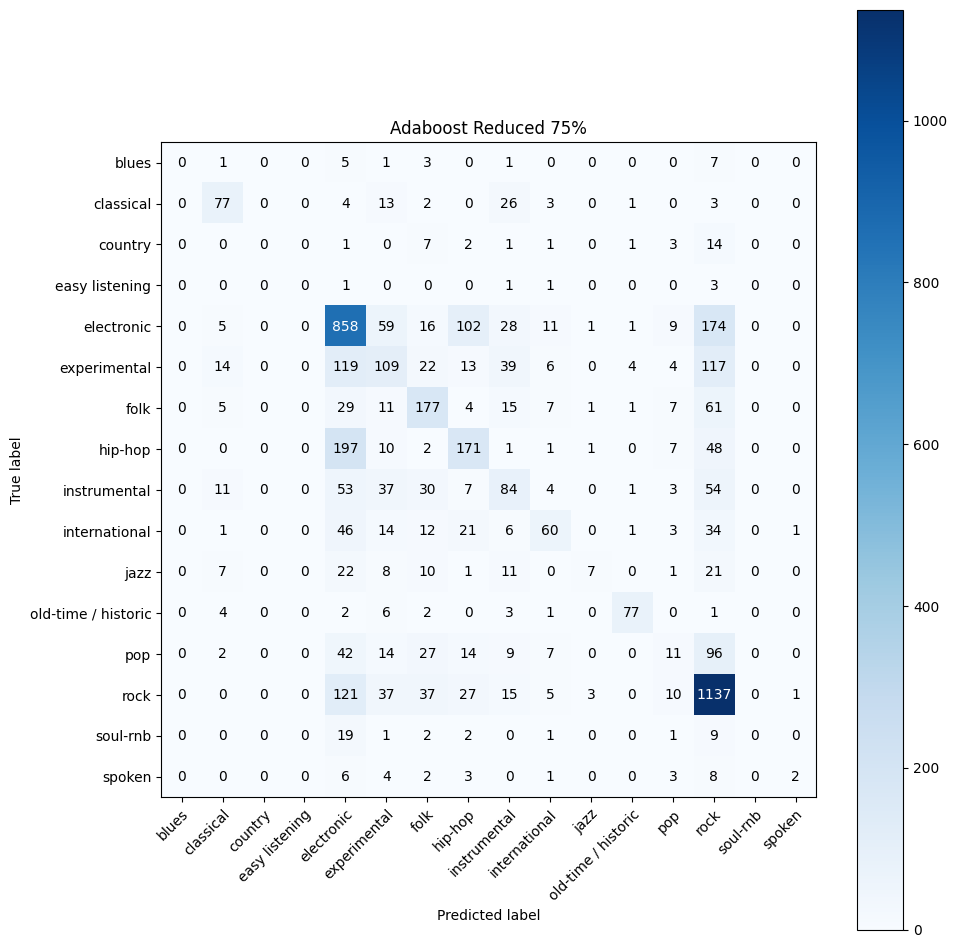

In [49]:
ada_clf(X_trains[2], y_train, X_tests[2], y_test, n_est=300, md=10, title = "Adaboost Reduced 75%")

## Extreme Gradient Boosting
XGB è un modello basato su alberi e consigliabile per classificazioni multiclasse.
Inoltre fa uso di alberi piccoli che ne migliorano la generalizzazione.

A differenza di AdaBoost, gli algoritmi di gradient boosting costruiscono classificatori deboli che sono dipendenti l'uno dall'altro. Ogni nuovo classificatore cerca di correggere gli errori residui fatti dai modelli precedenti.

In [34]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

def XGB(X_train, y_train, X_test, y_test, title: str = 'Extreme Gradient Boosting'):

    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_train_encoded = label_encoder.fit_transform(y_train)

    model = XGBClassifier(learning_rate=0.1, n_estimators=300)

    model.fit(X_train, y_train_encoded)

    valuate(model, X_test, y_test_encoded, title=title)

### Model selection - Gridsearch XGB

In [3]:
X_train, X_test = X_trains[1], X_tests[1]

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 1000, 50)
}

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

model = XGBClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train_encoded)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test_encoded)
print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

Migliori parametri: {'learning_rate': 0.1, 'n_estimators': 300}
Accuracy del modello ottimizzato: 0.6273018414731786


### Valuate best model

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.76      0.82      0.79       129
           2       0.80      0.13      0.23        30
           3       0.00      0.00      0.00         6
           4       0.64      0.79      0.71      1264
           5       0.47      0.42      0.44       447
           6       0.65      0.64      0.65       318
           7       0.66      0.55      0.60       438
           8       0.47      0.39      0.43       284
           9       0.70      0.48      0.57       199
          10       0.91      0.24      0.38        88
          11       0.93      0.97      0.95        96
          12       0.39      0.13      0.19       222
          13       0.72      0.85      0.78      1393
          14       0.00      0.00      0.00        35
          15       0.67      0.28      0.39        29

    accuracy                           0.66      4996
   macro avg       0.55   

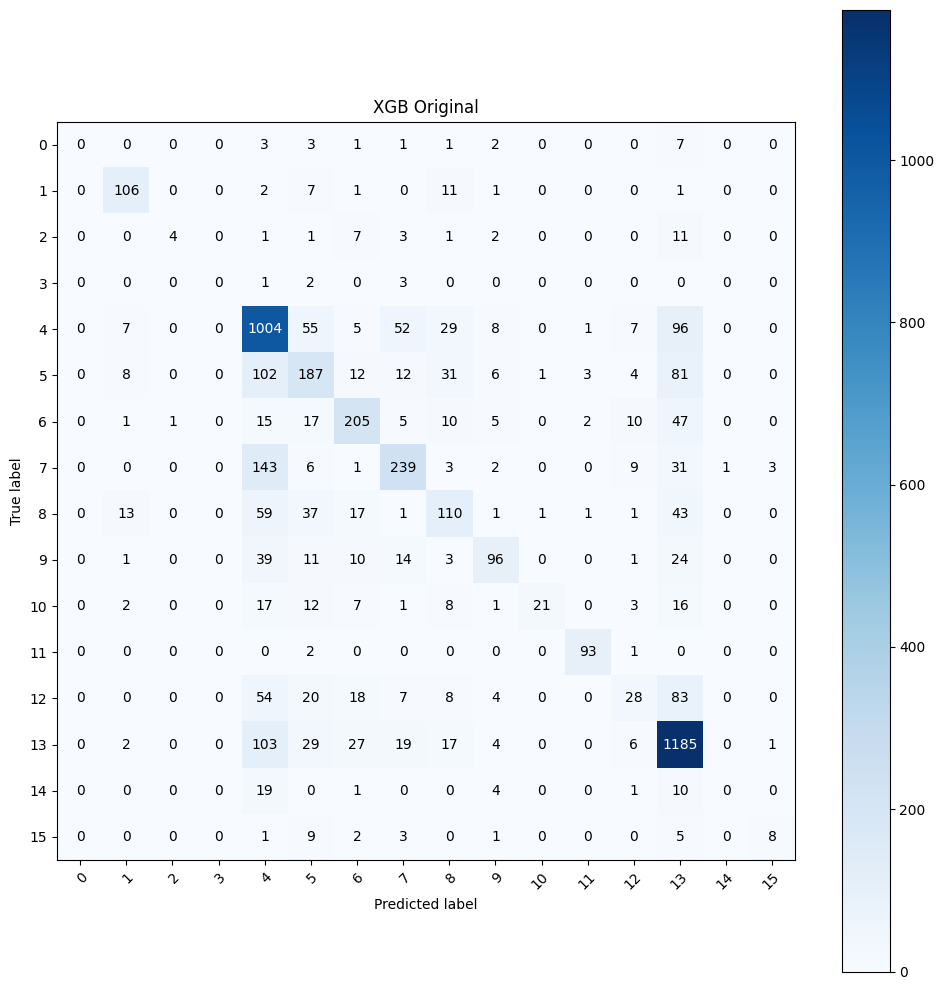

In [35]:
XGB(X_trains[0], y_train, X_tests[0], y_test, title="XGB full dataset")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.73      0.73      0.73       129
           2       0.50      0.03      0.06        30
           3       0.00      0.00      0.00         6
           4       0.60      0.77      0.68      1264
           5       0.44      0.36      0.40       447
           6       0.56      0.57      0.57       318
           7       0.59      0.51      0.55       438
           8       0.49      0.37      0.42       284
           9       0.66      0.38      0.48       199
          10       0.73      0.22      0.33        88
          11       0.93      0.91      0.92        96
          12       0.33      0.09      0.14       222
          13       0.69      0.83      0.76      1393
          14       1.00      0.03      0.06        35
          15       0.70      0.24      0.36        29

    accuracy                           0.62      4996
   macro avg       0.56   

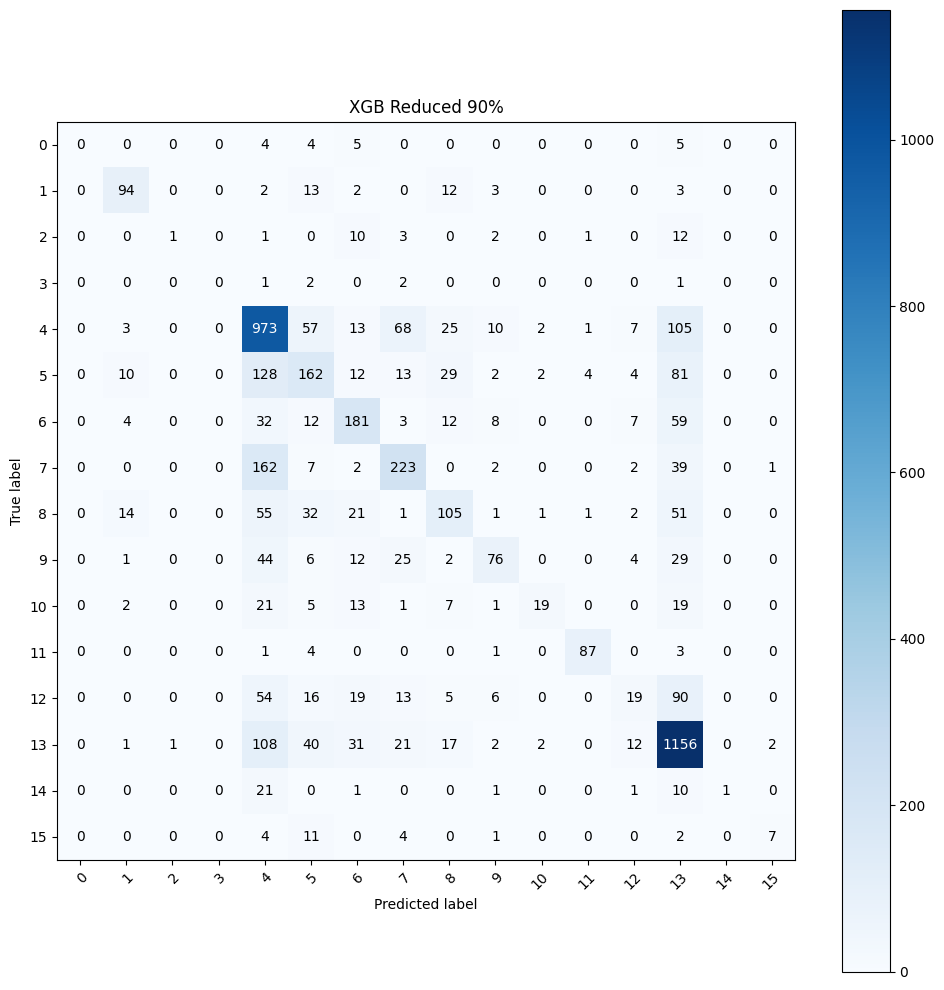

In [36]:
XGB(X_trains[1], y_train, X_tests[1], y_test, title="XGB Reduced 90%")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.64      0.72      0.68       129
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         6
           4       0.58      0.73      0.65      1264
           5       0.39      0.32      0.35       447
           6       0.52      0.53      0.52       318
           7       0.53      0.43      0.48       438
           8       0.39      0.31      0.34       284
           9       0.58      0.31      0.40       199
          10       0.50      0.12      0.20        88
          11       0.85      0.90      0.87        96
          12       0.27      0.06      0.10       222
          13       0.67      0.81      0.73      1393
          14       0.00      0.00      0.00        35
          15       0.57      0.28      0.37        29

    accuracy                           0.58      4996
   macro avg       0.41   

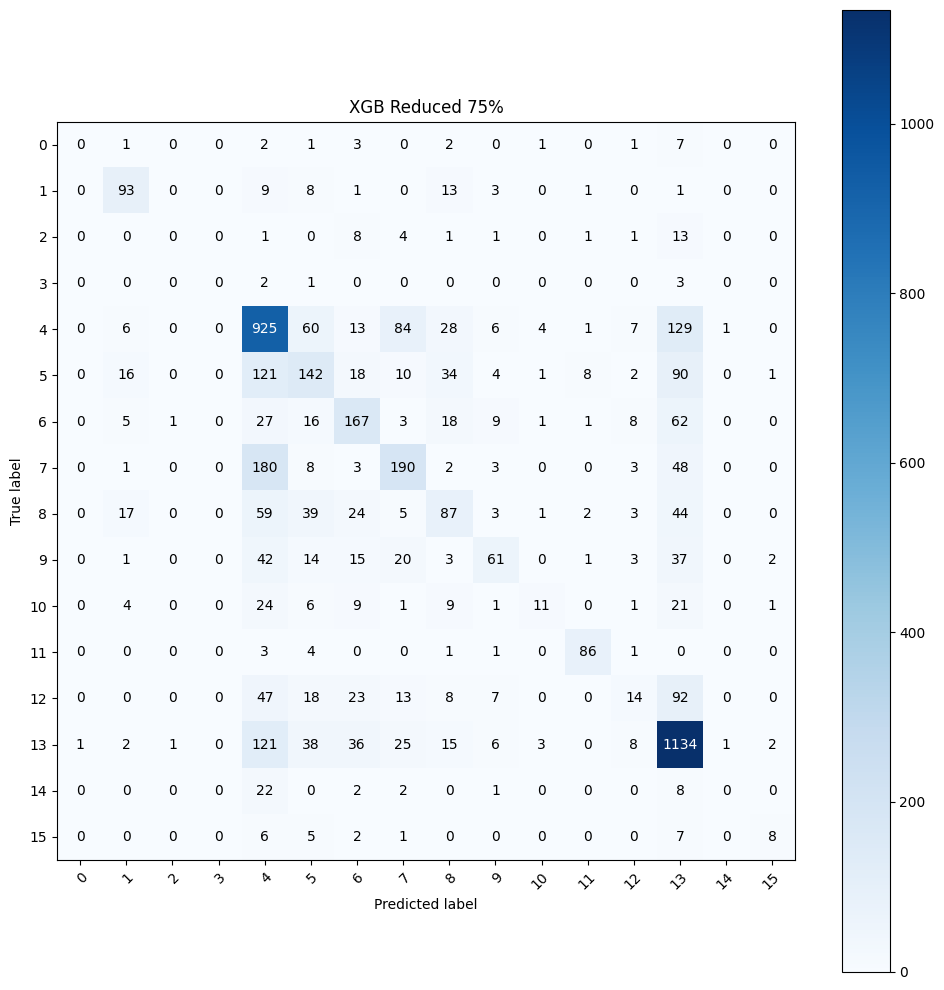

In [37]:
XGB(X_trains[2], y_train, X_tests[2], y_test, title="XGB Reduced 75%")

# Rete Neurale 

La rete neurale è un modello complesso che abbiamo soltanto introdotto durante il corso. Qui proponiamo un'architettura a tre layer, con solo uno hidden, il quale è munito di funzione di attivazione ReLu.

In [59]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y

In [60]:
from torcheval.metrics.functional import multiclass_f1_score

label_encoder = LabelEncoder()

# Feedforward neural network
X_train, X_test = X_trains[0], X_tests[0]
d = 78

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class MultiClassNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(d, d//2)
        self.act = nn.ReLU()
        self.output = nn.Linear(d//2, 16)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

y_train_tensor.shape

model = MultiClassNN()

# loss metric and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 50
batch_size = 150
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_f1 = - np.inf
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
train_f1_hist = []
test_f1_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            # f1 = multiclass_f1_score(y_pred, torch.tensor(label_encoder.fit_transform(y_batch)), num_classes=16, average='weighted')
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            # epoch_f1.append(float(f1))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
                # f1=float(f1)
            )

    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test_tensor)
    ce = loss_fn(y_pred, y_test_tensor)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)).float().mean()
    f1 = multiclass_f1_score(y_pred, torch.tensor(label_encoder.fit_transform(y_test)), num_classes=16, average='weighted')
    ce = float(ce)
    acc = float(acc)
    f1 = float(f1)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    train_f1_hist.append(np.mean(epoch_f1))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    test_f1_hist.append(f1)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    if f1 > best_f1:
        best_f1 = f1
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%, f1={f1*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

Using device: cuda


Epoch 0: 100%|█| 133/133 [00:00<00:00, 367.34batch/s, acc=0.587


Epoch 0 validation: Cross-entropy=1.52, Accuracy=53.4%, f1=46.8%


Epoch 1: 100%|█| 133/133 [00:00<00:00, 391.21batch/s, acc=0.6, 


Epoch 1 validation: Cross-entropy=1.39, Accuracy=56.9%, f1=52.3%


Epoch 2: 100%|█| 133/133 [00:00<00:00, 403.74batch/s, acc=0.647


Epoch 2 validation: Cross-entropy=1.33, Accuracy=58.2%, f1=54.2%


Epoch 3: 100%|█| 133/133 [00:00<00:00, 409.78batch/s, acc=0.653


Epoch 3 validation: Cross-entropy=1.30, Accuracy=59.1%, f1=55.5%


Epoch 4: 100%|█| 133/133 [00:00<00:00, 405.06batch/s, acc=0.68,


Epoch 4 validation: Cross-entropy=1.28, Accuracy=59.9%, f1=56.4%


Epoch 5: 100%|█| 133/133 [00:00<00:00, 427.11batch/s, acc=0.687


Epoch 5 validation: Cross-entropy=1.26, Accuracy=60.1%, f1=56.8%


Epoch 6: 100%|█| 133/133 [00:00<00:00, 425.57batch/s, acc=0.687


Epoch 6 validation: Cross-entropy=1.25, Accuracy=60.5%, f1=57.2%


Epoch 7: 100%|█| 133/133 [00:00<00:00, 425.56batch/s, acc=0.7, 


Epoch 7 validation: Cross-entropy=1.23, Accuracy=60.7%, f1=57.7%


Epoch 8: 100%|█| 133/133 [00:00<00:00, 454.53batch/s, acc=0.707


Epoch 8 validation: Cross-entropy=1.23, Accuracy=61.1%, f1=58.1%


Epoch 9: 100%|█| 133/133 [00:00<00:00, 430.33batch/s, acc=0.7, 


Epoch 9 validation: Cross-entropy=1.22, Accuracy=61.4%, f1=58.4%


Epoch 10: 100%|█| 133/133 [00:00<00:00, 420.39batch/s, acc=0.69


Epoch 10 validation: Cross-entropy=1.21, Accuracy=61.8%, f1=58.9%


Epoch 11: 100%|█| 133/133 [00:00<00:00, 408.94batch/s, acc=0.69


Epoch 11 validation: Cross-entropy=1.21, Accuracy=62.0%, f1=59.1%


Epoch 12: 100%|█| 133/133 [00:00<00:00, 434.41batch/s, acc=0.69


Epoch 12 validation: Cross-entropy=1.20, Accuracy=62.0%, f1=59.2%


Epoch 13: 100%|█| 133/133 [00:00<00:00, 454.21batch/s, acc=0.69


Epoch 13 validation: Cross-entropy=1.20, Accuracy=62.1%, f1=59.4%


Epoch 14: 100%|█| 133/133 [00:00<00:00, 421.47batch/s, acc=0.69


Epoch 14 validation: Cross-entropy=1.19, Accuracy=62.1%, f1=59.3%


Epoch 15: 100%|█| 133/133 [00:00<00:00, 433.30batch/s, acc=0.69


Epoch 15 validation: Cross-entropy=1.19, Accuracy=62.2%, f1=59.5%


Epoch 16: 100%|█| 133/133 [00:00<00:00, 453.88batch/s, acc=0.69


Epoch 16 validation: Cross-entropy=1.19, Accuracy=62.5%, f1=59.8%


Epoch 17: 100%|█| 133/133 [00:00<00:00, 420.73batch/s, acc=0.69


Epoch 17 validation: Cross-entropy=1.19, Accuracy=62.7%, f1=60.0%


Epoch 18: 100%|█| 133/133 [00:00<00:00, 424.67batch/s, acc=0.69


Epoch 18 validation: Cross-entropy=1.18, Accuracy=62.9%, f1=60.2%


Epoch 19: 100%|█| 133/133 [00:00<00:00, 426.41batch/s, acc=0.69


Epoch 19 validation: Cross-entropy=1.18, Accuracy=62.9%, f1=60.3%


Epoch 20: 100%|█| 133/133 [00:00<00:00, 420.55batch/s, acc=0.7,


Epoch 20 validation: Cross-entropy=1.18, Accuracy=63.1%, f1=60.5%


Epoch 21: 100%|█| 133/133 [00:00<00:00, 408.49batch/s, acc=0.7,


Epoch 21 validation: Cross-entropy=1.18, Accuracy=63.2%, f1=60.6%


Epoch 22: 100%|█| 133/133 [00:00<00:00, 393.94batch/s, acc=0.70


Epoch 22 validation: Cross-entropy=1.18, Accuracy=63.2%, f1=60.7%


Epoch 23: 100%|█| 133/133 [00:00<00:00, 422.01batch/s, acc=0.70


Epoch 23 validation: Cross-entropy=1.18, Accuracy=63.3%, f1=60.8%


Epoch 24: 100%|█| 133/133 [00:00<00:00, 404.33batch/s, acc=0.70


Epoch 24 validation: Cross-entropy=1.18, Accuracy=63.4%, f1=60.8%


Epoch 25: 100%|█| 133/133 [00:00<00:00, 446.62batch/s, acc=0.70


Epoch 25 validation: Cross-entropy=1.18, Accuracy=63.4%, f1=60.8%


Epoch 26: 100%|█| 133/133 [00:00<00:00, 433.22batch/s, acc=0.70


Epoch 26 validation: Cross-entropy=1.18, Accuracy=63.5%, f1=61.0%


Epoch 27: 100%|█| 133/133 [00:00<00:00, 436.87batch/s, acc=0.70


Epoch 27 validation: Cross-entropy=1.18, Accuracy=63.5%, f1=61.0%


Epoch 28: 100%|█| 133/133 [00:00<00:00, 442.56batch/s, acc=0.71


Epoch 28 validation: Cross-entropy=1.18, Accuracy=63.5%, f1=61.0%


Epoch 29: 100%|█| 133/133 [00:00<00:00, 449.68batch/s, acc=0.71


Epoch 29 validation: Cross-entropy=1.18, Accuracy=63.6%, f1=61.2%


Epoch 30: 100%|█| 133/133 [00:00<00:00, 436.21batch/s, acc=0.71


Epoch 30 validation: Cross-entropy=1.18, Accuracy=63.6%, f1=61.1%


Epoch 31: 100%|█| 133/133 [00:00<00:00, 420.06batch/s, acc=0.72


Epoch 31 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.1%


Epoch 32: 100%|█| 133/133 [00:00<00:00, 431.74batch/s, acc=0.72


Epoch 32 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.2%


Epoch 33: 100%|█| 133/133 [00:00<00:00, 445.86batch/s, acc=0.72


Epoch 33 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.2%


Epoch 34: 100%|█| 133/133 [00:00<00:00, 428.41batch/s, acc=0.72


Epoch 34 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.2%


Epoch 35: 100%|█| 133/133 [00:00<00:00, 442.19batch/s, acc=0.72


Epoch 35 validation: Cross-entropy=1.17, Accuracy=63.5%, f1=61.2%


Epoch 36: 100%|█| 133/133 [00:00<00:00, 415.13batch/s, acc=0.72


Epoch 36 validation: Cross-entropy=1.17, Accuracy=63.5%, f1=61.1%


Epoch 37: 100%|█| 133/133 [00:00<00:00, 431.57batch/s, acc=0.72


Epoch 37 validation: Cross-entropy=1.17, Accuracy=63.4%, f1=61.0%


Epoch 38: 100%|█| 133/133 [00:00<00:00, 423.62batch/s, acc=0.72


Epoch 38 validation: Cross-entropy=1.17, Accuracy=63.5%, f1=61.1%


Epoch 39: 100%|█| 133/133 [00:00<00:00, 425.37batch/s, acc=0.72


Epoch 39 validation: Cross-entropy=1.17, Accuracy=63.5%, f1=61.1%


Epoch 40: 100%|█| 133/133 [00:00<00:00, 423.30batch/s, acc=0.72


Epoch 40 validation: Cross-entropy=1.17, Accuracy=63.7%, f1=61.3%


Epoch 41: 100%|█| 133/133 [00:00<00:00, 401.88batch/s, acc=0.73


Epoch 41 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.3%


Epoch 42: 100%|█| 133/133 [00:00<00:00, 434.05batch/s, acc=0.74


Epoch 42 validation: Cross-entropy=1.17, Accuracy=63.7%, f1=61.4%


Epoch 43: 100%|█| 133/133 [00:00<00:00, 435.01batch/s, acc=0.74


Epoch 43 validation: Cross-entropy=1.17, Accuracy=63.8%, f1=61.4%


Epoch 44: 100%|█| 133/133 [00:00<00:00, 444.62batch/s, acc=0.75


Epoch 44 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.3%


Epoch 45: 100%|█| 133/133 [00:00<00:00, 434.01batch/s, acc=0.75


Epoch 45 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.3%


Epoch 46: 100%|█| 133/133 [00:00<00:00, 437.17batch/s, acc=0.75


Epoch 46 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.3%


Epoch 47: 100%|█| 133/133 [00:00<00:00, 432.50batch/s, acc=0.75


Epoch 47 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.3%


Epoch 48: 100%|█| 133/133 [00:00<00:00, 436.82batch/s, acc=0.75


Epoch 48 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.3%


Epoch 49: 100%|█| 133/133 [00:00<00:00, 423.35batch/s, acc=0.75


Epoch 49 validation: Cross-entropy=1.17, Accuracy=63.6%, f1=61.3%


<All keys matched successfully>

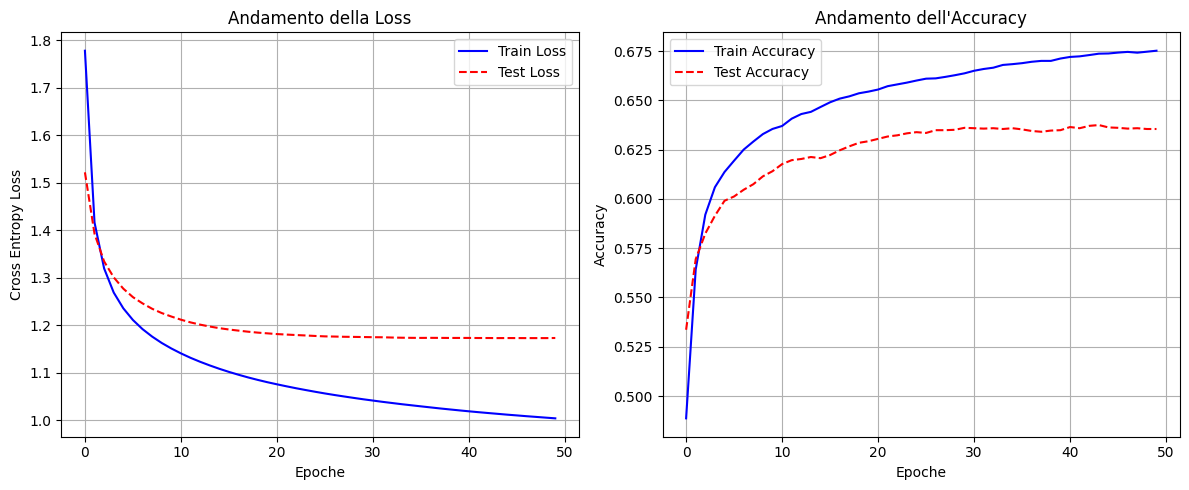

In [61]:
# Creazione della figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot della Loss
axes[0].plot(train_loss_hist, linestyle='-', label="Train Loss", color="blue")
axes[0].plot(test_loss_hist, linestyle='--', label="Test Loss", color="red")
axes[0].set_xlabel("Epoche")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_title("Andamento della Loss")
axes[0].legend()
axes[0].grid(True)

# Plot dell'Accuracy
axes[1].plot(train_acc_hist, linestyle='-', label="Train Accuracy", color="blue")
axes[1].plot(test_acc_hist, linestyle='--', label="Test Accuracy", color="red")
axes[1].set_xlabel("Epoche")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Andamento dell'Accuracy")
axes[1].legend()
axes[1].grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

Si può vedere che dalle epoche 6-8 il miglioramento della *Test loss* rallenta, fino ad appiattirsi e ad iniziare ad invertire il trend dall'epoca 14 (se aumentiamo il numero di epoche a 30 si vede chiaramente che la *Test loss* aumenta dall'espoca 14-15 in poi), evidenziando il fenomeno dell'*overfitting*. Anche il secondo grafico supporta l'ipotesi appena avanzata, infatti è evidente un chiaro "rallentamento" del miglioramento dell'accuracy a partire dalla epoca 10.   

Per questo modello, visto l'altissimo numero di parametri, non abbiamo proposto nessun tipo di ricerca sul loro spazio. 

# GDA: Gaussian Discriminant Classifier

In [61]:
def lda(X_train, y_train, X_test, y_test, title: str = 'LDA'):

    # create the model
    model = LinearDiscriminantAnalysis()

    # train the model
    model.fit(X_train, y_train)
    
    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

## Valuate model

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.53      0.71      0.61       129
            country       0.80      0.13      0.23        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.62      0.69      0.66      1264
       experimental       0.40      0.26      0.32       447
               folk       0.53      0.58      0.56       318
            hip-hop       0.57      0.55      0.56       438
       instrumental       0.39      0.35      0.37       284
      international       0.46      0.32      0.38       199
               jazz       0.33      0.17      0.22        88
old-time / historic       0.85      0.90      0.87        96
                pop       0.17      0.05      0.07       222
               rock       0.68      0.82      0.74      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

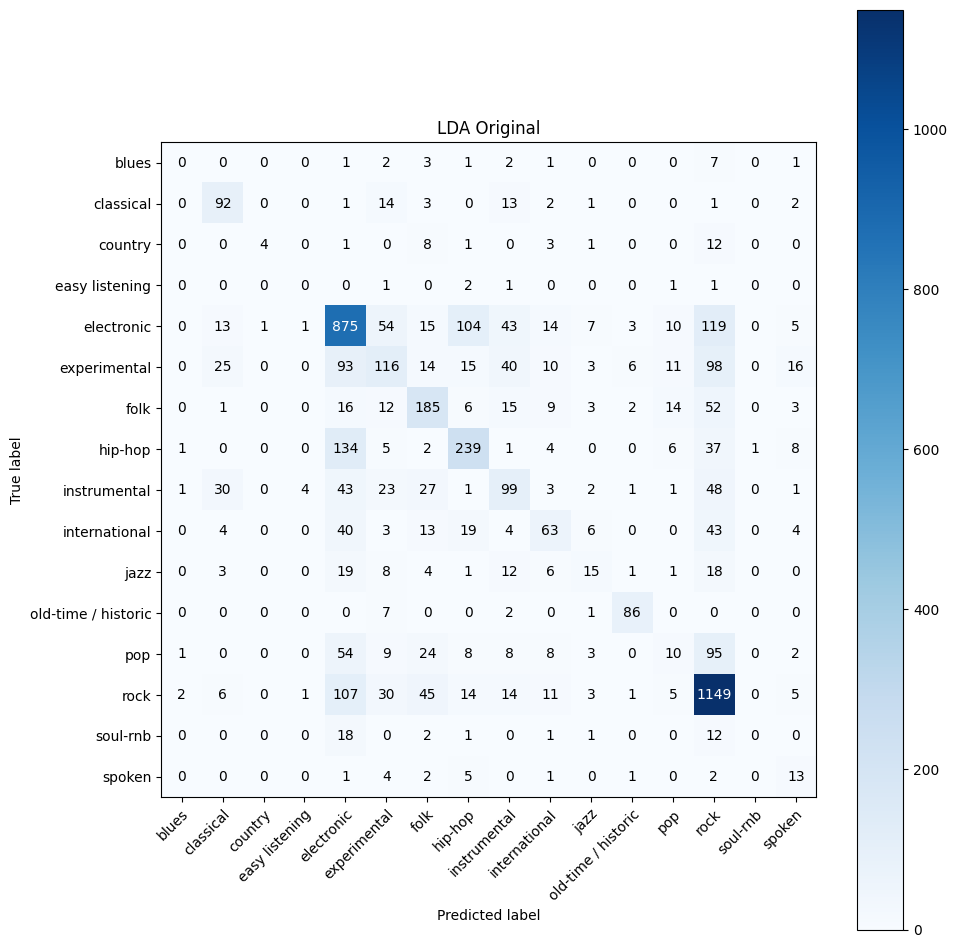

In [62]:
lda(X_trains[0], y_train, X_tests[0], y_test, title='LDA full dataset')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.48      0.71      0.58       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.58      0.69      0.63      1264
       experimental       0.36      0.23      0.28       447
               folk       0.50      0.56      0.53       318
            hip-hop       0.53      0.46      0.49       438
       instrumental       0.39      0.31      0.34       284
      international       0.41      0.23      0.29       199
               jazz       0.27      0.09      0.14        88
old-time / historic       0.81      0.81      0.81        96
                pop       0.18      0.02      0.03       222
               rock       0.65      0.81      0.72      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

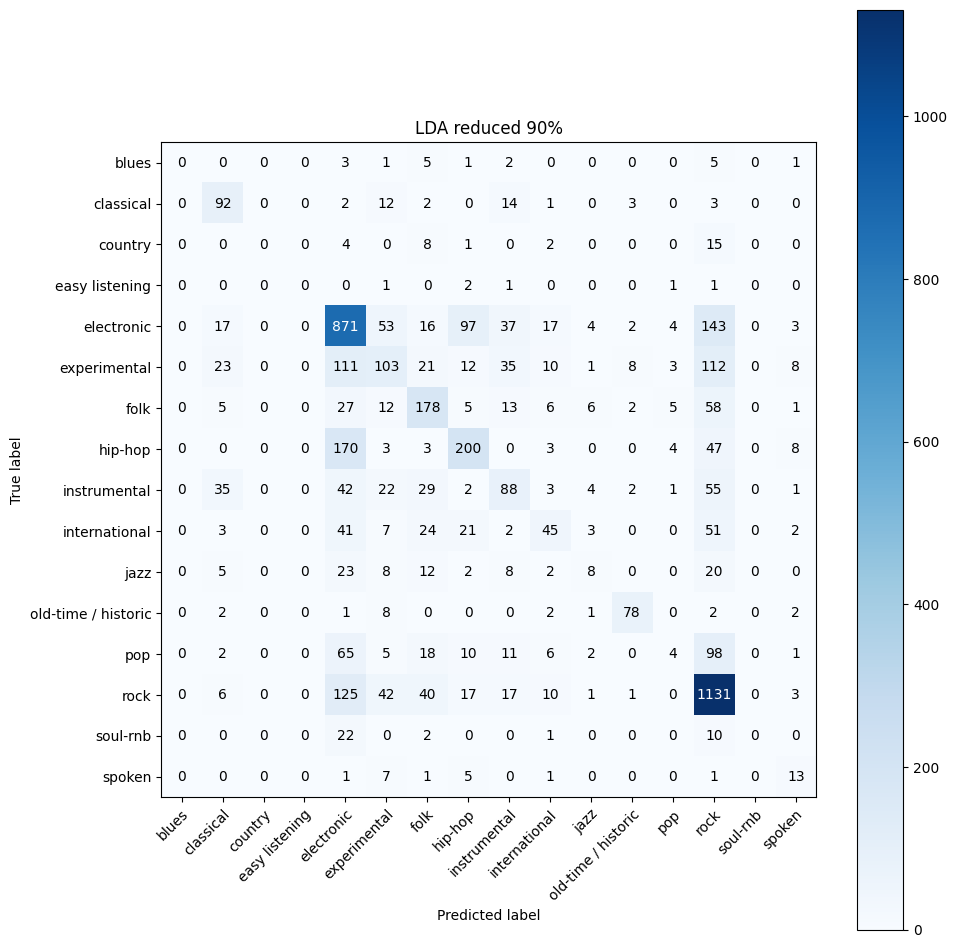

In [63]:
lda(X_trains[1], y_train, X_tests[1], y_test, title='LDA reduced 90%')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.44      0.60      0.50       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.54      0.70      0.61      1264
       experimental       0.32      0.19      0.24       447
               folk       0.47      0.51      0.49       318
            hip-hop       0.43      0.16      0.24       438
       instrumental       0.34      0.28      0.30       284
      international       0.38      0.13      0.19       199
               jazz       1.00      0.01      0.02        88
old-time / historic       0.60      0.74      0.66        96
                pop       0.00      0.00      0.00       222
               rock       0.60      0.83      0.70      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

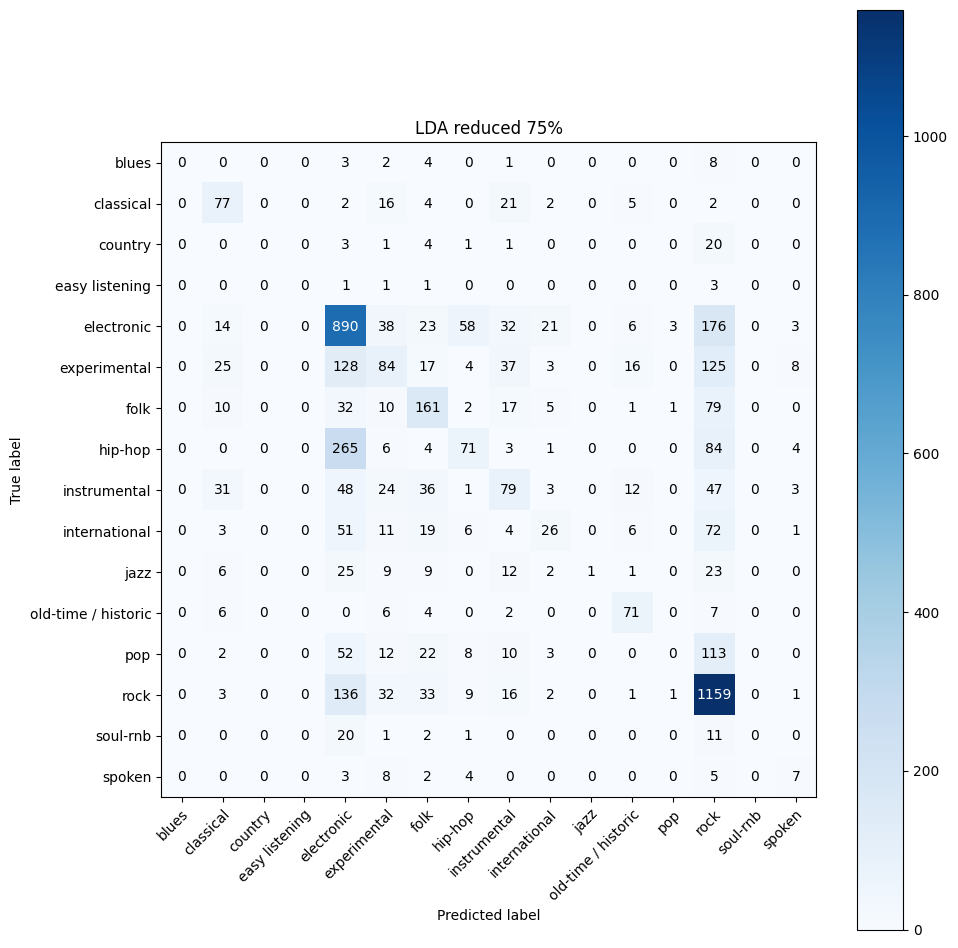

In [64]:
lda(X_trains[2], y_train, X_tests[2], y_test, title='LDA reduced 75%')

# kNN: k-Nearest-Neighbors

Qui si analizzano le performance dell'algoritmo facendo variare i seguenti iperparametri.

In [69]:
hyperparameters = {
    'n_neighbors': range(3,50,1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

## Model selection

### Best n_neighbors

In [34]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per salvare le metriche
accuracy_results, f1_results = list(), list()
scoring = ['accuracy', 'f1_weighted']

for k in hyperparameters['n_neighbors']:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"k={k}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")


k=3: Accuracy=0.5815, F1_weighted=0.5649
k=4: Accuracy=0.5918, F1_weighted=0.5733
k=5: Accuracy=0.5926, F1_weighted=0.5718
k=6: Accuracy=0.5971, F1_weighted=0.5743
k=7: Accuracy=0.6002, F1_weighted=0.5750
k=8: Accuracy=0.5990, F1_weighted=0.5717
k=9: Accuracy=0.5997, F1_weighted=0.5706
k=10: Accuracy=0.6001, F1_weighted=0.5703
k=11: Accuracy=0.6010, F1_weighted=0.5698
k=12: Accuracy=0.5999, F1_weighted=0.5682
k=13: Accuracy=0.6005, F1_weighted=0.5676
k=14: Accuracy=0.5984, F1_weighted=0.5642
k=15: Accuracy=0.5971, F1_weighted=0.5619
k=16: Accuracy=0.5981, F1_weighted=0.5625
k=17: Accuracy=0.5961, F1_weighted=0.5598
k=18: Accuracy=0.5955, F1_weighted=0.5586
k=19: Accuracy=0.5956, F1_weighted=0.5585
k=20: Accuracy=0.5939, F1_weighted=0.5559
k=21: Accuracy=0.5937, F1_weighted=0.5552
k=22: Accuracy=0.5931, F1_weighted=0.5540
k=23: Accuracy=0.5934, F1_weighted=0.5542
k=24: Accuracy=0.5924, F1_weighted=0.5527
k=25: Accuracy=0.5921, F1_weighted=0.5519
k=26: Accuracy=0.5906, F1_weighted=0.5499

In [35]:
# find the best n estimator
best_n_neighbors = hyperparameters['n_neighbors'][np.argmax(accuracy_results)]
print(f'Best n estimator: {best_n_neighbors}')
print(f'Best accuracy: {max(accuracy_results)}')


Best n estimator: 11
Best accuracy: 0.6009598392789989


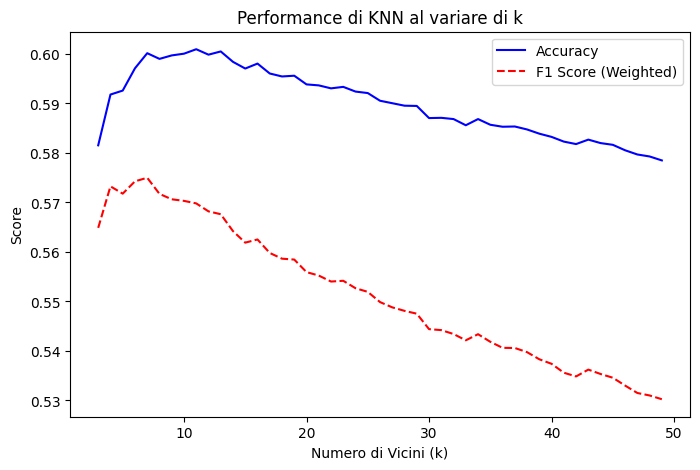

In [39]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(hyperparameters['n_neighbors'], accuracy_results, linestyle='-', label="Accuracy", color="blue")
plt.plot(hyperparameters['n_neighbors'], f1_results, linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Numero di Vicini (k)")
plt.ylabel("Score")
plt.title("Performance di KNN al variare di k")
plt.legend()
plt.show()

### Best Weights

In [40]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per salvare le metriche
accuracy_results, f1_results = list(), list()
scoring = ['accuracy', 'f1_weighted']

for k in hyperparameters['weights']:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=k)
    scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"weights={k}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")


weights=uniform: Accuracy=0.6010, F1_weighted=0.5698
weights=distance: Accuracy=0.6037, F1_weighted=0.5747


In [41]:
best_weights = hyperparameters['weights'][np.argmax(accuracy_results)]
print(f'Best weights: {best_weights}')
print(f'Best accuracy: {max(accuracy_results)}')

Best weights: distance
Best accuracy: 0.6036621664185446


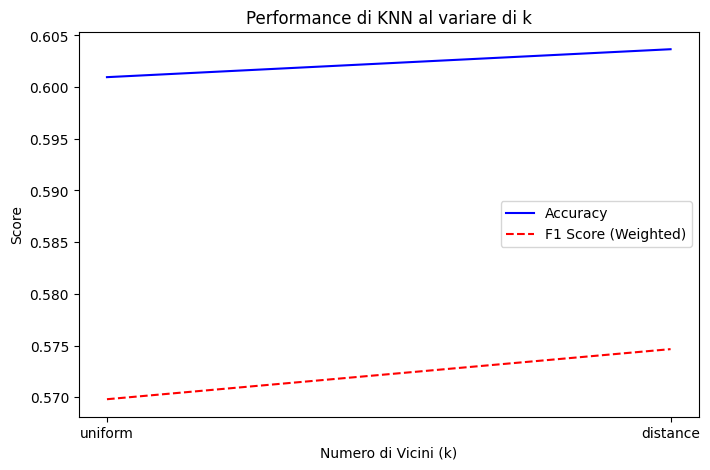

In [42]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(hyperparameters['weights'], accuracy_results, linestyle='-', label="Accuracy", color="blue")
plt.plot(hyperparameters['weights'], f1_results, linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Numero di Vicini (k)")
plt.ylabel("Score")
plt.title("Performance di KNN al variare di k")
plt.legend()
plt.show()

### Best metric

In [43]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per salvare le metriche
accuracy_results = []
f1_results = []

# Loop su k
for k in hyperparameters['metric']:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=k)
    scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"metric={k}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")


metric=euclidean: Accuracy=0.6037, F1_weighted=0.5747
metric=manhattan: Accuracy=0.6015, F1_weighted=0.5721
metric=chebyshev: Accuracy=0.5746, F1_weighted=0.5412
metric=minkowski: Accuracy=0.6037, F1_weighted=0.5747


In [44]:
best_metric = hyperparameters['metric'][np.argmax(accuracy_results)]
print(f'Best metric: {best_metric}')
print(f'Best accuracy: {max(accuracy_results)}')

Best metric: euclidean
Best accuracy: 0.6036621664185446


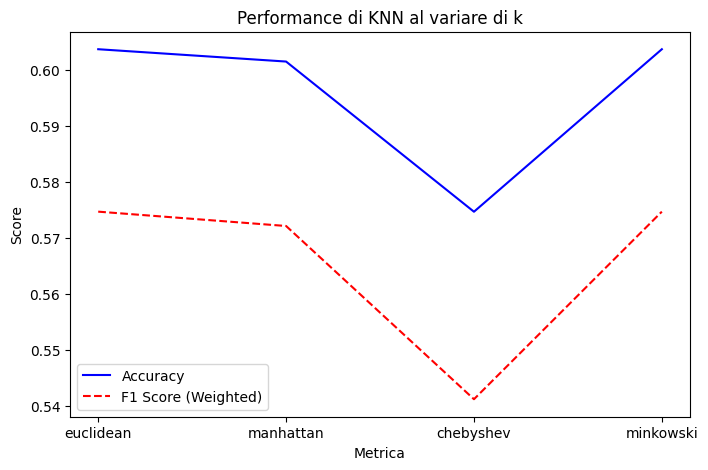

In [45]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(hyperparameters['metric'], accuracy_results, linestyle='-', label="Accuracy", color="blue")
plt.plot(hyperparameters['metric'], f1_results, linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Metrica")
plt.ylabel("Score")
plt.title("Performance di KNN al variare di k")
plt.legend()
plt.show()

## Model selection - GridSearch Knn

In [ ]:
model = sklearn.neighbors.KNeighborsClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5, n_jobs=8)

grid_search.fit(X_trains[1], y_train.values.ravel())

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_tests[1], y_test)
print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

## Valuate best model

                     precision    recall  f1-score   support

              blues       0.80      0.22      0.35        18
          classical       0.53      0.85      0.65       129
            country       0.26      0.30      0.28        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.69      0.61      0.65      1264
       experimental       0.62      0.22      0.33       447
               folk       0.56      0.63      0.59       318
            hip-hop       0.49      0.65      0.56       438
       instrumental       0.46      0.30      0.36       284
      international       0.52      0.59      0.55       199
               jazz       0.54      0.33      0.41        88
old-time / historic       0.86      0.95      0.90        96
                pop       0.30      0.13      0.18       222
               rock       0.66      0.87      0.75      1393
           soul-rnb       0.38      0.09      0.14        35
             spoken    

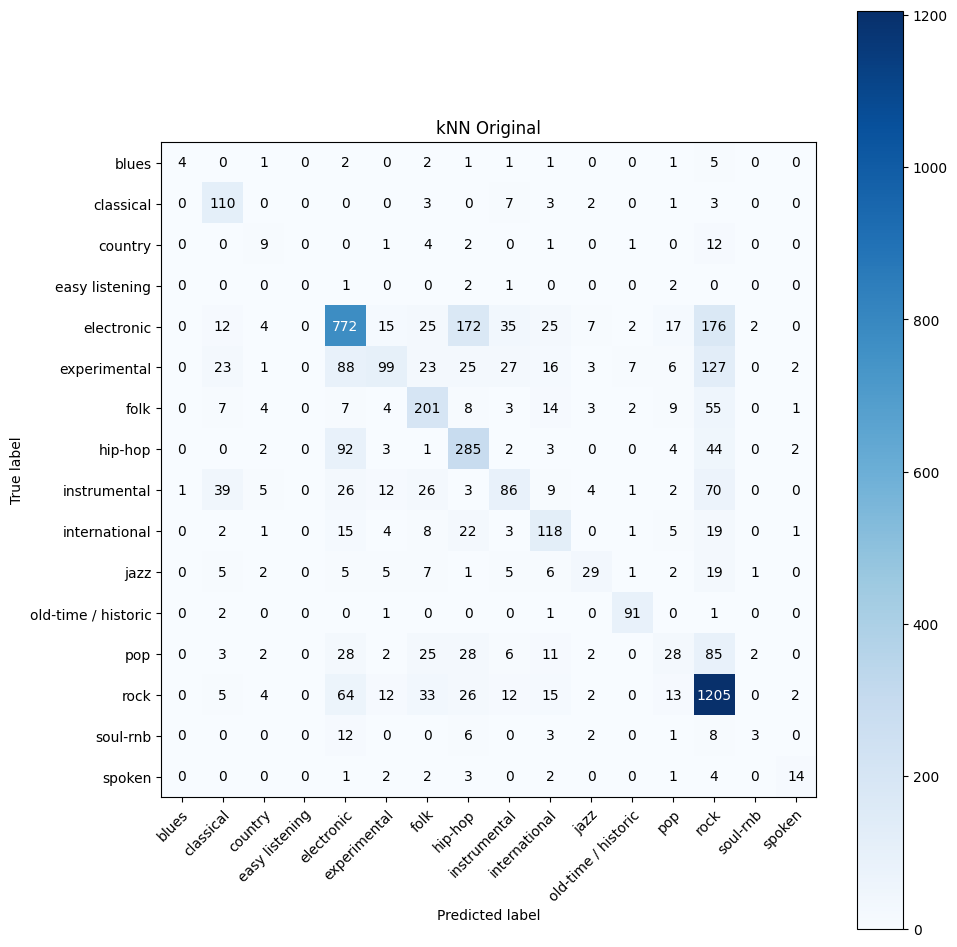

In [38]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=11, weights='distance', metric='euclidean')
model.fit(X_trains[0], y_train)
valuate(model, X_tests[0], y_test, title = 'kNN full dataset')

                     precision    recall  f1-score   support

              blues       0.67      0.11      0.19        18
          classical       0.53      0.84      0.65       129
            country       0.24      0.30      0.27        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.67      0.64      0.65      1264
       experimental       0.55      0.22      0.32       447
               folk       0.52      0.61      0.57       318
            hip-hop       0.50      0.59      0.54       438
       instrumental       0.48      0.30      0.37       284
      international       0.51      0.52      0.52       199
               jazz       0.55      0.25      0.34        88
old-time / historic       0.87      0.93      0.90        96
                pop       0.24      0.09      0.13       222
               rock       0.65      0.86      0.74      1393
           soul-rnb       0.38      0.09      0.14        35
             spoken    

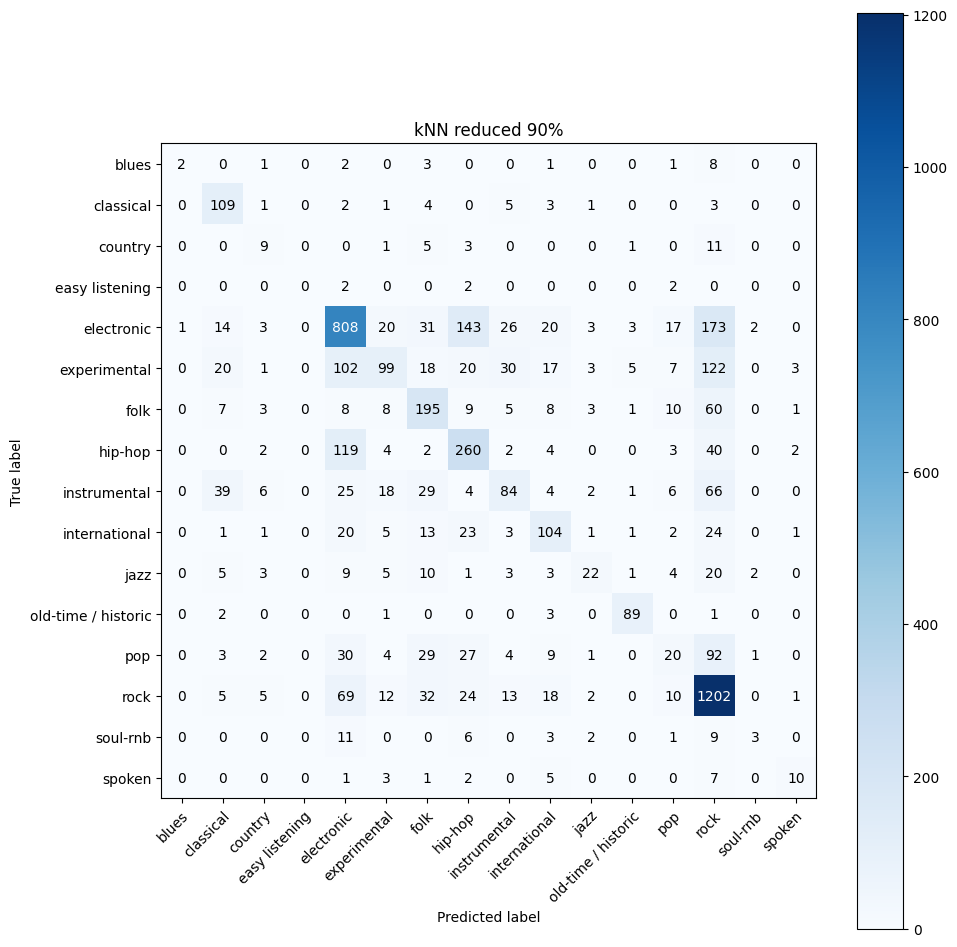

In [39]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=11, weights='distance', metric='euclidean')
model.fit(X_trains[1], y_train)
valuate(model, X_tests[1], y_test, title = 'kNN reduced 90%')

                     precision    recall  f1-score   support

              blues       0.50      0.06      0.10        18
          classical       0.51      0.74      0.60       129
            country       0.33      0.10      0.15        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.61      0.67      0.64      1264
       experimental       0.42      0.19      0.26       447
               folk       0.50      0.60      0.55       318
            hip-hop       0.48      0.48      0.48       438
       instrumental       0.38      0.29      0.32       284
      international       0.49      0.40      0.44       199
               jazz       0.31      0.12      0.18        88
old-time / historic       0.84      0.94      0.89        96
                pop       0.17      0.05      0.08       222
               rock       0.65      0.83      0.73      1393
           soul-rnb       0.33      0.03      0.05        35
             spoken    

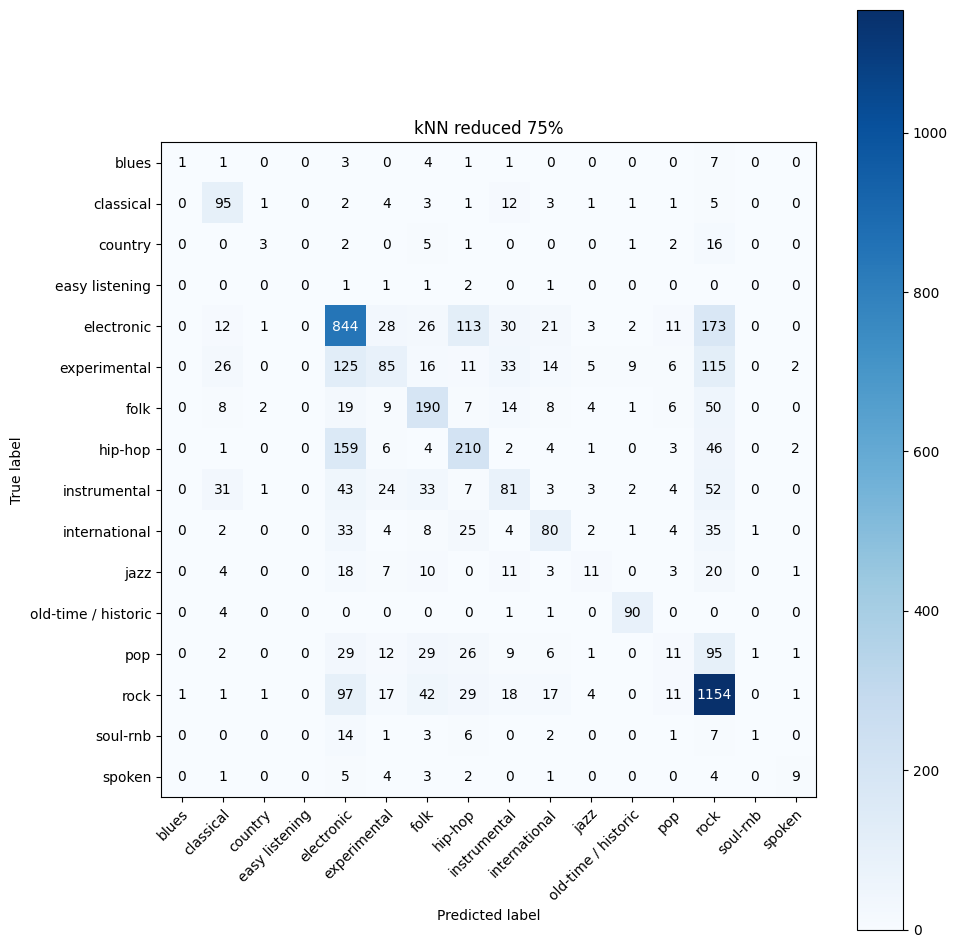

In [40]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=11, weights='distance', metric='euclidean')
model.fit(X_trains[2], y_train)
valuate(model, X_tests[2], y_test, title = 'kNN reduced 75%')

# Softmax Regression

In [41]:
# logistic regression
from sklearn.linear_model import LogisticRegression

def logistic_regression(X_train, y_train, X_test, y_test, C: float = 1.0, penalty: str = "l2", title: str = 'Logistic Regression'):
    # create the model
    model = LogisticRegression(max_iter=1000, C=C, penalty=penalty)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matrix
    valuate(model, X_test, y_test, title=title)

## Model selection
Si valuta il modello al variare dell'iperparametro $C$.

In [53]:
c_range = np.linspace(1,6,100)
X_train, X_test = X_trains[1], X_tests[1]

# Liste per raccogliere le metriche
accuracy_results, f1_results = list(), list()
scoring = ['accuracy', 'f1_weighted']

for c in c_range:
    model = LogisticRegression(max_iter=1000, C=c, penalty='l2', n_jobs=8)
    scores = cross_validate(model, X_train, y_train.values.ravel(), scoring=scoring, cv=10, n_jobs=8)
    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy_results.append(accuracy)
    f1_results.append(f1)
    print(f"c={c}: Accuracy={accuracy:.4f}, F1_weighted={f1:.4f}")

c=1.0: Accuracy=0.5805, F1_weighted=0.5388
c=1.0505050505050506: Accuracy=0.5807, F1_weighted=0.5391
c=1.101010101010101: Accuracy=0.5808, F1_weighted=0.5391
c=1.1515151515151516: Accuracy=0.5807, F1_weighted=0.5391
c=1.202020202020202: Accuracy=0.5807, F1_weighted=0.5391
c=1.2525252525252526: Accuracy=0.5805, F1_weighted=0.5389
c=1.303030303030303: Accuracy=0.5809, F1_weighted=0.5393
c=1.3535353535353536: Accuracy=0.5810, F1_weighted=0.5394
c=1.404040404040404: Accuracy=0.5807, F1_weighted=0.5390
c=1.4545454545454546: Accuracy=0.5806, F1_weighted=0.5389
c=1.5050505050505052: Accuracy=0.5807, F1_weighted=0.5390
c=1.5555555555555556: Accuracy=0.5808, F1_weighted=0.5391
c=1.606060606060606: Accuracy=0.5806, F1_weighted=0.5389
c=1.6565656565656566: Accuracy=0.5805, F1_weighted=0.5388
c=1.7070707070707072: Accuracy=0.5808, F1_weighted=0.5392
c=1.7575757575757576: Accuracy=0.5808, F1_weighted=0.5391
c=1.808080808080808: Accuracy=0.5807, F1_weighted=0.5391
c=1.8585858585858586: Accuracy=0.58

In [54]:
best_c = c_range[np.argmax(accuracy_results)]
print(f'Best c: {best_c}')
print(f'Best accuracy: {max(accuracy_results)}')

Best c: 1.3535353535353536
Best accuracy: 0.5809934747153357


## Valuate best model

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.63      0.80      0.70       129
            country       0.28      0.17      0.21        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.60      0.74      0.66      1264
       experimental       0.44      0.28      0.34       447
               folk       0.57      0.56      0.57       318
            hip-hop       0.60      0.54      0.57       438
       instrumental       0.44      0.31      0.37       284
      international       0.48      0.32      0.38       199
               jazz       0.41      0.12      0.19        88
old-time / historic       0.85      0.96      0.90        96
                pop       0.25      0.05      0.08       222
               rock       0.67      0.84      0.75      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

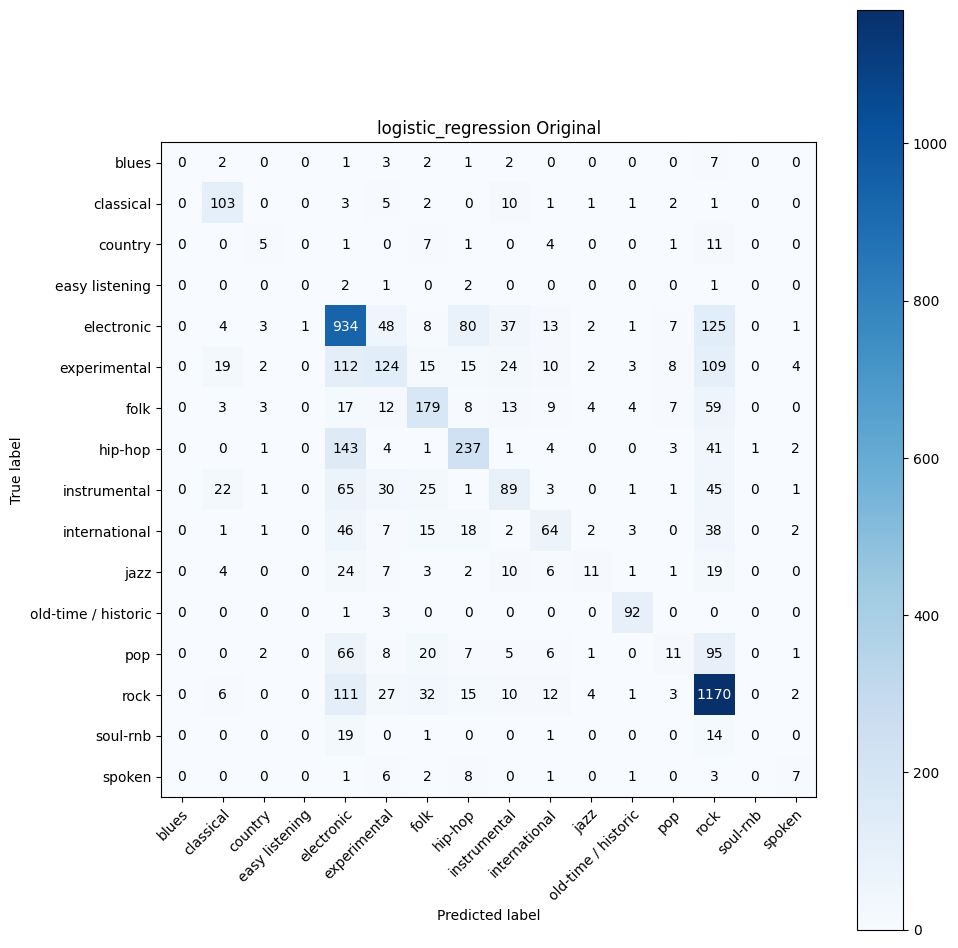

In [43]:
logistic_regression(X_trains[0], y_train, X_tests[0], y_test, C=best_c, title="Logistic Regression full dataset")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.62      0.74      0.68       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.56      0.72      0.63      1264
       experimental       0.38      0.23      0.29       447
               folk       0.51      0.55      0.53       318
            hip-hop       0.56      0.45      0.50       438
       instrumental       0.41      0.27      0.33       284
      international       0.41      0.20      0.27       199
               jazz       0.25      0.03      0.06        88
old-time / historic       0.87      0.95      0.91        96
                pop       0.25      0.02      0.04       222
               rock       0.63      0.82      0.72      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

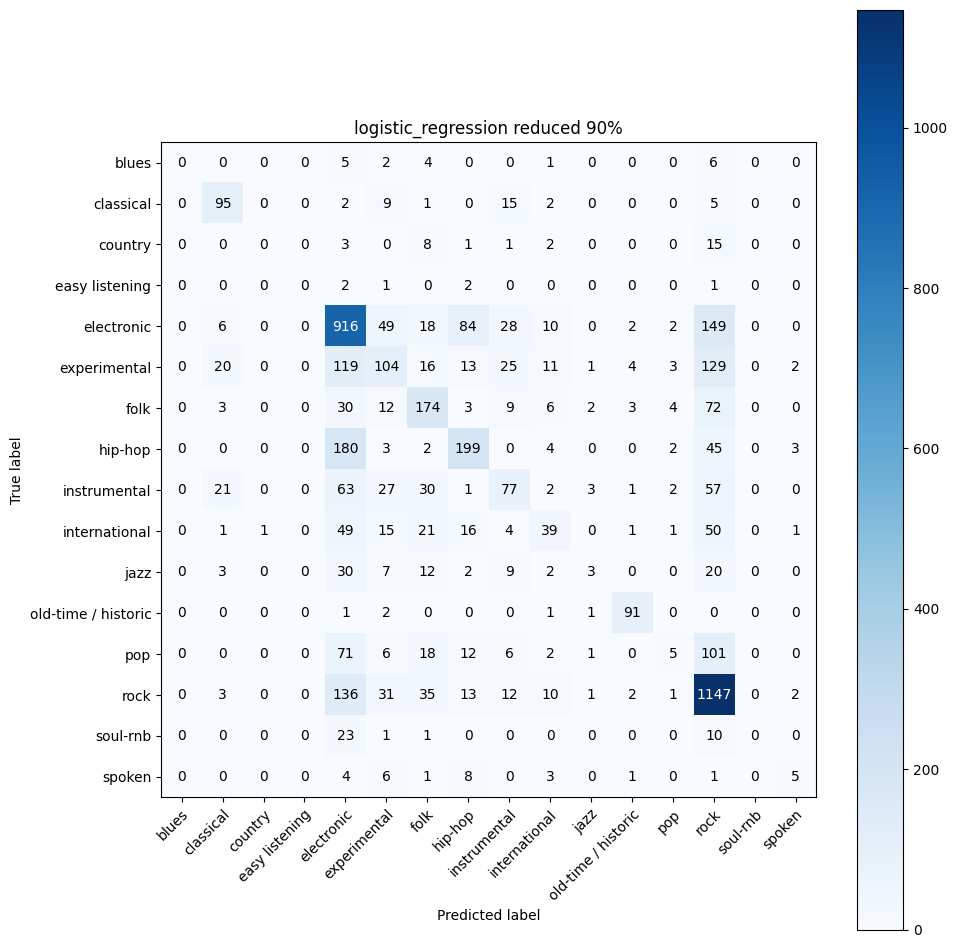

In [44]:
logistic_regression(X_trains[1], y_train, X_tests[1], y_test, title="Logistic Regression reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.56      0.58      0.57       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.51      0.73      0.60      1264
       experimental       0.33      0.20      0.25       447
               folk       0.47      0.52      0.49       318
            hip-hop       0.46      0.20      0.27       438
       instrumental       0.34      0.22      0.26       284
      international       0.46      0.13      0.20       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.75      0.88      0.81        96
                pop       0.25      0.00      0.01       222
               rock       0.61      0.83      0.71      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

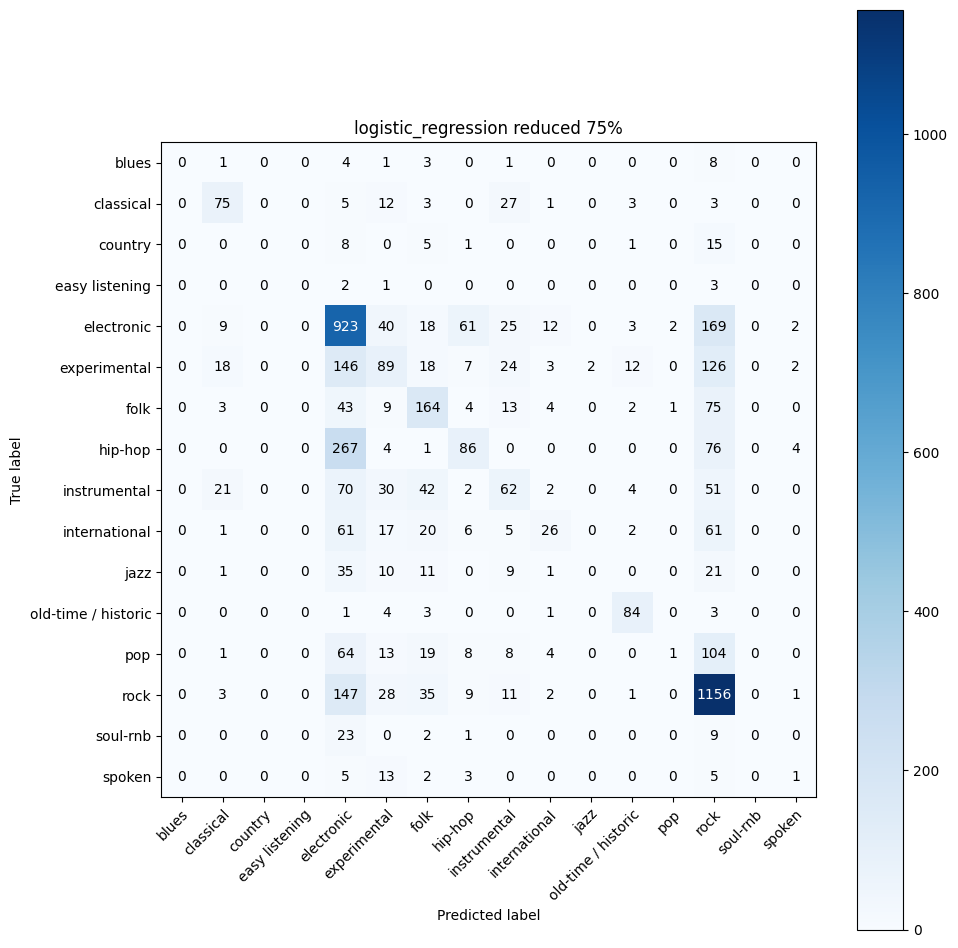

In [45]:
logistic_regression(X_trains[2], y_train, X_tests[2], y_test, title="Logistic Regression reduced 75%")

# Confronto modelli

In [98]:
models_accuracy = [[],[],[]]
models_f1 = [[],[],[]]
label_encoder = LabelEncoder()

models = sorted([model[:-4] for model in os.listdir(MODEL_DIR) if not os.path.isdir(model)])

for model in models:
    clf = load_model(model + ".pkl")
    i = int(model[-1])
    y_pred = clf.predict(X_tests[i])
    if model in ['xgboost0','xgboost1','xgboost2']:
        y_test_enc = label_encoder.fit_transform(y_test)
    else:
        y_test_enc = y_test
    models_accuracy[i].append(accuracy_score(y_test_enc, y_pred))
    models_f1[i].append(f1_score(y_test_enc, y_pred, average='weighted'))


In [99]:
# valori di accuracy e f1 della NN.
models_accuracy[0].append(.6335068345069885)
models_accuracy[1].append(.5954763889312744)
models_accuracy[2].append(.5502402186393738)

models_f1[0].append(0.608824610710144)
models_f1[1].append(.5632396936416626)
models_f1[2].append(.5032026767730713)

In [100]:
def plot_chart(data, ylabel):
    
    # Creiamo un array di indici per le ascisse
    x = np.arange(len(data[0]))  # Assumiamo che tutte le sottoliste abbiano la stessa lunghezza
    
    # Impostiamo la larghezza delle barre
    width = 0.20
    
    # Tracciamo le barre per ogni sottolista
    fig, ax = plt.subplots(figsize=(14, 4))

    ax.bar(x - width, data[0], width, label='Original (78 features)')
    ax.bar(x, data[1], width, label='31 features PCA (90% variance)')
    ax.bar(x + width, data[2], width, label='12 features PCA (75% variance)')

    # Etichettiamo le ascisse e ordinate
    ax.set_xlabel('Model')
    ax.set_ylabel(ylabel)
    ax.set_title(f"Model's {ylabel} plot")
    
    ax.set_xticks(x)
    models = sorted(set(model[:-5] for model in os.listdir(MODEL_DIR) if not os.path.isdir(model))) + ['mlp']
    ax.set_xticklabels(models)

    # Aggiungiamo una legenda
    ax.legend(loc=3)

    # Mostriamo il grafico
    plt.show()

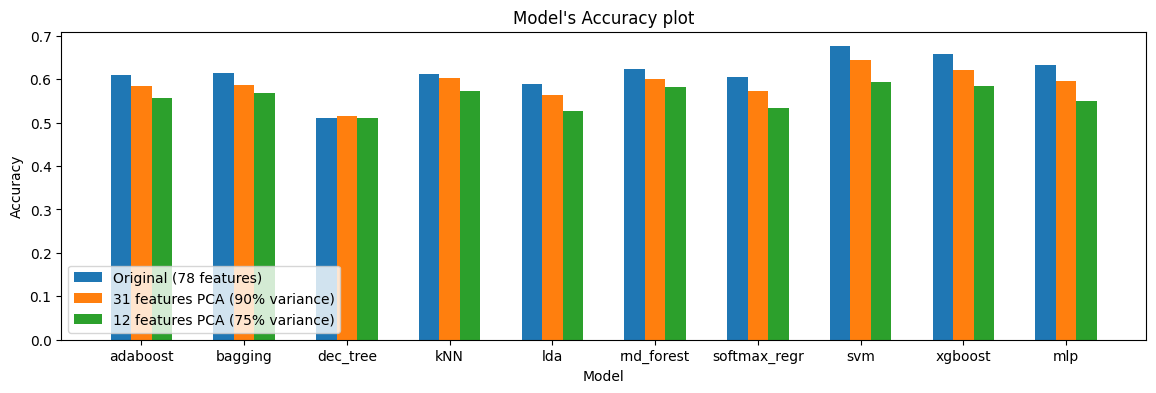

In [101]:
plot_segments(models_accuracy, 'Accuracy')

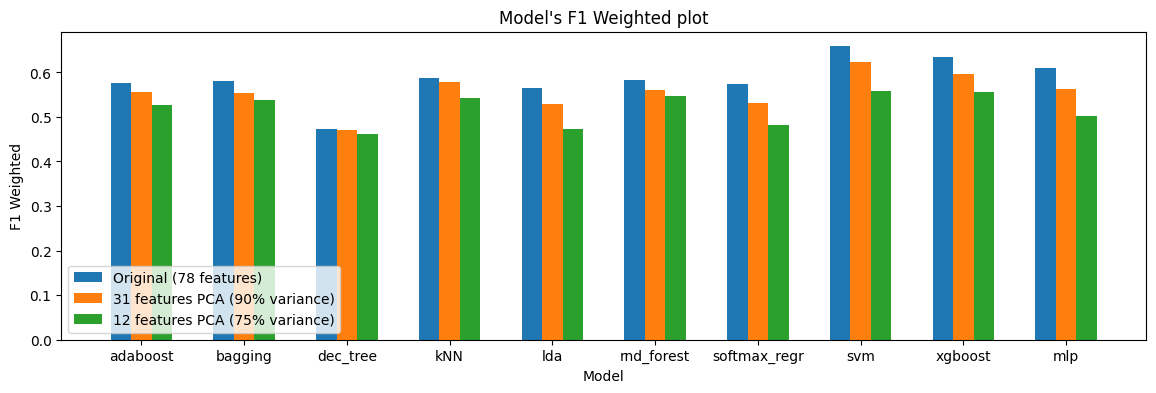

In [102]:
plot_segments(models_f1, 'F1 Weighted')

# Advanced Baseline Models

In questa sezione avremmo voluto descrivere un'architettura basata su LSTM da usare come basiline per i nostri modelli di machine learning; tuttavia, a causa delle nostre risorse computazionali limitate non è stato possibile completare il training. Qui è  possibile consultare il codice per il training.

In [ ]:
# Convertire le feature in array numpy
X = np.load("./audio.npy")
y = np.load("./target.npy")

# Convertire le label in numeri
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creazione del Dataset personalizzato
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Creazione dei DataLoader
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definizione del modello LSTM
class LSTMAudioClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMAudioClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Istanziamento del modello
input_size = 1
hidden_size = 128
num_classes = 16
model = LSTMAudioClassifier(input_size, hidden_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definizione della funzione di perdita e ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training del modello
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Valutazione del modello
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# salva pesi modello
model_path = "./lstm_genre_classifier.pth"
torch.save(model.state_dict(), model_path)
print(f"Modello salvato in {model_path}")

Usiamo quindi come baseline [questo](https://github.com/carlosgorlongaiatto/NNDL_Project/blob/main/documentation/report.pdf) lavoro con autori Chiara Maccani, Theivan Pasupathipillai, Carlo Sgorlon Gaiatto del Dipartimento di Fisica e Astronomia dell'Università di Padova. Di seguito un breve riassunto dei loro risultati.
### Modelli Proposti
1. **1-D CNN**: input waveform, encoder CNN + MLP finale.
2. **2-D CNN**: input mel-spectrogram, encoder con blocchi residui + MLP finale.
3. **CRNN**: variante del 2-D CNN con LSTM al posto dell’MLP.
4. **MM-CRNN**: architettura multi-modale che concatena feature da 1-D CNN e 2-D CNN, successivamente elaborate da un LSTM.
### Dataset
- **Free Music Archive (FMA) - versione small**:
  - 8.000 tracce bilanciate su 8 generi principali.
  - Clip da 30 secondi ridotte a 12 secondi.
  - Pre-processing: rimozione tracce corrotte, normalizzazione z-score e data augmentation (noise, time stretch).
### Pipeline e Feature
- Estrazione di mel-spectrogram (128 mel-band, 512 finestre).
- Data augmentation tramite **audiomentation** (noise e time-stretch).
- Normalizzazione band-wise per mel-spectrogram.
### Architetture
- 1-D CNN
  - Encoder con 4 blocchi CNN + max-pooling.
  - Bottleneck con global pooling (concat max/avg pooling).
  - MLP classificatore (8 classi).
- 2-D CNN
  - Encoder con 4 blocchi residui (skip connections).
  - Bottleneck e MLP come nel 1-D CNN.
- CRNN
  - Encoder del 2-D CNN.
  - LSTM (128 hidden units) al posto di bottleneck + MLP.
- MM-CRNN
  - Feature da 1-D e 2-D CNN concatenate.
  - LSTM finale.
- Training
  - Loss: cross-entropy multi-classe.
  - Ottimizzatore: Adam (lr=0.001).
  - Early stopping su validazione.
  - Grid search su dropout e weight decay.
### Risultati
| Modello      | Accuracy | Precision | Recall | F1-score |
|--------------|----------|-----------|--------|----------|
| 1-D CNN      | 0.88     | 0.54      | 0.54   | 0.54     |
| 2-D CNN      | 0.90     | 0.59      | 0.60   | 0.60     |
| CRNN         | 0.90     | 0.60      | 0.61   | 0.60     |
| MM-CRNN      | 0.89     | 0.58      | 0.57   | 0.58     |


# Conclusioni

In questo studio, abbiamo analizzato e confrontato diversi algoritmi di classificazione per il nostro dataset: 
- **Support Vector Machine (SVM)**
- **Decision Tree**
- **Bagging**
- **Boosting**
- **Rete Neurale**
- **Softmax Regression**
- **Gaussian Discriminant Analysis (GDA)**
- **k-Nearest Neighbors (kNN)**

L'obiettivo era valutare le loro prestazioni utilizzando diverse metriche, tra cui accuratezza, F1-score e matrice di confusione. Per ogni algoritmo abbiamo fatto model-selection, e abbiamo mostrato le sue performance con il miglior set di iperparametri, facendo variare il numero di feature (75% della varianza, poi il 90% e infine il 100%). I risultati che abbiamo ottenuto mostrano che ottime performance si ottengono già con il 75% della varianza, con il 90% si ottiene un miglioramento non trascurabile mentre il salto a 100% offre miglioramenti abbastanza marginali.

## Metodologia

Abbiamo iniziato con la preparazione del dataset, includendo: feature selection, normalizzazione e selezione delle feature più rilevanti tramite PCA. Successivamente, abbiamo addestrato e testato ogni modello utilizzando tre diverse suddivisioni train-test (75%, 90% e 100% della varianza) e, per tutti i modelli eccetto Multilayer Perceptron, abbiamo esplorato diversi valori degli iperparametri per ottimizzare le performance.

## Limitazioni e sviluppi futuri

Questo studio presenta alcune limitazioni che potrebbero influenzare i risultati ottenuti:

- **Rappresentazione dei dati**: Non abbiamo utilizzato tecniche avanzate come autoencoder o altre forme di apprendimento non supervisionato per l'estrazione automatica delle feature, ma ci siamo limitati alle feature estratte con dei software di *Audio Signal Processing*.

- **Dataset sbilanciato**: L'analisi è stata condotta su un dataset fortemente sbilanciato, il che ha influenzato le prestazioni dei modelli e la capacità di generalizzazione, favorendo le classi più rappresentate.

- **Modelli non deep**: Tutti i modelli utilizzati appartengono alla famiglia del machine learning tradizionale e non abbiamo esplorato approcci deep learning, che potrebbero offrire prestazioni superiori in determinati contesti.

Come evidenziato dalla sezione precedente, le performance che si ottengono utilizzando dei modelli deep (anche naive) sono molto superiori (soprattutto in accuracy) dei modelli ottenuti con approcci classici.